In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
print(sklearn.__version__)

0.19.1


In [2]:
data = pd.read_pickle("ltv_dataset.gzip",compression="gzip") 

In [3]:
b_columns = [x for x in data.columns.values if x.startswith("b_")]
c_columns = [x for x in data.columns.values if x.startswith("c_")]
n_columns = [x for x in data.columns.values if x.startswith("n_")]

prefixs = ["age_","locale_","country_id_sqz_","gender_","currency_id_sqz","client_platform_id_","is_public_"]

def has_prefix(x,prefixs):
    for p in prefixs:
        if x.startswith(p):
            return True
    return False

with_prefix_columns = [x for x in data.columns.values if has_prefix(x,prefixs)]
simple_columns = ['has_nik','is_regulated','is_trial']

feature_columns = b_columns+c_columns+n_columns + with_prefix_columns+simple_columns
[x for x in data.columns.values if x not in feature_columns]

['user_id',
 'age',
 'binary_pnl_30',
 'client_platform_id',
 'commission_30',
 'country_id',
 'currency_id',
 'gender',
 'has_pnl',
 'is_public',
 'locale',
 'ni_pnl_30',
 'sum_pnl',
 'tz',
 'country_id_225',
 'country_id_94',
 'country_id_30',
 'country_id_164',
 'country_id_140',
 'country_id_97',
 'country_id_175',
 'country_id_205',
 'country_id_206',
 'country_id_157',
 'currency_id_5',
 'currency_id_1',
 'currency_id_2',
 'currency_id_6',
 'currency_id_43']

In [4]:
X = data[feature_columns].as_matrix()
y = data["has_pnl"].as_matrix().astype(bool)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [5]:
n_estimator = 300
random_state = 0
# clf = RandomForestClassifier(max_depth=3,n_jobs=4,n_estimators=n_estimator, random_state=random_state)
clf = RandomForestClassifier(max_depth=3,
                             n_jobs=4,
                             n_estimators=n_estimator, 
                             random_state=random_state,
                             verbose = 1,
                             class_weight = "balanced_subsample")
clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  6.1min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=4, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

In [6]:
y_predict_prob = clf.predict_proba(X_test)[:, 1]
y_classes = y_test

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   16.3s finished


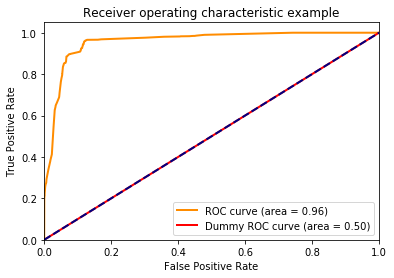

In [7]:
fpr, tpr, thresholds = roc_curve(y_classes, y_predict_prob)
roc_auc = auc(fpr, tpr)

y_dummy_predict_prob = np.full_like(y_predict_prob, False)
dummy_fpr, dummy_tpr, _ = roc_curve(y_classes, y_dummy_predict_prob)
dummy_roc_auc = auc(dummy_fpr, dummy_tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot(dummy_fpr, dummy_tpr, color='red',
         lw=lw, label='Dummy ROC curve (area = %0.2f)' % dummy_roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
# f1_scores = np.array([f1_score(y_test, y_predict_prob > t) for t in thresholds])
# max_f1_score_index = np.argmax(f1_scores)
# print(f"Score max:{f1_scores[max_f1_score_index]}")
# main_threshold = thresholds[max_f1_score_index]


# true_rate = y_test.sum() / y_test.shape[0]
# false_rate = 1 - true_rate
# def cutoff_youdens_j(fpr,tpr,thresholds):
#     j_scores = tpr-fpr
#     j_ordered = sorted(zip(j_scores,thresholds))
#     return j_ordered[-1][1]


def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

main_threshold = cutoff_youdens_j(fpr,tpr,thresholds)



In [9]:
# 0.0535
# main_threshold = 0.0535
# main_threshold = 0.1
print(f"Threshold :{main_threshold}")
y_predict = y_predict_prob > main_threshold
acc = accuracy_score(y_test, y_predict)
prec = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1_s = f1_score(y_test, y_predict)
print(f"Accuracy:{acc}")
print(f"Precision:{prec}")
print(f"Recall:{rec}")
print(f"F1_score:{f1_s}")

Threshold :0.4147789802960621
Accuracy:0.8803268904138212
Precision:0.24566570367313248
Recall:0.9622626868760022
F1_score:0.3914055534075576


Confusion matrix, without normalization
[[1752835  103333]
 [  12983   64341]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.17  0.83]]


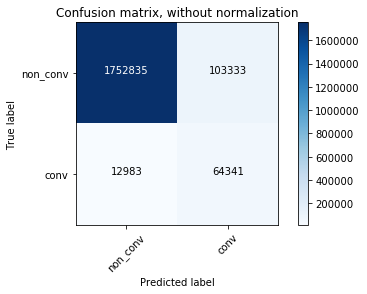

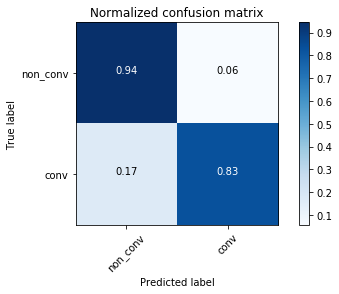

In [10]:
# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_predict)
cnf_matrix = confusion_matrix(y_test, y_predict_prob > 0.6)

np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = ["non_conv","conv"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [11]:
true_rate = y_test.sum() / y_test.shape[0]
false_rate = 1 - true_rate
result = 0.96 * true_rate + 0.12 * false_rate
result

0.15359318786940934

In [12]:
imp_f = sorted(list(zip(feature_columns, clf.feature_importances_)),key = lambda x: -x[1])
imp_f

[('gender_1', 0.19546571268447677),
 ('has_nik', 0.1776720233886907),
 ('is_trial', 0.094356863004110003),
 ('age_30_40', 0.085773153677458899),
 ('age_24_30', 0.080145993210967409),
 ('c_real_count', 0.042541995763670376),
 ('age_18_24', 0.041042746234594904),
 ('c_actives_real_count', 0.030372880228222873),
 ('c_commission_real_crypto', 0.0301409498757454),
 ('c_crypto_count', 0.025437475295765736),
 ('c_instrument_id_crypto_count', 0.022117650532510476),
 ('c_instrument_id_count', 0.020280604218836686),
 ('c_count', 0.019845029690990803),
 ('age_40_50', 0.017066754617080435),
 ('n_closed_count', 0.012625215320789248),
 ('n_instrument_actives_count', 0.01227128138918729),
 ('gender_2', 0.010103819882478628),
 ('b_real_count', 0.0093557411374522274),
 ('n_deal_count', 0.0092517121760808153),
 ('is_regulated', 0.0090726468798581726),
 ('b_actives_real_count', 0.0087506892087049967),
 ('b_volume_real', 0.0067241785977171604),
 ('b_pnl_real', 0.0065216042573886012),
 ('n_volume_real_cryp

In [14]:
import json
model_name = 'random_forest_02'
joblib.dump(clf, model_name+'.pkl') 
json_data = {"sklearn_v":sklearn.__version__,
             "main_threshold":main_threshold,
             "accuracy":acc,"precision":prec,
             "recall":rec,"feature_columns":feature_columns}
with open(model_name+'.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [142]:
[x for x in imp_f if x[0].startswith("age_trash")]

[('is_public_0', 0.0021571479531530494), ('is_public_1', 0.001689868760179453)]

In [163]:
# feature_columns
# data[["user_id","has_pnl"]].loc[data['has_pnl'] == True]

In [15]:
mqls = [(1089963, True), (1107620, True), (1355766, True), (1426596, True), (1729976, True), (1763136, True), (2412404, False), (3103728, True), (3196248, True), (4281082, True), (4536265, True), (4939696, True), (5177568, True), (6159074, True), (6740830, True), (7018500, True), (7044670, True), (7157191, True), (7583273, True), (7853497, True), (7906129, False), (8180356, True), (8352967, False), (8400599, False), (8523017, True), (8806877, True), (8838952, True), (8947880, True), (9032698, True), (9042755, False), (9131423, True), (9162264, True), (9266123, True), (9387251, False), (9403355, False), (9462599, True), (9546734, True), (9571088, True), (9601426, False), (9725455, True), (9736939, True), (9875599, False), (9885044, True), (9974149, True), (10145516, True), (10148188, True), (10376705, True), (10467084, False), (10551210, False), (10643746, True), (10654482, True), (10673064, True), (10760423, True), (10852328, True), (10890224, True), (10893356, True), (10910058, True), (10924005, True), (11047480, True), (11087568, True), (11098202, True), (11123381, False), (11128939, True), (11352771, True), (11374776, True), (11386706, True), (11440421, True), (11536247, False), (11537843, True), (11604670, True), (11667759, True), (11690895, True), (11696960, False), (11711261, True), (11807237, False), (11835764, False), (11916622, True), (11921064, False), (12027637, False), (12043127, False), (12066976, False), (12097919, False), (12155403, True), (12223396, False), (12257646, True), (12291051, True), (12291391, False), (12300372, True), (12330940, True), (12416119, True), (12442357, True), (12502646, True), (12533671, False), (12550300, True), (12594327, False), (12659013, False), (12683456, True), (12709612, True), (12710041, False), (12728352, True), (12728630, False), (12733927, False), (12734475, False), (12795556, True), (12818881, False), (12823147, False), (12827698, True), (12850779, True), (12857130, False), (12867301, True), (12872765, True), (12969675, True), (12994267, False), (13006208, False), (13042528, False), (13049318, True), (13051566, True), (13065118, True), (13072442, True), (13078562, False), (13082233, True), (13132496, True), (13134557, False), (13182509, True), (13236930, True), (13244611, True), (13326416, False), (13335722, True), (13410555, False), (13503120, True), (13509721, False), (13514959, False), (13515742, True), (13529496, True), (13533346, True), (13551172, False), (13563018, False), (13585648, False), (13697361, True), (13711257, False), (13720320, True), (13724263, True), (13787089, False), (13793865, False), (13801183, False), (13809988, False), (13815785, False), (13843470, True), (13849702, False), (13864776, True), (13869531, True), (13915411, True), (13973547, True), (13982333, True), (14013259, True), (14035780, True), (14038042, True), (14038683, True), (14097795, True), (14102091, True), (14114425, False), (14138690, False), (14191843, False), (14217866, True), (14292929, True), (14317794, True), (14332810, True), (14350297, False), (14353565, True), (14357243, True), (14380149, True), (14422139, False), (14424441, True), (14447232, True), (14498493, True), (14571970, True), (14592354, False), (14601696, False), (14610460, True), (14618202, True), (14659430, True), (14664712, True), (14667577, True), (14669185, True), (14669701, True), (14680252, True), (14714173, True), (14720115, True), (14730065, True), (14745079, True), (14757250, False), (14811988, True), (14914137, False), (14919345, True), (14982641, False), (15036872, True), (15104629, False), (15148291, False), (15161449, False), (15181517, False), (15237779, False), (15273086, False), (15365764, False), (15372728, True), (15378336, False), (15393727, True), (15397441, True), (15408879, False), (15448749, True), (15464047, False), (15548564, False), (15550146, False), (15555531, True), (15579976, True), (15599749, True), (15612201, False), (15617187, False), (15683712, False), (15692747, False), (15695754, True), (15712732, False), (15719863, True), (15752684, True), (15755410, False), (15812157, False), (15817102, True), (15818227, True), (15828586, False), (15898921, True), (15906350, True), (15910308, True), (15910916, True), (15920485, False), (15940507, True), (15966554, False), (16023916, True), (16053714, True), (16063497, False), (16085766, False), (16100798, False), (16104050, True), (16145411, False), (16151288, False), (16171812, True), (16173221, False), (16220525, False), (16239981, False), (16254283, False), (16258859, True), (16262736, True), (16310424, True), (16310428, True), (16343122, True), (16344359, False), (16378460, True), (16385305, False), (16399756, False), (16419116, False), (16431098, True), (16454335, False), (16457465, True), (16464405, False), (16465402, True), (16500123, True), (16506570, True), (16563078, False), (16594486, True), (16603738, True), (16676111, True), (16718711, True), (16753997, True), (16762678, False), (16762910, False), (16833420, False), (16886520, False), (16952453, False), (16962674, True), (16991373, False), (17097320, True), (17111223, False), (17184835, True), (17193349, False), (17288073, False), (17313940, True), (17327648, False), (17390302, True), (17403083, True), (17431162, False), (17459921, True), (17499518, False), (17565150, False), (17569428, True), (17618951, False), (17638784, False), (17648749, False), (17653105, False), (17671183, False), (17733171, False), (17740208, True), (17801632, True), (17808863, True), (17821205, True), (17823680, False), (17827259, True), (17833079, False), (17834754, True), (17845678, False), (17864704, True), (17865778, False), (17870829, False), (17897063, False), (17904210, False), (17912635, True), (17917138, True), (17922129, True), (17953380, True), (17956283, False), (17964351, False), (17979601, False), (18010805, True), (18014959, True), (18020583, True), (18077034, False), (18080860, True), (18082926, True), (18116959, True), (18122915, True), (18132527, True), (18135652, False), (18154591, True), (18161377, True), (18189783, True), (18189955, True), (18195400, False), (18251258, False), (18276663, False), (18319457, True), (18338517, True), (18361427, True), (18366878, True), (18391113, True), (18430986, False), (18439834, True), (18457409, True), (18473668, True), (18474567, True), (18480932, False), (18531571, True), (18552738, True), (18556114, True), (18559187, False), (18575227, False), (18576249, False), (18579940, False), (18624053, True), (18635356, False), (18650517, False), (18653523, True), (18671959, False), (18677102, False), (18683438, False), (18683459, True), (18683891, False), (18719088, True), (18729761, False), (18767158, False), (18783929, False), (18867315, True), (18874195, True), (18880875, True), (18896530, False), (18903235, False), (18909575, False), (18932751, False), (18932907, False), (18937902, True), (18940004, False), (18943228, False), (18947514, True), (18969157, False), (18972390, True), (18972487, False), (18972653, False), (18992445, True), (19007562, False), (19037723, False), (19050864, True), (19070057, False), (19104902, True), (19110062, False), (19112121, True), (19112123, False), (19118283, False), (19125906, True), (19134190, True), (19172476, False), (19173081, True), (19187565, True), (19203142, False), (19206288, True), (19209057, True), (19212644, True), (19218146, True), (19231476, False), (19236587, True), (19252749, False), (19266476, False), (19273510, False), (19290716, False), (19318815, False), (19332434, False), (19333730, True), (19339909, False), (19364894, True), (19365226, False), (19368643, False), (19371189, True), (19374021, False), (19396971, True), (19398390, False), (19409477, False), (19436625, True), (19440029, False), (19443336, False), (19445632, True), (19461853, False), (19484547, False), (19486836, False), (19494399, False), (19507330, True), (19517321, False), (19540174, False), (19557733, False), (19559116, False), (19570762, True), (19570772, True), (19579455, False), (19579965, True), (19582044, False), (19597324, True), (19600202, False), (19602589, False), (19603951, False), (19644336, False), (19646802, True), (19654780, False), (19661853, False), (19673613, False), (19696047, False), (19709645, False), (19711516, True), (19714464, False), (19726533, False), (19740815, False), (19769643, False), (19785045, True), (19788386, False), (19788757, True), (19792774, True), (19818391, True), (19820100, False), (19834491, True), (19842067, True), (19854420, False), (19856497, False), (19878476, False), (19883198, True), (19889779, True), (19908233, False), (19915738, False), (19934375, True), (19935173, False), (19940807, True), (19943603, True), (19946411, False), (19998031, True), (20007327, True), (20016448, True), (20028756, True), (20031291, True), (20057043, False), (20064508, True), (20066780, True), (20081039, True), (20116841, False), (20135613, False), (20144626, False), (20182351, True), (20201192, False), (20217040, True), (20217881, True), (20221469, False), (20233810, False), (20246155, False), (20257205, True), (20268934, False), (20277155, True), (20293291, False), (20296064, False), (20296640, False), (20299719, False), (20310401, False), (20324117, True), (20328420, True), (20345238, True), (20346971, True), (20385802, True), (20393918, False), (20402542, False), (20433246, True), (20434251, True), (20439209, True), (20453659, False), (20454976, False), (20455142, False), (20466427, True), (20468573, False), (20472759, True), (20493571, True), (20531518, True), (20563641, True), (20618247, True), (20623835, True), (20674464, False), (20696306, False), (20771539, True), (20785476, True), (20799536, True), (20810840, True), (20817135, False), (20821270, False), (20867154, False), (20868754, False), (20879699, False), (20902312, True), (20920153, False), (20947730, False), (20947818, False), (20956610, True), (20964077, True), (20968089, False), (20999865, True), (21039461, False), (21044075, False), (21050178, True), (21087499, True), (21087655, True), (21099010, False), (21099904, False), (21104496, True), (21136268, False), (21146300, False), (21199234, True), (21199868, False), (21204864, False), (21221993, True), (21235469, False), (21252114, False), (21269352, True), (21289120, False), (21289372, False), (21293162, True), (21303124, True), (21371877, True), (21388868, True), (21412981, False), (21446433, True), (21462995, False), (21467959, True), (21479429, False), (21518000, True), (21526346, False), (21528130, True), (21533924, False), (21579800, False), (21613084, True), (21644692, True), (21656028, True), (21661396, False), (21679483, True), (21696231, False), (21705408, False), (21709962, False), (21713139, False), (21762369, True), (21763533, False), (21781014, False), (21788880, True), (21808311, False), (21815757, True), (21841688, True), (21864800, False), (21873537, False), (21875343, False), (21877465, False), (21889645, True), (21901132, False), (21932714, False), (21933674, True), (21938701, False), (21944809, False), (21944968, False), (21952525, False), (21985736, True), (22009775, False), (22031268, False), (22037099, False), (22042008, True), (22098090, False), (22114756, False), (22116418, False), (22122687, True), (22128087, True), (22130592, False), (22133648, True), (22148867, True), (22153207, False), (22155240, False), (22169623, True), (22174137, False), (22198564, False), (22243485, False), (22301936, True), (22317518, True), (22318418, True), (22333002, True), (22333846, True), (22342757, True), (22352220, True), (22361230, False), (22362928, False), (22369414, False), (22378452, False), (22380188, False), (22380442, True), (22397025, True), (22404775, False), (22412130, False), (22430140, False), (22436859, True), (22443828, False), (22445515, False), (22446042, True), (22453306, True), (22464089, False), (22471127, False), (22490679, False), (22501884, True), (22517026, False), (22551015, False), (22554254, True), (22575183, False), (22587517, True), (22609453, True), (22617175, False), (22640979, False), (22646281, False), (22659261, True), (22660870, True), (22689754, True), (22697573, True), (22699099, False), (22699554, False), (22734707, True), (22796537, True), (22819936, False), (22821173, False), (22828229, False), (22829580, False), (22835025, True), (22866973, False), (22869480, False), (22872909, False), (22880744, False), (22912589, False), (22923056, False), (22937833, True), (22952728, False), (22955582, False), (22962877, False), (22966929, False), (23044379, True), (23045431, False), (23135519, False), (23144380, True), (23152026, True), (23229241, False), (23243252, False), (23275059, False), (23285696, True), (23286202, True), (23304079, True), (23327139, False), (23357774, True), (23445126, False), (23449188, False), (23459508, False), (23468015, True), (23501174, True), (23506275, False), (23510416, False), (23523007, False), (23530735, True), (23541974, False), (23547083, False), (23547894, False), (23565834, True), (23576757, False), (23580363, True), (23584291, False), (23601142, False), (23604342, False), (23613083, False), (23613532, True), (23619701, False), (23622881, False), (23625907, True), (23635200, True), (23654511, True), (23683910, True), (23684864, False), (23692150, False), (23709144, True), (23726392, True), (23730661, True), (23730799, False), (23747840, True), (23748435, False), (23749597, True), (23778932, False), (23782592, True), (23782832, False), (23785800, False), (23790667, False), (23791371, True), (23805756, True), (23817051, False), (23819573, False), (23829699, False), (23830895, True), (23927447, True), (23958327, False), (23967275, True), (23981147, False), (23997426, True), (24007021, False), (24008964, False), (24016220, False), (24034170, True), (24044757, False), (24073511, False), (24088369, False), (24090668, True), (24112626, False), (24113963, True), (24115973, True), (24120784, True), (24130704, False), (24149043, False), (24177159, True), (24190832, True), (24202193, True), (24213743, True), (24214517, True), (24214564, False), (24232839, False), (24248226, False), (24253735, True), (24258752, False), (24262540, True), (24268942, False), (24287744, True), (24302861, False), (24304190, False), (24310526, False), (24338708, True), (24342762, False), (24348465, False), (24372731, False), (24384187, False), (24420464, True), (24458058, False), (24460860, False), (24479517, True), (24509449, False), (24511404, False), (24521498, False), (24524897, False), (24526399, True), (24534581, False), (24546041, False), (24550870, True), (24566886, True), (24584644, False), (24594249, False), (24595779, True), (24596269, True), (24621724, False), (24640604, False), (24656016, True), (24656065, True), (24657536, True), (24658562, False), (24671485, True), (24686260, False), (24686465, True), (24687224, False), (24689519, False), (24694274, False), (24714952, True), (24739048, False), (24791706, False), (24800106, False), (24805598, False), (24810719, True), (24824091, False), (24832812, False), (24837254, True), (24841467, True), (24844749, False), (24845328, False), (24847662, False), (24868450, False), (24874156, True), (24896768, False), (24897070, False), (24917975, False), (24926900, True), (24932551, False), (24934976, True), (24953252, False), (24958533, False), (24971222, False), (24975671, False), (24978308, True), (24979528, True), (24983692, True), (25016040, True), (25020012, True), (25062364, False), (25072527, True), (25100410, True), (25108235, True), (25111837, False), (25122839, True), (25133138, False), (25142562, False), (25145746, False), (25154484, True), (25155348, True), (25158382, True), (25170238, False), (25176074, False), (25177442, True), (25191047, False), (25199772, False), (25211016, False), (25214142, True), (25220139, False), (25249327, False), (25290734, True), (25291238, True), (25293660, False), (25314985, False), (25340100, False), (25372611, False), (25373628, True), (25374914, True), (25382201, False), (25388215, True), (25400452, True), (25400462, True), (25424224, True), (25426124, True), (25429944, True), (25439345, True), (25447968, True), (25450508, True), (25478715, True), (25542139, True), (25547227, False), (25551695, False), (25551751, False), (25568600, False), (25587934, False), (25591292, False), (25599198, False), (25603224, False), (25610959, False), (25611791, True), (25628704, False), (25636354, True), (25638798, False), (25649497, False), (25651958, False), (25682519, True), (25728647, True), (25734821, False), (25756319, True), (25760532, False), (25774791, False), (25778031, False), (25798190, True), (25809013, True), (25815003, False), (25839196, True), (25842200, True), (25870265, True), (25878238, False), (25892654, False), (25902449, True), (25906966, True), (25923858, False), (25928227, True), (25939643, True), (25955817, True), (25974159, True), (25977572, False), (25979030, False), (26001128, False), (26006999, False), (26042693, False), (26052376, True), (26063941, False), (26090217, True), (26098722, False), (26107068, False), (26109724, False), (26112356, False), (26120575, False), (26144709, False), (26146286, False), (26146858, False), (26151634, True), (26164652, False), (26166683, False), (26167759, True), (26189775, True), (26192753, True), (26197298, True), (26201875, True), (26208905, True), (26241408, False), (26243167, False), (26248420, True), (26251270, False), (26257083, False), (26258782, True), (26264033, False), (26279873, False), (26298186, False), (26334924, False), (26342911, False), (26384757, True), (26393983, True), (26395033, True), (26404383, True), (26406715, False), (26410036, False), (26414560, False), (26415279, False), (26423114, False), (26441319, False), (26488216, False), (26492284, False), (26505821, False), (26516330, True), (26544458, True), (26544680, True), (26554382, False), (26611820, True), (26623869, True), (26623924, True), (26625418, True), (26625599, True), (26691543, False), (26701569, False), (26703587, False), (26708496, False), (26772772, True), (26828132, False), (26830666, False), (26864247, False), (26880177, True), (26891949, False), (26941967, False), (26971073, False), (26988772, False), (27033643, True), (27040541, False), (27055871, False), (27079813, False), (27089848, False), (27142218, True), (27157362, True), (27271784, False), (27274847, False), (27281005, False), (27290911, False), (27305415, False), (27309170, False), (27417046, False), (27459872, True), (27470632, True), (27550991, False), (27626020, True), (27632283, False), (27670487, True), (27679282, False), (27740207, True), (27763974, True), (27784671, False), (27816291, True), (27825875, True), (27850393, True), (27866335, True), (27873378, False), (27950458, True), (27960579, False), (28039502, True), (28057425, False), (28065440, True), (28087059, True), (28121565, False), (28130162, False), (28146733, True), (28160666, False), (28309222, True), (28341994, True), (28383864, False), (28392518, False), (28397238, True), (28462266, True), (28464581, False), (28531757, False), (28533082, False), (28539899, True), (28562465, True), (28670154, True), (28676001, True), (28780438, False), (28789715, True), (28792585, True), (28808655, True), (28814893, False), (28822344, True), (28851798, True), (28889640, True), (28903982, False), (28957569, False), (29026506, False), (29030248, False), (29030694, True), (29101516, True), (29157552, False), (29158960, True), (29236569, True), (29301278, True), (29326331, True), (29327672, True), (29377338, True), (29425322, False), (29485612, True), (29586918, False), (29625924, True), (29630486, True), (29704601, False), (29749493, False), (29821886, True), (29878683, False), (29904214, True), (29950183, False), (29952322, True), (30177108, True), (30213446, False), (30250128, False), (30252138, True), (30262666, True), (30315415, True), (30367912, False), (30415293, False), (30431175, False), (30466358, False), (30480095, False), (30485603, False), (30486272, False), (30527297, False), (30528459, True), (30529480, False), (30548647, True), (30575829, True), (30584448, True), (30623103, False), (30636421, False), (30642083, False), (30663346, False), (30695818, False), (30705470, False), (30743838, False), (30769496, True), (30776283, True), (30799491, False), (30880304, False), (30894951, False), (30918900, False), (30920731, True), (30922397, False), (30932218, True), (30936244, False), (30949959, False), (30986051, False), (30986732, True), (30990522, True), (31051633, False), (31052103, False), (31104600, True), (31122433, True), (31125944, True), (31217699, False), (31224283, True), (31241023, True), (31323900, True), (31369188, False), (31370430, True), (31402457, False), (31407580, False), (31425527, True), (31434865, True), (31437347, True), (31459962, True), (31479469, True), (31495608, True), (31507289, False), (31510663, False), (31553797, True), (31583669, False), (31615552, False), (31645842, False), (31663575, True), (31726462, True), (31870465, True), (31933145, True), (31954235, True), (31986227, True), (31997500, True), (32050219, False), (32062862, False), (32086718, False), (32127665, True), (32200535, False), (32243880, False), (32262971, True), (32441068, True), (32443284, False), (32450187, False), (32454197, True), (32492901, False), (32531282, False), (32551366, True), (32576926, False), (32578911, True), (32596358, True), (32604829, True), (32642679, True), (32748837, True), (32748938, False), (32762696, True), (32783665, True), (32806942, False), (32810253, False), (32811463, False), (32811474, False), (32811526, False), (32811618, True), (32811635, False), (32811850, False), (32811914, False), (32811920, False), (32811930, False), (32812344, False), (32812376, False), (32812390, False), (32812410, True), (32812491, False), (32812535, False), (32812555, False), (32812624, False), (32812679, False), (32812801, False), (32812955, False), (32813009, False), (32813032, False), (32813076, False), (32813207, False), (32813230, False), (32813302, False), (32813387, False), (32813395, False), (32813478, False), (32813680, False), (32813710, True), (32813772, False), (32813848, False), (32813871, False), (32814001, False), (32814071, False), (32814101, False), (32814115, False), (32814126, True), (32814181, False), (32814207, True), (32814317, True), (32814389, True), (32814456, False), (32814574, False), (32814601, False), (32814605, True), (32814634, False), (32814636, False), (32814684, False), (32814686, False), (32814767, False), (32814788, True), (32814814, False), (32815008, False), (32815051, True), (32815118, False), (32815181, False), (32815236, False), (32815243, False), (32815331, False), (32815333, False), (32815457, False), (32815485, False), (32815528, False), (32815598, False), (32815765, False), (32815834, True), (32815865, False), (32815973, False), (32816086, False), (32816101, False), (32816207, False), (32816249, False), (32816279, False), (32816296, False), (32816341, False), (32816392, False), (32816394, False), (32816493, False), (32816588, False), (32816751, False), (32816952, False), (32816956, True), (32816986, False), (32817013, False), (32817107, False), (32817159, False), (32817165, False), (32817178, False), (32817356, False), (32817393, False), (32817453, False), (32817579, False), (32817615, False), (32817634, False), (32817696, False), (32817703, False), (32817802, False), (32817854, False), (32817898, False), (32817901, False), (32817942, False), (32818023, False), (32818102, False), (32818106, False), (32818130, False), (32818155, False), (32818233, False), (32818243, False), (32818315, False), (32818333, True), (32818359, False), (32818366, False), (32818367, False), (32818381, False), (32818385, False), (32818427, False), (32818476, False), (32818540, False), (32818570, False), (32818639, False), (32818646, False), (32818952, False), (32818953, False), (32818987, True), (32819026, False), (32819066, False), (32819112, False), (32819155, False), (32819180, False), (32819182, False), (32819183, False), (32819225, False), (32819358, False), (32819508, False), (32819511, True), (32819514, False), (32819522, False), (32819745, False), (32819853, False), (32819870, False), (32819965, False), (32820003, False), (32820032, False), (32820038, False), (32820054, False), (32820083, False), (32820156, False), (32820242, False), (32820244, False), (32820334, False), (32820344, False), (32820386, False), (32820560, False), (32820598, False), (32820608, False), (32820653, False), (32820716, False), (32820753, False), (32820875, False), (32820910, False), (32820925, False), (32820926, False), (32820969, False), (32821014, False), (32821086, False), (32821087, False), (32821140, False), (32821172, False), (32821193, False), (32821203, False), (32821244, False), (32821427, False), (32821553, False), (32821571, True), (32821583, False), (32821639, False), (32821652, False), (32821797, False), (32821849, False), (32821895, False), (32821957, False), (32822006, False), (32822131, False), (32822175, False), (32822192, False), (32822203, True), (32822211, False), (32822235, False), (32822248, False), (32822323, False), (32822432, False), (32822437, False), (32822502, False), (32822552, False), (32822554, False), (32822563, False), (32822565, False), (32822677, False), (32822811, False), (32822918, False), (32822935, False), (32822966, False), (32823010, False), (32823018, False), (32823134, False), (32823146, False), (32823211, False), (32823241, False), (32823250, False), (32823252, False), (32823280, False), (32823352, False), (32823373, False), (32823383, False), (32823401, False), (32823428, False), (32823467, False), (32823478, False), (32823662, False), (32823676, False), (32823703, False), (32823713, True), (32823738, False), (32823758, False), (32823788, False), (32823812, False), (32823861, False), (32823863, False), (32823879, False), (32824040, False), (32824044, False), (32824052, False), (32824073, False), (32824157, False), (32824165, True), (32824189, False), (32824213, False), (32824384, False), (32824389, False), (32824426, False), (32824465, False), (32824471, False), (32824521, False), (32824589, False), (32824597, False), (32824603, False), (32824681, False), (32824724, False), (32824737, False), (32824820, False), (32824846, False), (32824875, False), (32824878, False), (32824880, False), (32824936, False), (32824953, False), (32824954, False), (32824959, False), (32824976, False), (32824987, False), (32825055, False), (32825058, False), (32825064, False), (32825124, False), (32825143, False), (32825157, False), (32825169, True), (32825171, False), (32825199, False), (32825239, False), (32825241, False), (32825416, False), (32825437, False), (32825448, False), (32825455, False), (32825481, False), (32825482, False), (32825501, False), (32825519, False), (32825526, False), (32825531, False), (32825547, False), (32825564, False), (32825685, False), (32825695, False), (32825715, False), (32825747, False), (32825798, True), (32825805, False), (32825818, False), (32825827, False), (32825834, False), (32825846, False), (32825891, False), (32825976, False), (32825984, False), (32826025, False), (32826027, False), (32826060, False), (32826106, False), (32826146, False), (32826208, False), (32826369, False), (32826391, False), (32826393, False), (32826417, False), (32826450, False), (32826613, False), (32826707, False), (32826862, False), (32826872, False), (32826891, False), (32826897, False), (32826902, False), (32826965, False), (32826975, False), (32826991, False), (32826997, False), (32827046, False), (32827074, False), (32827103, False), (32827110, False), (32827210, False), (32827212, False), (32827215, True), (32827220, False), (32827223, False), (32827356, True), (32827378, True), (32827379, False), (32827421, False), (32827477, False), (32827556, False), (32827751, False), (32827775, False), (32827838, False), (32827863, False), (32827903, False), (32827905, False), (32828026, False), (32828032, False), (32828087, False), (32828211, False), (32828282, False), (32828330, False), (32828348, False), (32828392, False), (32828435, False), (32828465, False), (32828527, False), (32828538, False), (32828574, False), (32828579, False), (32828600, False), (32828650, False), (32828668, False), (32828694, False), (32828787, False), (32828807, False), (32828815, True), (32828832, False), (32828850, False), (32828865, False), (32828977, False), (32828997, False), (32829026, True), (32829051, False), (32829064, False), (32829091, False), (32829117, False), (32829121, False), (32829143, False), (32829220, False), (32829223, False), (32829226, True), (32829361, False), (32829444, False), (32829465, False), (32829589, True), (32829706, False), (32829782, False), (32829793, False), (32829805, False), (32829823, False), (32829837, False), (32829928, False), (32830037, False), (32830212, False), (32830380, False), (32830539, False), (32830606, False), (32830608, False), (32830639, False), (32830650, False), (32830854, True), (32830952, False), (32831006, False), (32831116, False), (32831248, False), (32831346, False), (32831361, False), (32831369, True), (32831464, False), (32831574, False), (32831611, False), (32831649, False), (32831946, False), (32831960, False), (32832060, False), (32832094, False), (32832671, False), (32832678, True), (32832681, False), (32832840, False), (32833209, False), (32833478, False), (32833522, False), (32833553, False), (32833688, False), (32833740, False), (32833901, False), (32834031, False), (32834389, False), (32834394, False), (32834450, False), (32834613, False), (32834622, False), (32834644, False), (32834684, True), (32834717, False), (32834777, False), (32834808, False), (32834815, False), (32834816, False), (32834921, False), (32834961, False), (32835039, False), (32835067, False), (32835117, False), (32835180, False), (32835191, False), (32835200, False), (32835226, False), (32835275, False), (32835278, False), (32835474, False), (32835572, False), (32835621, False), (32835653, True), (32835720, False), (32835738, False), (32835798, False), (32835896, False), (32835920, False), (32835974, False), (32835998, False), (32836005, False), (32836016, False), (32836132, False), (32836184, False), (32836268, False), (32836291, False), (32836300, False), (32836401, False), (32836418, False), (32836496, False), (32836521, True), (32836569, False), (32836590, True), (32836629, False), (32836632, False), (32836656, False), (32836658, False), (32836785, False), (32836823, False), (32836844, False), (32836880, False), (32836911, False), (32836966, False), (32837059, False), (32837440, False), (32837451, False), (32837745, False), (32838044, False), (32838125, False), (32838234, False), (32838802, False), (32839237, False), (32839787, False), (32839855, False), (32840192, False), (32840385, False), (32840512, False), (32840758, False), (32840864, True), (32841097, False), (32841369, False), (32841680, False), (32841705, False), (32841950, False), (32842080, False), (32842104, False), (32842167, False), (32842186, False), (32842293, False), (32842575, False), (32842593, False), (32842666, False), (32842718, True), (32842835, False), (32842947, False), (32843233, True), (32843238, False), (32843370, False), (32843386, False), (32843684, True), (32844377, False), (32844715, False), (32844811, False), (32844876, False), (32844943, False), (32845116, False), (32845246, False), (32845250, False), (32845377, False), (32845600, False), (32846072, False), (32846186, False), (32846272, False), (32846395, False), (32846454, False), (32846865, False), (32847098, False), (32847398, True), (32847479, False), (32847786, True), (32847897, False), (32847915, False), (32847921, False), (32847930, False), (32848072, False), (32848116, False), (32848314, False), (32848357, False), (32848507, False), (32848630, False), (32848642, False), (32848665, False), (32848755, False), (32848767, False), (32848779, False), (32848814, False), (32848862, False), (32848904, False), (32849004, False), (32849034, False), (32849054, False), (32849233, False), (32849267, False), (32849279, False), (32849338, False), (32849347, False), (32849405, False), (32849462, False), (32849499, False), (32849562, False), (32849573, False), (32849580, False), (32849674, False), (32849708, False), (32849734, False), (32849751, False), (32849863, False), (32849871, False), (32849906, False), (32849921, False), (32850142, False), (32850249, False), (32850289, False), (32850355, False), (32850413, False), (32850485, True), (32850487, False), (32850506, False), (32850508, False), (32850535, False), (32850601, False), (32850649, True), (32850673, False), (32850752, False), (32850846, False), (32851013, False), (32851047, False), (32851067, False), (32851125, False), (32851330, False), (32851476, False), (32851498, False), (32851541, False), (32851559, False), (32851571, False), (32851586, False), (32851694, False), (32851736, False), (32851772, False), (32851773, False), (32851797, False), (32851828, False), (32851863, False), (32851876, False), (32851877, False), (32851890, False), (32851906, False), (32851947, False), (32851975, False), (32852015, False), (32852024, False), (32852046, False), (32852055, False), (32852083, False), (32852107, False), (32852140, True), (32852200, False), (32852281, False), (32852300, False), (32852503, True), (32852534, True), (32852535, False), (32852617, False), (32852625, False), (32852690, False), (32852727, True), (32852732, False), (32852757, False), (32852802, False), (32852816, False), (32852817, False), (32852822, True), (32852844, True), (32852845, False), (32852908, False), (32853200, False), (32853240, False), (32853278, False), (32853281, True), (32853389, False), (32853410, True), (32853454, False), (32853546, False), (32853591, False), (32853612, False), (32853613, False), (32853622, False), (32853625, False), (32853670, False), (32853721, False), (32853759, False), (32853988, False), (32854016, False), (32854021, False), (32854089, False), (32854116, False), (32854266, True), (32854382, False), (32854403, True), (32854454, False), (32854461, False), (32854474, False), (32854615, False), (32854705, True), (32854711, False), (32854755, False), (32854759, False), (32854770, False), (32854793, False), (32854888, False), (32855022, False), (32855100, False), (32855203, False), (32855217, False), (32855405, True), (32855417, False), (32855475, True), (32855509, False), (32855523, False), (32855573, False), (32855580, False), (32855609, False), (32855632, False), (32855646, False), (32855648, False), (32855679, False), (32855708, False), (32855744, False), (32855811, False), (32855812, False), (32856001, False), (32856060, False), (32856081, True), (32856082, True), (32856093, False), (32856116, False), (32856203, True), (32856234, False), (32856243, False), (32856247, False), (32856252, False), (32856266, False), (32856271, False), (32856299, False), (32856310, False), (32856353, False), (32856365, False), (32856372, True), (32856448, False), (32856490, False), (32856492, False), (32856522, False), (32856525, True), (32856535, False), (32856559, False), (32856562, False), (32856610, False), (32856621, False), (32856627, False), (32856687, False), (32856774, False), (32856775, False), (32856843, True), (32856896, False), (32856973, False), (32856983, False), (32857003, False), (32857030, False), (32857148, False), (32857171, False), (32857197, False), (32857215, False), (32857254, False), (32857256, False), (32857280, False), (32857329, False), (32857345, False), (32857360, False), (32857361, False), (32857397, False), (32857428, False), (32857516, False), (32857527, False), (32857558, False), (32857598, True), (32857617, False), (32857659, False), (32857661, False), (32857735, False), (32857762, False), (32857776, False), (32857805, False), (32857814, False), (32857834, False), (32857851, False), (32857862, False), (32857880, True), (32857895, False), (32857945, False), (32857993, False), (32858001, False), (32858079, True), (32858118, False), (32858157, False), (32858228, False), (32858242, False), (32858248, False), (32858250, False), (32858254, False), (32858286, False), (32858290, False), (32858304, False), (32858346, False), (32858378, False), (32858436, False), (32858458, False), (32858463, False), (32858515, False), (32858517, False), (32858734, False), (32858740, False), (32858743, False), (32858823, False), (32858849, True), (32858938, False), (32858955, False), (32858988, False), (32859000, False), (32859141, False), (32859184, False), (32859296, False), (32859417, False), (32859431, False), (32859519, False), (32859605, False), (32859636, False), (32859655, False), (32859782, False), (32859794, False), (32859795, False), (32859818, False), (32859842, False), (32859908, True), (32859967, False), (32859980, False), (32860012, False), (32860051, False), (32860089, False), (32860295, False), (32860345, False), (32860364, False), (32860370, False), (32860435, False), (32860602, False), (32860637, False), (32860664, False), (32860742, False), (32860798, False), (32860836, False), (32860925, False), (32860932, False), (32860933, False), (32860939, False), (32860970, False), (32861077, False), (32861093, False), (32861220, True), (32861262, False), (32861313, False), (32861370, False), (32861439, False), (32861441, True), (32861518, False), (32861605, False), (32861616, False), (32861649, False), (32861774, False), (32861908, False), (32861924, False), (32861950, False), (32861972, False), (32861981, False), (32861986, False), (32862013, False), (32862065, False), (32862124, False), (32862242, False), (32862255, False), (32862292, False), (32862324, False), (32862342, False), (32862359, False), (32862375, False), (32862562, False), (32862587, False), (32862606, True), (32862608, False), (32862653, False), (32862678, False), (32862714, False), (32862720, False), (32862738, False), (32862754, False), (32862826, False), (32862847, False), (32862900, False), (32862918, False), (32863049, False), (32863057, False), (32863059, False), (32863074, False), (32863114, False), (32863143, False), (32863215, False), (32863282, False), (32863361, False), (32863420, False), (32863421, False), (32863422, False), (32863437, False), (32863541, False), (32863635, False), (32863698, False), (32863798, False), (32863917, False), (32863934, False), (32864019, False), (32864135, False), (32864143, False), (32864158, False), (32864190, False), (32864206, True), (32864230, False), (32864270, False), (32864287, False), (32864316, False), (32864362, False), (32864454, False), (32864508, False), (32864569, False), (32864665, False), (32864700, False), (32864722, False), (32864748, False), (32864785, False), (32864891, False), (32864949, False), (32865003, False), (32865012, False), (32865103, False), (32865117, False), (32865150, False), (32865302, False), (32865306, False), (32865316, False), (32865329, False), (32865357, False), (32865365, False), (32865369, False), (32865378, False), (32865421, False), (32865427, False), (32865452, False), (32865513, False), (32865543, False), (32865545, False), (32865547, False), (32865574, False), (32865750, False), (32865758, True), (32865810, False), (32865820, False), (32865870, False), (32865887, False), (32865963, False), (32865973, False), (32866142, False), (32866160, False), (32866190, False), (32866296, False), (32866360, False), (32866552, False), (32866687, False), (32866894, False), (32866964, False), (32866966, False), (32867031, False), (32867097, False), (32867134, False), (32867169, False), (32867194, False), (32867289, False), (32867443, True), (32867896, False), (32867959, False), (32868192, False), (32868339, False), (32868672, False), (32868762, False), (32868795, False), (32869196, False), (32869221, False), (32869311, False), (32869572, False), (32869604, False), (32869643, False), (32869737, False), (32869754, False), (32870319, False), (32870338, False), (32870391, False), (32870707, False), (32870711, False), (32871141, False), (32871620, False), (32871629, False), (32871715, False), (32871804, False), (32871890, False), (32872000, False), (32872191, False), (32872250, False), (32872632, False), (32872787, False), (32873000, False), (32873537, False), (32873672, False), (32874059, False), (32874781, False), (32875236, False), (32875387, False), (32875643, False), (32876300, False), (32876507, False), (32876535, False), (32876556, False), (32876601, False), (32876841, False), (32876858, False), (32876880, False), (32876978, False), (32877107, False), (32877466, False), (32878382, True), (32878489, False), (32878845, False), (32879232, False), (32879360, True), (32879463, False), (32879884, False), (32879972, False), (32880026, False), (32880930, False), (32881160, False), (32881282, False), (32881539, False), (32881680, True), (32881740, False), (32881746, False), (32881872, False), (32882078, False), (32883234, False), (32883282, False), (32883474, False), (32883478, False), (32883480, False), (32883598, False), (32884074, False), (32884130, False), (32884153, False), (32884223, False), (32884831, False), (32884904, False), (32885440, False), (32885525, False), (32885613, True), (32885704, False), (32885788, False), (32885893, False), (32885896, False), (32886401, False), (32886956, False), (32887038, False), (32887618, False), (32887827, False), (32887844, False), (32887854, False), (32887936, True), (32888052, False), (32888290, False), (32888297, False), (32888501, False), (32888547, False), (32888567, False), (32888626, False), (32888855, False), (32889062, False), (32889222, True), (32889323, False), (32889369, False), (32889418, True), (32889465, False), (32889517, True), (32889620, False), (32890007, False), (32890208, True), (32890304, False), (32890330, False), (32890338, False), (32890612, False), (32890737, True), (32890852, False), (32890983, True), (32891181, False), (32891256, False), (32891261, False), (32891374, False), (32891475, False), (32891552, True), (32891600, False), (32891694, False), (32891710, False), (32891918, False), (32891940, False), (32891996, False), (32892095, False), (32892123, False), (32892137, False), (32892324, False), (32892482, False), (32892545, False), (32892616, True), (32892634, False), (32892792, False), (32892853, True), (32892914, False), (32893035, False), (32893246, False), (32893484, False), (32893506, False), (32893593, False), (32893695, False), (32893720, False), (32893740, True), (32893754, False), (32893833, True), (32894091, False), (32894410, False), (32894586, False), (32894621, False), (32894670, False), (32894770, False), (32894901, False), (32894904, False), (32894996, False), (32895191, False), (32895205, False), (32895210, False), (32895223, True), (32895228, False), (32895236, False), (32895385, False), (32895401, False), (32895421, False), (32895462, False), (32895514, False), (32895563, False), (32895649, True), (32895719, True), (32896059, True), (32896069, False), (32896076, False), (32896148, False), (32896169, False), (32896279, False), (32896458, False), (32896543, False), (32896673, True), (32896880, True), (32896990, False), (32897083, False), (32897212, False), (32897393, False), (32897434, False), (32897448, False), (32897487, True), (32897668, False), (32897700, False), (32897740, False), (32897766, False), (32897767, False), (32897788, False), (32897800, False), (32897877, True), (32897903, False), (32897920, False), (32897941, False), (32897943, False), (32897959, False), (32898021, False), (32898026, True), (32898054, False), (32898121, False), (32898181, False), (32898215, True), (32898240, False), (32898351, True), (32898374, True), (32898408, False), (32898444, False), (32898464, False), (32898496, False), (32898562, False), (32898783, False), (32899306, True), (32899653, False), (32900370, False), (32901008, False), (32901015, False), (32901042, False), (32901106, False), (32901318, False), (32901491, False), (32901896, False), (32901943, False), (32901955, False), (32902069, False), (32902094, False), (32902114, False), (32902458, False), (32902609, False), (32902828, False), (32902834, False), (32902868, False), (32903001, False), (32903066, False), (32903254, False), (32903268, False), (32903331, False), (32903347, False), (32903359, False), (32903368, True), (32903767, False), (32903811, False), (32903851, False), (32904007, False), (32904092, False), (32904240, False), (32904245, False), (32904327, False), (32904406, True), (32904408, False), (32904437, True), (32904466, False), (32904478, False), (32904511, False), (32904534, False), (32904555, True), (32904584, True), (32904635, True), (32904644, False), (32904649, False), (32904769, True), (32904848, False), (32904896, False), (32904906, False), (32904913, False), (32904953, False), (32905002, False), (32905058, False), (32905114, True), (32905116, False), (32905201, False), (32905402, False), (32905429, False), (32905447, True), (32905462, False), (32905468, False), (32905496, True), (32905523, False), (32905534, True), (32905556, True), (32905605, True), (32905610, False), (32905641, False), (32905659, False), (32905710, False), (32905713, False), (32905748, False), (32905770, False), (32905814, False), (32905822, False), (32905873, False), (32905945, False), (32906073, False), (32906113, False), (32906139, True), (32906141, False), (32906304, False), (32906391, False), (32906519, False), (32906559, False), (32906580, False), (32906648, False), (32906769, False), (32906774, True), (32906850, False), (32906891, False), (32906896, True), (32906898, False), (32906994, False), (32907115, True), (32907146, False), (32907268, False), (32907294, False), (32907319, True), (32907336, False), (32907363, True), (32907380, False), (32907412, True), (32907463, False), (32907506, False), (32907577, False), (32907644, False), (32907668, False), (32907794, False), (32907813, False), (32907822, False), (32907852, False), (32907886, False), (32907901, False), (32908052, False), (32908081, False), (32908084, False), (32908132, False), (32908133, False), (32908139, False), (32908173, False), (32908190, False), (32908193, False), (32908264, False), (32908288, False), (32908393, False), (32908470, True), (32908505, False), (32908547, False), (32908560, False), (32908603, False), (32908680, False), (32908689, False), (32908709, False), (32908733, False), (32908769, True), (32908873, False), (32908881, False), (32908902, False), (32908959, True), (32908961, False), (32908979, False), (32908996, False), (32909001, False), (32909086, False), (32909131, False), (32909236, False), (32909270, False), (32909289, False), (32909295, False), (32909409, False), (32909439, False), (32909512, False), (32909547, False), (32909562, False), (32909602, False), (32909723, False), (32909746, False), (32909776, False), (32909794, False), (32909958, False), (32910056, False), (32910059, False), (32910065, False), (32910238, False), (32910263, False), (32910293, False), (32910363, False), (32910401, False), (32910561, True), (32910599, True), (32910605, False), (32910613, False), (32910654, False), (32910662, False), (32910663, True), (32910695, False), (32910697, False), (32910742, False), (32910747, False), (32910761, False), (32910802, False), (32910813, False), (32910820, False), (32910870, True), (32910939, False), (32911020, False), (32911137, False), (32911187, False), (32911198, False), (32911206, False), (32911272, False), (32911300, False), (32911363, False), (32911379, False), (32911405, True), (32911431, False), (32911483, False), (32911522, True), (32911549, False), (32911550, False), (32911579, False), (32911585, False), (32911586, False), (32911637, False), (32911650, False), (32911710, False), (32911715, False), (32911717, False), (32911757, False), (32911768, False), (32911850, False), (32911870, True), (32911892, False), (32911909, False), (32911910, False), (32911976, False), (32912131, False), (32912135, False), (32912195, False), (32912286, False), (32912294, False), (32912316, False), (32912368, False), (32912373, False), (32912385, False), (32912413, False), (32912450, False), (32912469, False), (32912478, False), (32912484, False), (32912486, False), (32912489, False), (32912568, False), (32912571, False), (32912584, False), (32912686, False), (32912883, False), (32912904, False), (32912913, True), (32912932, False), (32913030, False), (32913037, False), (32913046, False), (32913253, False), (32913280, False), (32913309, False), (32913318, False), (32913372, False), (32913378, False), (32913430, False), (32913532, True), (32913544, True), (32913572, False), (32913638, False), (32913647, True), (32913666, False), (32913679, False), (32913770, False), (32913848, False), (32913853, False), (32913888, False), (32913894, False), (32913927, False), (32913929, False), (32913933, False), (32913944, False), (32914008, False), (32914012, False), (32914033, True), (32914035, False), (32914042, False), (32914059, False), (32914097, True), (32914116, False), (32914196, False), (32914228, False), (32914230, False), (32914243, False), (32914322, False), (32914461, False), (32914466, False), (32914472, True), (32914509, False), (32914534, False), (32914567, True), (32914585, False), (32914626, False), (32914649, False), (32914688, False), (32914737, False), (32914796, False), (32914827, False), (32914885, False), (32914991, False), (32915011, False), (32915091, False), (32915105, True), (32915196, True), (32915237, False), (32915260, False), (32915308, False), (32915346, False), (32915470, False), (32915503, True), (32915514, False), (32915540, False), (32915614, False), (32915690, False), (32915693, False), (32915700, False), (32915824, False), (32915828, False), (32915859, False), (32915867, True), (32915875, True), (32915903, False), (32915906, False), (32915908, False), (32915976, False), (32915998, False), (32916032, True), (32916062, False), (32916087, False), (32916105, False), (32916117, False), (32916174, False), (32916179, False), (32916195, False), (32916199, False), (32916259, False), (32916272, False), (32916281, False), (32916319, True), (32916346, False), (32916361, True), (32916475, False), (32916512, True), (32916516, False), (32916557, False), (32916570, False), (32916579, True), (32916635, True), (32916684, False), (32916699, True), (32916736, True), (32916743, False), (32916744, False), (32916754, False), (32916807, False), (32916827, False), (32916866, False), (32916867, True), (32916876, False), (32916901, False), (32916924, False), (32916939, True), (32916968, False), (32917037, False), (32917063, True), (32917074, False), (32917096, False), (32917101, False), (32917108, False), (32917145, False), (32917147, False), (32917155, False), (32917168, False), (32917210, False), (32917228, False), (32917263, False), (32917278, False), (32917319, True), (32917348, False), (32917349, False), (32917391, False), (32917406, False), (32917468, False), (32917471, False), (32917492, False), (32917493, False), (32917507, False), (32917510, False), (32917539, False), (32917588, False), (32917590, False), (32917595, True), (32917627, False), (32917640, True), (32917694, False), (32917698, False), (32917724, False), (32917744, False), (32917748, False), (32917764, False), (32917783, False), (32917828, False), (32917835, True), (32917840, True), (32917848, False), (32917855, False), (32917881, False), (32917911, False), (32917917, False), (32917939, False), (32917941, False), (32917962, False), (32918026, True), (32918040, False), (32918144, False), (32918201, False), (32918307, False), (32918318, False), (32918331, False), (32918336, False), (32918370, False), (32918396, False), (32918417, False), (32918428, False), (32918486, False), (32918548, False), (32918575, False), (32918656, False), (32918664, False), (32918695, False), (32918724, False), (32918770, False), (32918837, False), (32918840, True), (32918861, False), (32918876, False), (32918886, True), (32918900, False), (32919004, True), (32919012, True), (32919040, False), (32919068, False), (32919118, False), (32919119, False), (32919209, False), (32919216, False), (32919273, False), (32919358, True), (32919374, False), (32919395, False), (32919405, False), (32919423, False), (32919427, False), (32919443, False), (32919446, False), (32919465, False), (32919510, False), (32919534, True), (32919561, False), (32919615, False), (32919619, False), (32919620, False), (32919633, False), (32919637, False), (32919675, False), (32919746, False), (32919796, False), (32919810, False), (32919814, False), (32919861, False), (32919862, False), (32919912, False), (32919972, False), (32920009, False), (32920025, False), (32920092, False), (32920141, False), (32920239, False), (32920284, False), (32920286, False), (32920288, False), (32920336, False), (32920361, False), (32920412, False), (32920474, True), (32920495, False), (32920537, False), (32920616, False), (32920654, False), (32920790, False), (32920801, False), (32921002, True), (32921005, False), (32921037, False), (32921110, False), (32921117, False), (32921210, False), (32921234, False), (32921252, False), (32921339, True), (32921413, False), (32921489, False), (32921527, False), (32921534, False), (32921570, False), (32921579, True), (32921632, False), (32921662, False), (32921671, False), (32921696, False), (32921714, True), (32921738, False), (32921789, False), (32921820, False), (32921851, False), (32921852, False), (32921861, True), (32921866, False), (32921899, False), (32921974, True), (32922154, True), (32922208, False), (32922260, False), (32922363, False), (32922378, False), (32922401, False), (32922418, False), (32922465, False), (32922509, False), (32922602, False), (32922619, False), (32922625, False), (32922652, False), (32922779, False), (32922829, True), (32922879, False), (32922986, False), (32923008, False), (32923112, True), (32923146, False), (32923203, True), (32923267, True), (32923271, False), (32923300, True), (32923317, True), (32923336, False), (32923362, False), (32923383, False), (32923436, False), (32923464, True), (32923495, False), (32923583, False), (32923632, False), (32923662, False), (32923715, False), (32923797, False), (32923816, False), (32923857, False), (32923926, False), (32923935, False), (32924006, False), (32924029, False), (32924075, True), (32924163, False), (32924164, True), (32924174, False), (32924178, False), (32924245, True), (32924248, False), (32924255, False), (32924264, True), (32924283, False), (32924373, False), (32924447, False), (32924480, False), (32924513, True), (32924588, False), (32924616, False), (32924618, False), (32924673, False), (32924726, False), (32924801, False), (32924948, False), (32924994, False), (32925011, False), (32925034, False), (32925053, False), (32925058, False), (32925078, False), (32925244, False), (32925291, False), (32925370, False), (32925397, False), (32925403, False), (32925423, False), (32925487, False), (32925488, False), (32925527, True), (32925554, False), (32925566, False), (32925790, False), (32925837, False), (32926127, False), (32926164, False), (32926165, False), (32926209, False), (32926212, False), (32926251, False), (32926299, False), (32926310, False), (32926312, False), (32926336, False), (32926379, False), (32926398, False), (32926404, False), (32926409, False), (32926552, False), (32926622, False), (32926683, False), (32926692, False), (32926876, False), (32926914, False), (32926927, False), (32926947, False), (32927071, False), (32927176, False), (32927205, False), (32927225, False), (32927269, False), (32927410, False), (32927425, False), (32927452, False), (32927484, False), (32927541, False), (32927566, False), (32927636, False), (32927697, False), (32927726, False), (32927758, False), (32927776, False), (32927790, False), (32927797, False), (32927900, False), (32927992, False), (32927995, False), (32928037, False), (32928040, False), (32928049, False), (32928071, False), (32928080, False), (32928107, False), (32928113, False), (32928140, False), (32928157, False), (32928207, True), (32928273, False), (32928275, False), (32928308, False), (32928320, False), (32928344, False), (32928375, False), (32928455, False), (32928460, False), (32928519, False), (32928546, False), (32928547, False), (32928599, True), (32928611, False), (32928649, False), (32928672, False), (32928728, True), (32928740, False), (32928791, False), (32928811, False), (32928835, True), (32928864, True), (32928928, False), (32928963, False), (32928974, False), (32928992, False), (32929002, False), (32929005, False), (32929042, False), (32929057, False), (32929162, True), (32929163, False), (32929265, False), (32929290, False), (32929368, False), (32929477, False), (32929481, False), (32929512, False), (32929517, False), (32929597, False), (32929668, False), (32929683, False), (32929696, False), (32929707, False), (32929719, False), (32929735, False), (32929819, False), (32929856, True), (32929874, False), (32929883, False), (32929909, False), (32929917, False), (32929919, False), (32929937, False), (32929971, False), (32930015, False), (32930022, False), (32930038, False), (32930056, False), (32930069, False), (32930115, False), (32930173, False), (32930176, False), (32930202, False), (32930223, False), (32930240, False), (32930250, False), (32930298, False), (32930308, False), (32930310, True), (32930387, False), (32930436, False), (32930453, False), (32930463, False), (32930482, False), (32930488, False), (32930494, False), (32930554, True), (32930569, True), (32930575, False), (32930579, False), (32930580, False), (32930581, False), (32930622, False), (32930672, False), (32930679, False), (32930693, False), (32930722, True), (32930727, False), (32930814, False), (32930858, False), (32930878, False), (32930938, False), (32930973, False), (32930982, False), (32931019, False), (32931024, False), (32931030, False), (32931053, False), (32931095, False), (32931116, False), (32931119, False), (32931122, False), (32931140, False), (32931159, False), (32931179, False), (32931194, False), (32931221, False), (32931237, False), (32931272, False), (32931340, False), (32931363, False), (32931367, False), (32931409, False), (32931447, False), (32931458, True), (32931470, False), (32931520, False), (32931594, True), (32931596, False), (32931605, False), (32931631, False), (32931634, False), (32931653, False), (32931696, False), (32931747, False), (32931750, False), (32931812, False), (32931831, False), (32931845, False), (32931853, False), (32931869, False), (32931873, False), (32931891, False), (32931914, False), (32931921, False), (32931969, False), (32931975, False), (32932005, False), (32932061, False), (32932083, False), (32932085, False), (32932092, False), (32932095, False), (32932102, False), (32932126, False), (32932142, False), (32932237, False), (32932279, False), (32932288, False), (32932296, False), (32932302, False), (32932305, False), (32932325, False), (32932345, False), (32932353, False), (32932359, False), (32932371, False), (32932372, False), (32932378, True), (32932380, False), (32932424, False), (32932438, False), (32932475, False), (32932481, False), (32932487, False), (32932518, True), (32932589, False), (32932610, False), (32932617, False), (32932652, False), (32932667, False), (32932684, False), (32932707, False), (32932735, False), (32932809, False), (32932813, False), (32932882, False), (32932892, False), (32932899, False), (32932930, False), (32932935, False), (32932949, False), (32932957, False), (32932995, False), (32933028, False), (32933052, False), (32933109, False), (32933180, False), (32933206, False), (32933230, False), (32933231, False), (32933236, True), (32933305, True), (32933316, False), (32933325, True), (32933340, False), (32933348, False), (32933368, False), (32933405, False), (32933468, False), (32933469, False), (32933547, False), (32933593, False), (32933602, False), (32933642, False), (32933650, False), (32933653, True), (32933664, False), (32933672, False), (32933700, True), (32933739, True), (32933803, False), (32933844, False), (32933856, False), (32933938, False), (32933957, False), (32934028, False), (32934035, False), (32934042, False), (32934053, False), (32934085, True), (32934089, False), (32934108, False), (32934116, False), (32934133, False), (32934143, False), (32934206, False), (32934262, False), (32934273, False), (32934293, False), (32934368, False), (32934424, False), (32934439, False), (32934453, False), (32934466, False), (32934512, False), (32934519, False), (32934570, False), (32934574, False), (32934628, False), (32934650, False), (32934658, False), (32934664, False), (32934677, False), (32934680, False), (32934696, True), (32934730, True), (32934743, False), (32934754, False), (32934755, False), (32934790, True), (32934814, False), (32934825, False), (32934858, False), (32934900, True), (32934919, False), (32934935, False), (32934954, True), (32934992, False), (32935013, False), (32935049, True), (32935077, False), (32935122, False), (32935247, False), (32935265, True), (32935287, False), (32935292, False), (32935317, False), (32935400, False), (32935406, False), (32935421, False), (32935434, False), (32935488, False), (32935500, False), (32935545, False), (32935565, False), (32935592, False), (32935604, False), (32935634, False), (32935677, False), (32935736, False), (32935746, False), (32935784, False), (32935792, False), (32935830, False), (32935873, False), (32935891, False), (32935899, False), (32935977, False), (32936010, False), (32936022, False), (32936024, False), (32936078, False), (32936089, False), (32936092, False), (32936103, False), (32936104, False), (32936122, False), (32936190, False), (32936196, True), (32936251, False), (32936264, False), (32936270, False), (32936327, False), (32936356, False), (32936359, False), (32936375, False), (32936392, True), (32936491, False), (32936532, False), (32936580, False), (32936584, False), (32936666, False), (32936679, False), (32936689, False), (32936724, False), (32936737, False), (32936757, False), (32936764, False), (32936793, False), (32936829, False), (32936847, False), (32936849, False), (32936867, False), (32936871, True), (32936989, False), (32937004, False), (32937024, False), (32937030, False), (32937036, False), (32937038, False), (32937072, False), (32937106, False), (32937110, True), (32937144, False), (32937151, False), (32937169, False), (32937227, False), (32937231, False), (32937253, False), (32937257, False), (32937279, False), (32937387, False), (32937403, False), (32937408, False), (32937483, False), (32937502, False), (32937538, False), (32937562, False), (32937570, False), (32937585, False), (32937589, False), (32937633, False), (32937678, False), (32937691, False), (32937726, False), (32937757, True), (32937784, False), (32937815, False), (32937840, False), (32937923, False), (32937976, False), (32937990, False), (32938004, False), (32938042, False), (32938073, False), (32938075, False), (32938093, True), (32938096, False), (32938102, False), (32938119, False), (32938140, False), (32938176, False), (32938226, False), (32938247, True), (32938256, False), (32938272, True), (32938277, False), (32938279, False), (32938301, True), (32938325, False), (32938330, False), (32938372, False), (32938383, False), (32938444, True), (32938465, False), (32938492, False), (32938501, False), (32938504, False), (32938513, False), (32938532, False), (32938556, False), (32938559, True), (32938568, False), (32938574, False), (32938575, False), (32938579, False), (32938598, False), (32938599, False), (32938628, False), (32938695, False), (32938710, True), (32938718, False), (32938745, False), (32938749, False), (32938786, False), (32938846, True), (32938954, False), (32938980, False), (32939022, False), (32939035, False), (32939056, False), (32939057, False), (32939064, False), (32939108, False), (32939112, True), (32939178, False), (32939203, False), (32939213, False), (32939235, False), (32939237, False), (32939254, False), (32939255, False), (32939281, False), (32939320, True), (32939350, False), (32939374, True), (32939402, False), (32939425, False), (32939445, False), (32939468, False), (32939476, False), (32939555, False), (32939582, False), (32939614, False), (32939642, False), (32939661, False), (32939675, False), (32939683, False), (32939696, False), (32939706, False), (32939737, False), (32939740, False), (32939752, False), (32939761, False), (32939763, False), (32939764, False), (32939804, False), (32939860, False), (32939876, False), (32939962, True), (32940013, False), (32940115, True), (32940117, False), (32940134, False), (32940155, False), (32940157, False), (32940178, False), (32940190, False), (32940200, False), (32940248, False), (32940291, False), (32940311, False), (32940334, True), (32940338, False), (32940339, False), (32940351, False), (32940404, False), (32940414, False), (32940430, False), (32940435, False), (32940525, False), (32940541, False), (32940547, False), (32940565, False), (32940596, False), (32940597, False), (32940611, True), (32940617, False), (32940633, False), (32940682, False), (32940699, False), (32940714, False), (32940729, False), (32940751, False), (32940766, False), (32940771, False), (32940836, True), (32940859, False), (32940865, False), (32940892, False), (32940910, False), (32940965, True), (32941036, False), (32941109, True), (32941179, False), (32941185, False), (32941187, False), (32941233, False), (32941240, False), (32941248, False), (32941274, False), (32941299, True), (32941312, False), (32941477, False), (32941502, False), (32941530, True), (32941532, True), (32941578, False), (32941588, False), (32941623, False), (32941681, False), (32941748, True), (32941863, False), (32941899, False), (32941921, False), (32941934, False), (32941984, False), (32942075, True), (32942093, False), (32942105, False), (32942132, False), (32942216, False), (32942377, False), (32942398, False), (32942409, False), (32942522, True), (32942533, True), (32942625, False), (32942755, False), (32942772, False), (32942773, False), (32942828, False), (32942938, False), (32942961, False), (32943083, True), (32943230, False), (32943269, False), (32943280, False), (32943289, False), (32943318, False), (32943411, False), (32943440, True), (32943480, True), (32943505, False), (32943677, False), (32943787, True), (32943852, False), (32944000, False), (32944022, False), (32944099, False), (32944174, False), (32944187, False), (32944224, False), (32944315, False), (32944319, False), (32944344, False), (32944431, True), (32944448, False), (32944473, False), (32944483, False), (32944670, False), (32944700, False), (32944727, False), (32944746, False), (32944847, False), (32944867, False), (32944877, False), (32944948, False), (32944951, False), (32945248, False), (32945252, False), (32945349, True), (32945384, False), (32945390, False), (32945413, False), (32945459, False), (32945533, False), (32945543, False), (32945631, False), (32945643, False), (32945805, False), (32945852, False), (32945911, False), (32946176, False), (32946330, True), (32946473, False), (32946522, False), (32946531, False), (32946557, False), (32946586, False), (32946599, False), (32946729, False), (32946797, False), (32946813, False), (32946967, False), (32947145, False), (32947203, False), (32947261, False), (32947273, False), (32947283, False), (32947302, False), (32947426, False), (32947447, False), (32947624, False), (32947726, False), (32947831, False), (32948241, False), (32948249, True), (32948319, False), (32948462, False), (32948582, False), (32948709, False), (32948721, False), (32948725, False), (32948755, False), (32948809, False), (32948815, False), (32948820, True), (32948853, False), (32948885, False), (32948909, False), (32948970, False), (32949182, False), (32949345, True), (32949374, True), (32949418, True), (32949446, False), (32949616, True), (32949641, False), (32949815, False), (32949839, False), (32949869, False), (32949967, False), (32949969, False), (32950004, False), (32950009, False), (32950052, False), (32950068, True), (32950092, False), (32950125, False), (32950150, False), (32950171, False), (32950234, False), (32950286, False), (32950361, False), (32950450, False), (32950488, False), (32950522, False), (32950553, True), (32950570, False), (32950633, False), (32950646, False), (32950676, False), (32950737, False), (32950820, False), (32950835, False), (32951036, False), (32951062, False), (32951099, False), (32951136, False), (32951153, False), (32951155, True), (32951197, False), (32951238, False), (32951283, False), (32951286, False), (32951289, False), (32951298, False), (32951403, False), (32951471, False), (32951527, True), (32951578, False), (32951582, False), (32951631, False), (32951635, False), (32951696, False), (32951706, False), (32951724, False), (32951725, False), (32951728, False), (32951746, True), (32951772, False), (32951868, False), (32951884, False), (32951930, False), (32951944, False), (32951984, False), (32952027, False), (32952030, False), (32952092, False), (32952169, False), (32952241, False), (32952298, False), (32952315, False), (32952385, False), (32952407, False), (32952424, False), (32952577, False), (32952600, False), (32952606, False), (32952627, False), (32952651, False), (32952674, False), (32952703, False), (32952734, False), (32952804, False), (32952810, False), (32952852, False), (32952882, False), (32952910, False), (32952918, True), (32952960, False), (32953080, False), (32953145, False), (32953153, False), (32953167, False), (32953202, False), (32953230, False), (32953241, False), (32953248, False), (32953249, False), (32953269, False), (32953283, False), (32953285, True), (32953296, False), (32953393, False), (32953397, False), (32953406, False), (32953407, False), (32953443, True), (32953451, False), (32953452, False), (32953504, False), (32953553, False), (32953578, False), (32953621, False), (32953640, False), (32953659, False), (32953688, False), (32953701, False), (32953836, False), (32953870, True), (32953880, False), (32953881, False), (32953883, False), (32953903, True), (32953917, True), (32953960, True), (32953992, False), (32954029, False), (32954059, False), (32954067, False), (32954104, False), (32954111, False), (32954113, False), (32954116, False), (32954149, False), (32954206, False), (32954216, True), (32954285, True), (32954317, False), (32954336, False), (32954361, False), (32954368, False), (32954427, True), (32954468, False), (32954482, False), (32954514, False), (32954528, False), (32954561, False), (32954597, False), (32954608, False), (32954629, False), (32954667, False), (32954716, False), (32954721, False), (32954730, False), (32954776, False), (32954780, False), (32954793, False), (32954817, False), (32954823, False), (32954961, False), (32954965, False), (32955016, False), (32955052, False), (32955068, False), (32955073, False), (32955112, False), (32955121, False), (32955126, False), (32955146, False), (32955163, False), (32955176, False), (32955273, True), (32955282, False), (32955390, False), (32955408, False), (32955414, False), (32955416, False), (32955436, False), (32955443, False), (32955595, True), (32955676, False), (32955697, False), (32955721, True), (32955724, False), (32955765, False), (32955800, False), (32955915, True), (32955988, False), (32955993, False), (32955997, False), (32956007, False), (32956106, False), (32956173, False), (32956181, False), (32956233, False), (32956240, False), (32956266, False), (32956301, True), (32956314, False), (32956319, False), (32956358, True), (32956377, False), (32956447, False), (32956480, False), (32956518, False), (32956569, False), (32956575, False), (32956613, False), (32956683, False), (32956746, False), (32956811, False), (32956816, False), (32956817, False), (32956860, False), (32956876, True), (32956877, False), (32956908, False), (32956929, False), (32956989, False), (32956992, False), (32957016, False), (32957020, False), (32957044, False), (32957085, False), (32957095, False), (32957098, False), (32957117, False), (32957123, False), (32957133, False), (32957215, False), (32957224, False), (32957287, False), (32957294, False), (32957333, False), (32957351, False), (32957352, False), (32957359, False), (32957364, False), (32957396, False), (32957435, False), (32957474, False), (32957488, False), (32957521, False), (32957540, False), (32957548, False), (32957607, False), (32957617, False), (32957646, False), (32957720, False), (32957721, False), (32957771, False), (32957799, False), (32957806, False), (32957816, False), (32957870, False), (32957887, False), (32957899, False), (32957904, False), (32957945, False), (32958001, False), (32958019, False), (32958026, False), (32958054, False), (32958066, False), (32958125, False), (32958162, False), (32958201, False), (32958210, False), (32958226, False), (32958242, False), (32958270, False), (32958301, False), (32958405, False), (32958446, True), (32958471, False), (32958516, False), (32958527, False), (32958564, False), (32958596, False), (32958599, False), (32958603, False), (32958632, False), (32958641, False), (32958673, False), (32958675, False), (32958717, False), (32958757, False), (32958780, False), (32958814, False), (32958858, False), (32958877, False), (32958927, False), (32958949, False), (32958980, False), (32959016, False), (32959017, False), (32959025, False), (32959042, False), (32959113, False), (32959132, False), (32959174, False), (32959227, False), (32959259, False), (32959262, False), (32959305, False), (32959317, False), (32959352, False), (32959430, False), (32959444, False), (32959492, False), (32959502, False), (32959521, False), (32959545, False), (32959591, False), (32959613, False), (32959637, False), (32959665, False), (32959675, False), (32959686, False), (32959697, True), (32959724, False), (32959735, False), (32959744, False), (32959762, False), (32959790, False), (32959811, False), (32959888, False), (32959934, False), (32959948, False), (32959958, False), (32959975, False), (32959981, False), (32959987, False), (32960001, True), (32960008, False), (32960014, False), (32960017, False), (32960030, False), (32960043, False), (32960052, True), (32960101, False), (32960169, False), (32960242, False), (32960293, False), (32960337, False), (32960348, False), (32960379, False), (32960383, False), (32960436, False), (32960443, False), (32960496, False), (32960506, False), (32960509, False), (32960510, True), (32960527, False), (32960556, False), (32960583, False), (32960627, False), (32960629, False), (32960635, False), (32960638, False), (32960642, False), (32960645, False), (32960656, False), (32960659, False), (32960660, False), (32960662, False), (32960697, False), (32960701, False), (32960755, False), (32960811, False), (32960832, False), (32960835, False), (32960866, False), (32960891, False), (32960896, False), (32960908, False), (32960964, False), (32961014, False), (32961024, False), (32961095, False), (32961180, False), (32961203, False), (32961216, False), (32961220, False), (32961244, False), (32961245, False), (32961276, False), (32961287, True), (32961327, False), (32961332, False), (32961334, False), (32961340, False), (32961371, False), (32961406, False), (32961484, False), (32961496, False), (32961523, False), (32961551, False), (32961588, False), (32961607, False), (32961632, False), (32961639, False), (32961676, False), (32961686, False), (32961729, False), (32961738, False), (32961807, True), (32961858, False), (32961863, True), (32961899, False), (32961900, False), (32961941, False), (32962011, False), (32962021, False), (32962024, False), (32962032, False), (32962108, False), (32962138, False), (32962149, False), (32962158, False), (32962191, False), (32962203, False), (32962228, False), (32962243, False), (32962300, True), (32962336, False), (32962356, False), (32962358, False), (32962370, False), (32962377, False), (32962387, False), (32962430, False), (32962498, False), (32962519, False), (32962540, False), (32962541, False), (32962609, False), (32962613, False), (32962668, False), (32962683, False), (32962731, False), (32962756, False), (32962813, True), (32962822, False), (32962867, False), (32962871, True), (32962924, False), (32963036, True), (32963046, False), (32963056, False), (32963067, False), (32963079, False), (32963082, False), (32963127, False), (32963138, False), (32963139, False), (32963141, False), (32963149, False), (32963174, False), (32963200, False), (32963219, False), (32963258, False), (32963302, False), (32963323, False), (32963338, False), (32963342, False), (32963389, False), (32963399, False), (32963404, False), (32963441, False), (32963445, False), (32963468, False), (32963491, False), (32963518, False), (32963526, True), (32963560, False), (32963583, False), (32963587, False), (32963591, False), (32963604, False), (32963641, False), (32963653, False), (32963677, False), (32963701, False), (32963715, True), (32963729, False), (32963748, False), (32963750, False), (32963753, False), (32963758, False), (32963812, False), (32963815, True), (32963817, False), (32963823, False), (32963840, False), (32963846, False), (32963871, False), (32963891, False), (32963962, False), (32963988, False), (32964031, True), (32964038, False), (32964067, False), (32964090, False), (32964113, False), (32964154, False), (32964168, False), (32964189, False), (32964226, False), (32964232, False), (32964266, False), (32964316, False), (32964332, False), (32964335, False), (32964340, True), (32964378, False), (32964390, False), (32964429, False), (32964466, True), (32964506, False), (32964548, True), (32964573, False), (32964578, False), (32964609, False), (32964630, False), (32964688, False), (32964696, False), (32964705, False), (32964749, False), (32964764, False), (32964770, False), (32964776, False), (32964797, True), (32964815, False), (32964844, False), (32964896, False), (32964951, False), (32964959, False), (32964967, False), (32964971, False), (32965005, False), (32965019, False), (32965031, False), (32965037, False), (32965086, False), (32965107, False), (32965121, False), (32965126, False), (32965150, False), (32965226, False), (32965238, False), (32965239, False), (32965248, False), (32965267, False), (32965271, True), (32965290, True), (32965307, False), (32965310, False), (32965348, False), (32965384, False), (32965403, False), (32965409, False), (32965416, False), (32965445, False), (32965464, False), (32965535, False), (32965580, False), (32965582, False), (32965599, False), (32965605, True), (32965621, False), (32965655, True), (32965660, False), (32965668, False), (32965674, False), (32965677, False), (32965689, False), (32965706, False), (32965710, False), (32965724, False), (32965752, False), (32965843, False), (32965867, False), (32965876, False), (32965890, False), (32965898, False), (32965921, False), (32965967, False), (32965980, True), (32965988, True), (32966006, False), (32966034, True), (32966050, False), (32966069, False), (32966094, False), (32966123, True), (32966181, False), (32966194, False), (32966242, False), (32966246, False), (32966268, False), (32966271, False), (32966307, False), (32966320, False), (32966385, False), (32966389, False), (32966394, False), (32966417, False), (32966428, False), (32966439, False), (32966472, False), (32966502, False), (32966519, False), (32966535, False), (32966561, False), (32966563, True), (32966569, False), (32966622, False), (32966657, True), (32966665, True), (32966670, False), (32966683, False), (32966687, False), (32966690, False), (32966691, False), (32966712, False), (32966723, False), (32966724, False), (32966796, False), (32966843, False), (32966917, False), (32966963, False), (32966971, False), (32966981, False), (32967054, False), (32967067, False), (32967071, False), (32967086, True), (32967133, False), (32967149, False), (32967159, False), (32967160, False), (32967198, False), (32967202, False), (32967222, False), (32967223, False), (32967307, False), (32967322, False), (32967323, False), (32967351, True), (32967359, False), (32967408, False), (32967422, False), (32967430, False), (32967441, False), (32967445, False), (32967448, False), (32967479, False), (32967516, False), (32967573, False), (32967588, False), (32967605, False), (32967606, False), (32967617, False), (32967619, False), (32967628, False), (32967645, False), (32967650, False), (32967682, False), (32967686, False), (32967709, False), (32967732, False), (32967736, False), (32967749, False), (32967787, True), (32967806, False), (32967817, False), (32967821, False), (32967822, False), (32967831, False), (32967844, False), (32967857, False), (32967861, False), (32967886, False), (32967891, True), (32967914, False), (32967921, False), (32967927, False), (32967952, False), (32967977, False), (32967991, False), (32968012, False), (32968025, False), (32968043, False), (32968044, False), (32968052, False), (32968095, True), (32968120, False), (32968133, False), (32968142, False), (32968149, False), (32968176, False), (32968186, False), (32968259, False), (32968261, False), (32968266, False), (32968292, False), (32968305, False), (32968321, False), (32968335, False), (32968355, False), (32968359, False), (32968389, False), (32968402, False), (32968404, False), (32968408, False), (32968450, False), (32968456, False), (32968518, False), (32968529, False), (32968530, True), (32968534, False), (32968554, False), (32968612, False), (32968631, False), (32968633, False), (32968660, False), (32968673, False), (32968678, False), (32968716, False), (32968781, False), (32968824, False), (32968838, False), (32968865, False), (32968879, False), (32968883, True), (32968894, False), (32968903, False), (32968912, False), (32968997, True), (32969030, False), (32969078, False), (32969083, False), (32969094, False), (32969113, False), (32969120, False), (32969123, False), (32969138, True), (32969161, True), (32969178, False), (32969186, True), (32969211, False), (32969258, False), (32969291, False), (32969297, False), (32969350, True), (32969357, False), (32969385, False), (32969429, False), (32969435, False), (32969442, False), (32969464, False), (32969478, True), (32969534, False), (32969577, False), (32969598, False), (32969620, False), (32969645, False), (32969657, False), (32969658, False), (32969688, True), (32969689, False), (32969728, False), (32969736, False), (32969746, False), (32969766, False), (32969821, False), (32969859, False), (32969865, False), (32969888, True), (32969894, False), (32969924, False), (32969966, False), (32970026, False), (32970086, False), (32970182, True), (32970187, False), (32970200, False), (32970207, True), (32970241, False), (32970248, True), (32970283, False), (32970298, False), (32970355, False), (32970387, False), (32970504, False), (32970516, False), (32970610, False), (32970668, False), (32970752, True), (32970759, False), (32970773, False), (32970838, True), (32970858, False), (32970932, False), (32970953, False), (32970956, False), (32970957, False), (32970975, False), (32971071, False), (32971103, False), (32971125, False), (32971174, False), (32971236, True), (32971240, False), (32971294, False), (32971300, False), (32971325, False), (32971364, False), (32971408, True), (32971428, True), (32971449, False), (32971462, False), (32971482, False), (32971491, False), (32971492, False), (32971542, False), (32971565, False), (32971568, False), (32971596, False), (32971636, False), (32971637, False), (32971645, False), (32971659, False), (32971663, True), (32971664, False), (32971686, False), (32971688, False), (32971721, False), (32971783, False), (32971803, False), (32971863, False), (32971869, False), (32971876, False), (32971953, False), (32971978, False), (32972006, False), (32972038, False), (32972050, False), (32972080, False), (32972081, False), (32972097, False), (32972104, False), (32972130, False), (32972154, False), (32972158, False), (32972224, False), (32972229, False), (32972266, False), (32972269, False), (32972271, False), (32972306, False), (32972405, False), (32972407, False), (32972464, False), (32972476, True), (32972527, False), (32972570, False), (32972597, False), (32972605, False), (32972617, False), (32972661, False), (32972714, True), (32972769, False), (32972772, False), (32972787, False), (32972807, False), (32972830, False), (32972844, False), (32972877, False), (32972923, False), (32972937, False), (32972953, False), (32972964, False), (32972995, False), (32972996, False), (32972999, False), (32973016, False), (32973074, False), (32973100, True), (32973112, False), (32973159, False), (32973277, False), (32973300, False), (32973341, False), (32973343, False), (32973410, False), (32973508, False), (32973519, False), (32973554, False), (32973576, False), (32973585, False), (32973600, False), (32973644, False), (32973675, False), (32973682, False), (32973786, True), (32973805, True), (32973809, False), (32973816, False), (32973868, False), (32973884, False), (32973896, False), (32973961, False), (32973975, True), (32973986, False), (32973991, False), (32973996, False), (32974026, False), (32974039, False), (32974045, True), (32974076, False), (32974095, False), (32974107, True), (32974108, False), (32974121, False), (32974221, False), (32974227, False), (32974430, False), (32974439, False), (32974441, False), (32974455, False), (32974471, False), (32974498, False), (32974503, False), (32974630, False), (32974666, False), (32974710, False), (32974726, False), (32974743, False), (32974806, False), (32974878, False), (32974881, False), (32974913, False), (32974932, True), (32974954, False), (32974970, False), (32974986, False), (32974994, False), (32975002, False), (32975051, False), (32975108, False), (32975112, False), (32975113, True), (32975160, False), (32975216, False), (32975278, False), (32975308, False), (32975310, False), (32975360, False), (32975404, False), (32975417, False), (32975430, True), (32975494, False), (32975527, False), (32975562, False), (32975589, True), (32975640, False), (32975694, False), (32975697, False), (32975699, False), (32975718, False), (32975746, False), (32975761, True), (32975778, False), (32975819, False), (32975871, False), (32975916, False), (32975953, False), (32975977, False), (32975995, False), (32976027, False), (32976055, False), (32976088, False), (32976151, False), (32976154, False), (32976212, False), (32976232, False), (32976272, False), (32976274, False), (32976470, False), (32976578, False), (32976629, True), (32976810, False), (32976834, False), (32976878, False), (32976897, False), (32976999, False), (32977023, False), (32977030, False), (32977061, False), (32977359, False), (32977362, False), (32977370, False), (32977588, False), (32977630, True), (32977631, False), (32977731, False), (32977736, False), (32977761, False), (32977789, False), (32977835, False), (32977839, False), (32977862, False), (32977864, False), (32978106, False), (32978138, False), (32978222, False), (32978273, False), (32978329, False), (32978565, True), (32978607, False), (32978650, False), (32978913, False), (32979014, True), (32979029, False), (32979080, False), (32979138, False), (32979366, False), (32979392, False), (32979430, False), (32979489, False), (32979506, True), (32979734, False), (32979764, False), (32979841, False), (32979874, False), (32979876, False), (32979927, False), (32980009, False), (32980053, False), (32980122, False), (32980157, False), (32980160, False), (32980217, False), (32980287, False), (32980308, False), (32980348, False), (32980502, False), (32980540, False), (32980590, False), (32980668, False), (32980682, False), (32980725, False), (32980731, False), (32980887, False), (32980967, False), (32981013, True), (32981046, True), (32981063, False), (32981114, False), (32981122, True), (32981220, True), (32981225, True), (32981267, False), (32981323, False), (32981335, False), (32981373, False), (32981384, True), (32981491, False), (32981516, False), (32981581, False), (32981612, False), (32981699, False), (32981939, False), (32981981, False), (32981991, True), (32982030, False), (32982152, False), (32982205, False), (32982235, False), (32982265, False), (32982282, True), (32982297, False), (32982299, False), (32982456, False), (32982645, True), (32982750, True), (32982772, False), (32982780, True), (32982810, False), (32982861, False), (32982893, False), (32982934, False), (32983142, False), (32983279, False), (32983522, True), (32983524, False), (32983628, True), (32983631, False), (32983712, False), (32983714, False), (32983798, False), (32983839, False), (32983867, False), (32983901, False), (32983936, False), (32983946, False), (32983983, False), (32983991, False), (32984077, False), (32984132, False), (32984226, False), (32984247, False), (32984331, True), (32984422, False), (32984435, False), (32984448, False), (32984609, True), (32984631, False), (32984652, True), (32984992, False), (32985086, False), (32985290, False), (32985430, True), (32985515, False), (32985530, False), (32985620, True), (32985644, False), (32985647, False), (32985651, True), (32985673, False), (32985759, False), (32985853, False), (32985891, True), (32985920, False), (32986006, False), (32986010, True), (32986137, False), (32986140, False), (32986210, False), (32986299, False), (32986303, False), (32986404, False), (32986499, False), (32986554, True), (32986564, False), (32986601, False), (32986820, False), (32986851, True), (32986946, False), (32986948, False), (32986993, False), (32987012, False), (32987121, False), (32987161, True), (32987214, False), (32987233, False), (32987320, False), (32987345, False), (32987404, False), (32987614, False), (32987637, False), (32987699, False), (32987738, True), (32987747, False), (32987750, False), (32987956, False), (32987977, False), (32987993, False), (32988025, False), (32988138, False), (32988151, False), (32988154, False), (32988192, False), (32988452, False), (32988531, False), (32988535, False), (32988591, False), (32988593, False), (32988697, True), (32988786, True), (32988907, False), (32989255, False), (32989308, True), (32989446, False), (32989551, True), (32989582, False), (32989651, True), (32989713, False), (32989843, False), (32989870, False), (32989914, False), (32990014, False), (32990177, False), (32990200, False), (32990317, False), (32990406, False), (32990631, False), (32990732, False), (32990800, False), (32990828, False), (32991012, False), (32991094, True), (32991165, False), (32991192, True), (32991293, False), (32991298, False), (32991456, False), (32991488, False), (32991523, False), (32991812, False), (32991895, False), (32991920, False), (32991928, False), (32992133, False), (32992472, False), (32992523, False), (32992542, False), (32992564, True), (32992652, True), (32992692, False), (32992728, False), (32992857, True), (32992878, False), (32992890, True), (32992952, True), (32993084, False), (32993106, False), (32993252, False), (32993405, False), (32993549, True), (32993642, False), (32993715, False), (32993750, False), (32993814, False), (32993894, False), (32994016, False), (32994026, False), (32994038, False), (32994096, False), (32994196, True), (32994326, False), (32994549, True), (32994631, True), (32994656, False), (32994777, False), (32994919, False), (32994939, False), (32994979, False), (32994984, True), (32995030, False), (32995038, False), (32995130, False), (32995358, False), (32995371, False), (32995409, True), (32995545, False), (32995626, False), (32995632, False), (32995821, False), (32995866, False), (32995932, False), (32996234, False), (32996561, False), (32996946, False), (32996954, True), (32996963, False), (32997357, False), (32997632, False), (32997676, False), (32997682, False), (32997737, True), (32998009, False), (32998014, False), (32998093, True), (32998161, False), (32998171, False), (32998193, False), (32998327, True), (32998418, False), (32998424, False), (32998471, False), (32998520, True), (32998706, False), (32998733, False), (32998797, False), (32998882, False), (32998968, False), (32999064, False), (32999075, False), (32999116, False), (32999126, False), (32999206, False), (32999263, False), (32999381, True), (32999420, True), (32999422, False), (32999514, False), (32999574, False), (32999609, False), (32999664, False), (32999709, False), (32999750, True), (32999881, True), (32999929, True), (33000047, False), (33000052, False), (33000163, False), (33000202, False), (33000203, False), (33000345, False), (33000420, False), (33000437, False), (33000449, False), (33000456, False), (33000508, False), (33000560, False), (33000683, False), (33000722, False), (33000727, True), (33000734, False), (33000794, False), (33000801, False), (33000825, True), (33000843, False), (33000960, False), (33001178, False), (33001201, True), (33001574, False), (33001628, True), (33001696, False), (33001771, False), (33002007, False), (33002079, False), (33002340, False), (33002451, True), (33002477, False), (33002490, False), (33002647, False), (33002689, False), (33002694, False), (33002896, False), (33002953, False), (33003025, False), (33003185, False), (33003414, True), (33003675, False), (33003728, True), (33003776, False), (33003854, False), (33003960, False), (33003986, False), (33004081, False), (33004182, False), (33004254, False), (33004270, False), (33004287, False), (33004394, False), (33004455, False), (33004464, False), (33004486, False), (33004546, False), (33004592, False), (33004596, False), (33004675, True), (33004699, False), (33004746, False), (33004769, False), (33004855, False), (33004939, False), (33004951, False), (33004989, False), (33005141, False), (33005226, False), (33005259, False), (33005268, True), (33005336, False), (33005431, False), (33005457, False), (33005478, False), (33005497, False), (33005550, False), (33005563, False), (33005581, False), (33005585, False), (33005758, False), (33005759, False), (33005776, False), (33005789, False), (33005834, False), (33005863, False), (33005873, False), (33005883, False), (33005920, False), (33006002, False), (33006032, False), (33006082, False), (33006160, False), (33006221, True), (33006237, True), (33006277, False), (33006283, False), (33006299, False), (33006315, False), (33006349, False), (33006355, False), (33006383, False), (33006453, False), (33006464, False), (33006533, False), (33006618, False), (33006631, False), (33006658, False), (33006668, False), (33006670, False), (33006678, False), (33006887, True), (33006891, False), (33006908, False), (33006982, False), (33007022, False), (33007081, True), (33007110, False), (33007178, False), (33007198, False), (33007227, False), (33007292, False), (33007304, False), (33007367, False), (33007374, True), (33007442, False), (33007455, False), (33007604, True), (33007629, False), (33007668, False), (33007681, False), (33007685, False), (33007751, True), (33007853, False), (33007943, False), (33007967, True), (33007976, False), (33008027, False), (33008040, False), (33008102, False), (33008236, False), (33008315, False), (33008406, False), (33008440, False), (33008457, False), (33008508, False), (33008660, False), (33008672, True), (33008692, False), (33008705, False), (33008724, False), (33008768, False), (33008783, False), (33008793, False), (33008800, False), (33008812, False), (33008835, False), (33008895, False), (33008926, True), (33009002, True), (33009007, False), (33009020, False), (33009059, False), (33009122, True), (33009148, False), (33009164, False), (33009199, False), (33009233, True), (33009257, False), (33009297, False), (33009307, True), (33009315, False), (33009350, False), (33009352, False), (33009394, False), (33009405, False), (33009465, False), (33009468, True), (33009470, False), (33009716, False), (33009900, False), (33009906, False), (33010101, False), (33010280, True), (33010315, False), (33010337, False), (33010369, False), (33010423, False), (33010424, False), (33010496, False), (33010557, True), (33010594, False), (33010637, False), (33010640, False), (33010674, False), (33010736, False), (33010800, False), (33011037, False), (33011149, False), (33011217, True), (33011264, True), (33011327, False), (33011336, False), (33011355, False), (33011365, False), (33011391, False), (33011393, False), (33011417, False), (33011469, False), (33011504, False), (33011509, False), (33011541, False), (33011549, False), (33011593, False), (33011662, True), (33011707, False), (33011740, False), (33011744, True), (33011761, False), (33011915, False), (33011976, False), (33011993, False), (33012056, True), (33012064, False), (33012071, False), (33012089, False), (33012170, False), (33012185, False), (33012197, False), (33012239, False), (33012273, False), (33012385, False), (33012402, True), (33012420, True), (33012440, False), (33012447, False), (33012468, False), (33012513, False), (33012641, True), (33012749, False), (33012775, False), (33012821, False), (33012835, False), (33012862, False), (33012892, False), (33012965, False), (33013010, False), (33013015, True), (33013023, False), (33013043, False), (33013044, False), (33013123, False), (33013136, False), (33013196, False), (33013254, True), (33013270, False), (33013284, True), (33013339, False), (33013352, True), (33013365, False), (33013389, False), (33013439, False), (33013462, False), (33013478, False), (33013518, False), (33013549, False), (33013562, False), (33013604, False), (33013631, False), (33013678, False), (33013695, False), (33013701, False), (33013702, False), (33013828, False), (33013843, False), (33013862, False), (33013909, False), (33014058, False), (33014101, False), (33014207, False), (33014232, False), (33014306, True), (33014348, False), (33014352, False), (33014354, False), (33014378, False), (33014414, False), (33014497, False), (33014516, False), (33014628, False), (33014673, False), (33014692, False), (33014704, False), (33014724, True), (33014825, False), (33014854, False), (33014923, False), (33015021, False), (33015070, False), (33015135, False), (33015151, False), (33015260, False), (33015295, True), (33015313, False), (33015324, False), (33015351, False), (33015424, False), (33015460, False), (33015482, False), (33015559, False), (33015678, False), (33015797, True), (33015993, False), (33016008, False), (33016032, False), (33016138, False), (33016209, True), (33016219, False), (33016278, False), (33016320, False), (33016392, False), (33016464, False), (33016504, True), (33016511, False), (33016591, False), (33016637, False), (33016787, False), (33016817, False), (33016873, False), (33016883, False), (33017041, False), (33017133, False), (33017150, False), (33017164, False), (33017184, True), (33017251, False), (33017313, False), (33017375, False), (33017452, False), (33017562, True), (33017604, False), (33017606, False), (33017670, False), (33017699, False), (33017753, False), (33017756, False), (33017804, False), (33017822, True), (33017881, False), (33017882, False), (33017939, True), (33017943, False), (33017990, False), (33018106, False), (33018237, False), (33018254, False), (33018280, True), (33018347, False), (33018368, False), (33018476, False), (33018483, False), (33018548, False), (33018593, False), (33018612, False), (33018641, False), (33018708, True), (33018710, False), (33018782, False), (33018830, False), (33018834, False), (33018844, False), (33018978, False), (33018979, False), (33019134, False), (33019153, False), (33019210, True), (33019217, False), (33019221, False), (33019225, False), (33019522, False), (33019527, False), (33019690, False), (33019747, False), (33019787, False), (33019792, False), (33019805, True), (33019844, True), (33019900, False), (33019931, False), (33019971, False), (33019977, True), (33020139, False), (33020216, False), (33020380, True), (33020428, True), (33020491, False), (33020540, False), (33020858, False), (33020910, False), (33020942, False), (33020988, False), (33021021, False), (33021060, False), (33021117, False), (33021173, False), (33021231, False), (33021259, False), (33021313, False), (33021315, False), (33021325, False), (33021362, False), (33021489, False), (33021582, True), (33021614, True), (33021702, True), (33021738, False), (33021740, False), (33021748, False), (33021755, True), (33021787, False), (33021865, False), (33021901, True), (33021930, False), (33021970, False), (33022034, False), (33022150, False), (33022159, False), (33022247, False), (33022418, False), (33022513, False), (33022572, False), (33022629, False), (33022717, False), (33022804, False), (33022882, False), (33022923, False), (33023078, True), (33023164, False), (33023244, False), (33023395, False), (33023409, False), (33023431, False), (33023475, False), (33023560, False), (33023577, False), (33023585, False), (33023653, False), (33023803, False), (33024107, False), (33024112, False), (33024204, False), (33024216, False), (33024358, False), (33024370, False), (33024379, False), (33024496, False), (33024571, False), (33024632, False), (33024843, False), (33024846, False), (33024934, False), (33025059, False), (33025141, False), (33025159, False), (33025161, False), (33025211, False), (33025230, False), (33025266, True), (33025377, False), (33025381, False), (33025387, False), (33025402, True), (33025453, True), (33025552, False), (33025604, False), (33025703, False), (33025711, False), (33025723, False), (33025822, True), (33025966, False), (33026030, False), (33026118, False), (33026198, False), (33026254, False), (33026363, False), (33026412, False), (33026580, True), (33026586, False), (33026667, False), (33026720, False), (33026826, False), (33026859, False), (33026954, False), (33026987, False), (33027066, False), (33027192, False), (33027221, False), (33027294, False), (33027305, False), (33027314, False), (33027391, True), (33027656, False), (33027681, False), (33027698, False), (33027741, False), (33027868, False), (33027966, False), (33028077, True), (33028124, True), (33028238, False), (33028259, False), (33028476, False), (33028533, True), (33028554, False), (33028598, False), (33028616, False), (33028663, True), (33028673, False), (33028693, False), (33028699, False), (33028718, False), (33028763, False), (33028803, False), (33028858, False), (33029050, False), (33029089, False), (33029252, False), (33029328, True), (33029347, False), (33029390, False), (33029460, False), (33029491, False), (33029501, True), (33029532, False), (33029604, False), (33029700, False), (33029714, False), (33029737, False), (33029749, False), (33029757, False), (33030025, False), (33030092, True), (33030160, True), (33030175, False), (33030217, False), (33030231, False), (33030242, False), (33030251, False), (33030259, False), (33030264, False), (33030360, False), (33030433, False), (33030455, False), (33030467, False), (33030471, False), (33030474, False), (33030621, False), (33030699, False), (33030898, False), (33030954, False), (33030974, False), (33030988, False), (33030993, True), (33031072, False), (33031087, False), (33031117, False), (33031118, False), (33031144, False), (33031166, False), (33031173, False), (33031214, False), (33031244, False), (33031277, False), (33031337, False), (33031403, False), (33031429, True), (33031512, False), (33031550, False), (33031566, False), (33031573, False), (33031578, False), (33031610, True), (33031633, False), (33031641, False), (33031697, False), (33031760, False), (33032062, False), (33032173, False), (33032206, False), (33032298, False), (33032334, True), (33032341, False), (33032443, False), (33032452, False), (33032453, True), (33032469, False), (33032531, False), (33032670, False), (33032673, False), (33032687, True), (33032855, False), (33032929, True), (33033063, False), (33033091, False), (33033128, False), (33033191, False), (33033199, False), (33033213, False), (33033249, False), (33033255, False), (33033330, False), (33033384, False), (33033433, False), (33033498, False), (33033521, False), (33033549, False), (33033560, True), (33033565, False), (33033626, False), (33033683, False), (33033719, False), (33033756, False), (33033840, True), (33033874, True), (33033881, False), (33034012, False), (33034017, False), (33034083, False), (33034124, False), (33034178, False), (33034201, False), (33034273, True), (33034379, False), (33034621, False), (33034646, False), (33034675, False), (33034691, False), (33034718, False), (33034726, False), (33034749, False), (33034761, False), (33034834, False), (33034840, False), (33034854, False), (33035064, True), (33035108, False), (33035190, True), (33035236, False), (33035312, False), (33035382, False), (33035445, False), (33035508, False), (33035511, False), (33035580, False), (33035666, False), (33035689, False), (33035760, True), (33035799, False), (33035838, False), (33035963, False), (33036008, True), (33036090, False), (33036210, False), (33036211, False), (33036272, True), (33036427, False), (33036447, False), (33036621, False), (33036716, True), (33036812, False), (33036922, False), (33036956, False), (33037018, False), (33037021, False), (33037027, False), (33037062, False), (33037093, False), (33037202, False), (33037258, False), (33037347, False), (33037430, False), (33037465, True), (33037536, False), (33037538, True), (33037562, False), (33037565, False), (33037665, False), (33037686, True), (33037742, False), (33037828, False), (33037851, False), (33037865, True), (33037886, False), (33037915, False), (33037925, True), (33037953, False), (33038103, False), (33038111, False), (33038114, False), (33038183, False), (33038191, False), (33038193, False), (33038203, False), (33038215, False), (33038306, True), (33038348, True), (33038472, False), (33038542, True), (33038606, True), (33038635, False), (33038661, False), (33038667, False), (33038873, False), (33038917, False), (33038946, False), (33039032, False), (33039146, False), (33039184, True), (33039207, False), (33039209, False), (33039232, False), (33039307, False), (33039310, False), (33039394, False), (33039415, False), (33039447, False), (33039474, False), (33039484, False), (33039698, True), (33039791, False), (33040086, False), (33040103, False), (33040182, False), (33040350, False), (33040377, False), (33040425, False), (33040513, False), (33040545, False), (33040666, False), (33040747, False), (33040825, True), (33040949, False), (33040986, False), (33041099, False), (33041129, False), (33041181, False), (33041191, False), (33041277, False), (33041370, False), (33041406, False), (33041465, True), (33041515, False), (33041530, False), (33041592, False), (33041713, False), (33041892, False), (33042077, False), (33042142, True), (33042363, False), (33042481, False), (33042596, False), (33042674, False), (33042732, False), (33042798, False), (33042843, True), (33042929, True), (33042977, False), (33043156, False), (33043157, False), (33043185, False), (33043280, False), (33043332, False), (33043447, True), (33043558, False), (33043596, False), (33043670, True), (33043836, False), (33043882, False), (33044108, False), (33044127, False), (33044269, False), (33044307, False), (33044361, False), (33044426, True), (33044668, False), (33044729, False), (33044839, False), (33044850, False), (33044952, False), (33045004, False), (33045017, False), (33045106, True), (33045262, False), (33045356, False), (33045392, False), (33045528, False), (33045552, False), (33045670, False), (33045747, False), (33045755, False), (33045940, True), (33045973, False), (33046034, False), (33046069, False), (33046253, False), (33046292, False), (33046306, False), (33046328, False), (33046456, False), (33046570, True), (33046680, False), (33046739, False), (33046879, False), (33046905, False), (33046943, False), (33046995, False), (33047070, False), (33047476, False), (33047515, False), (33047553, True), (33047698, False), (33047726, False), (33047859, False), (33048045, True), (33048381, True), (33048462, False), (33048575, False), (33048576, False), (33048591, True), (33048783, False), (33048804, True), (33048854, False), (33048924, True), (33048944, False), (33048957, False), (33048959, False), (33049064, False), (33049070, False), (33049177, True), (33049184, False), (33049196, False), (33049222, False), (33049262, False), (33049318, False), (33049464, False), (33049480, False), (33049543, False), (33049574, False), (33049667, False), (33049673, True), (33049789, False), (33049851, False), (33049886, False), (33049919, False), (33049929, False), (33049934, False), (33049938, False), (33049939, False), (33049941, False), (33049986, False), (33050019, False), (33050080, False), (33050140, False), (33050166, False), (33050227, False), (33050275, False), (33050281, False), (33050300, True), (33050455, False), (33050496, False), (33050600, False), (33050645, False), (33050656, True), (33050755, False), (33050774, False), (33050788, False), (33050932, False), (33050991, False), (33051137, False), (33051173, False), (33051178, False), (33051184, False), (33051186, False), (33051232, False), (33051252, False), (33051273, False), (33051342, False), (33051381, False), (33051382, False), (33051495, False), (33051552, False), (33051647, False), (33051727, True), (33051732, True), (33051741, False), (33051794, False), (33051890, False), (33051971, False), (33051996, True), (33052207, False), (33052233, False), (33052260, False), (33052296, True), (33052299, False), (33052392, False), (33052410, False), (33052450, True), (33052489, False), (33052532, False), (33052542, False), (33052572, False), (33052575, False), (33052585, False), (33052624, False), (33052665, False), (33052680, False), (33052782, True), (33052786, False), (33052983, False), (33053008, False), (33053141, False), (33053185, False), (33053223, True), (33053224, False), (33053312, False), (33053382, False), (33053386, False), (33053428, False), (33053497, False), (33053534, False), (33053548, False), (33053602, False), (33053621, False), (33053645, False), (33053650, False), (33053695, False), (33053711, False), (33053803, False), (33053889, False), (33053937, False), (33053967, False), (33053983, False), (33054189, False), (33054243, False), (33054294, False), (33054381, False), (33054401, True), (33054438, False), (33054462, False), (33054479, True), (33054508, False), (33054514, False), (33054544, False), (33054573, False), (33054616, False), (33054674, False), (33054702, False), (33054710, False), (33054829, False), (33054905, False), (33054937, False), (33055038, False), (33055039, True), (33055114, False), (33055124, False), (33055154, False), (33055160, False), (33055181, False), (33055321, False), (33055324, False), (33055342, False), (33055391, False), (33055459, True), (33055478, False), (33055481, False), (33055511, False), (33055580, False), (33055619, False), (33055626, False), (33055658, False), (33055664, False), (33055674, False), (33055746, False), (33055750, False), (33055870, False), (33055881, False), (33055899, False), (33055916, False), (33055926, False), (33055957, False), (33055968, False), (33055982, False), (33056006, False), (33056120, False), (33056137, False), (33056178, False), (33056233, True), (33056236, True), (33056252, False), (33056297, False), (33056390, False), (33056404, False), (33056473, False), (33056487, False), (33056489, False), (33056555, True), (33056581, False), (33056588, False), (33056632, False), (33056654, False), (33056708, False), (33056728, False), (33056750, False), (33056752, False), (33056779, False), (33056833, False), (33056924, False), (33056953, False), (33057062, False), (33057128, False), (33057157, False), (33057225, False), (33057256, False), (33057281, False), (33057300, True), (33057342, False), (33057356, False), (33057374, False), (33057385, True), (33057409, False), (33057449, True), (33057507, False), (33057516, False), (33057577, False), (33057626, False), (33057653, False), (33057706, False), (33057834, False), (33057836, False), (33057950, True), (33057973, False), (33057980, False), (33057981, False), (33058089, False), (33058156, False), (33058216, False), (33058225, False), (33058295, False), (33058298, False), (33058331, False), (33058363, False), (33058425, False), (33058431, False), (33058436, False), (33058465, False), (33058566, True), (33058603, True), (33058614, False), (33058692, False), (33058712, False), (33058720, True), (33058744, False), (33058832, True), (33058834, False), (33058872, False), (33058920, False), (33058974, False), (33058989, False), (33059047, False), (33059099, False), (33059153, False), (33059191, False), (33059215, False), (33059216, False), (33059235, False), (33059247, False), (33059283, False), (33059382, False), (33059384, False), (33059420, False), (33059450, True), (33059485, True), (33059513, False), (33059517, False), (33059519, False), (33059544, False), (33059575, False), (33059643, False), (33059690, False), (33059739, False), (33059759, False), (33059783, False), (33059784, False), (33059792, False), (33059855, False), (33059885, False), (33059915, False), (33059926, False), (33059942, False), (33059988, False), (33060047, False), (33060079, False), (33060088, False), (33060119, False), (33060127, False), (33060145, False), (33060146, False), (33060236, False), (33060249, False), (33060317, False), (33060352, False), (33060355, True), (33060374, False), (33060414, False), (33060448, False), (33060491, False), (33060498, False), (33060559, False), (33060564, False), (33060654, False), (33060656, False), (33060657, False), (33060687, False), (33060715, True), (33060719, False), (33060774, False), (33060789, True), (33060847, False), (33060884, True), (33060913, False), (33060976, True), (33060978, False), (33060982, False), (33060995, False), (33061000, False), (33061058, True), (33061068, False), (33061089, False), (33061124, False), (33061141, False), (33061183, False), (33061224, False), (33061229, False), (33061247, False), (33061259, False), (33061289, False), (33061318, False), (33061329, False), (33061345, True), (33061351, False), (33061465, True), (33061485, False), (33061520, False), (33061601, False), (33061604, True), (33061654, False), (33061729, False), (33061738, False), (33061747, False), (33061754, True), (33061798, True), (33061868, False), (33062004, False), (33062068, False), (33062147, False), (33062209, False), (33062216, True), (33062247, False), (33062306, True), (33062327, False), (33062334, True), (33062354, False), (33062418, False), (33062487, False), (33062502, False), (33062510, False), (33062541, False), (33062608, True), (33062642, False), (33062702, False), (33062776, True), (33062818, True), (33062832, False), (33062921, False), (33062973, False), (33062977, False), (33063055, False), (33063080, False), (33063092, False), (33063095, True), (33063104, False), (33063134, False), (33063368, False), (33063395, True), (33063398, True), (33063483, False), (33063498, False), (33063500, False), (33063537, False), (33063615, True), (33063622, False), (33063661, False), (33063691, False), (33063790, False), (33063797, False), (33063821, False), (33063849, True), (33063873, False), (33063898, False), (33063992, False), (33063994, True), (33064023, False), (33064040, False), (33064199, True), (33064249, False), (33064267, False), (33064271, False), (33064279, False), (33064413, False), (33064415, True), (33064419, False), (33064426, True), (33064485, False), (33064513, False), (33064517, False), (33064551, False), (33064576, False), (33064598, False), (33064666, False), (33064702, False), (33064706, False), (33064714, False), (33064807, True), (33064824, False), (33064831, True), (33064874, True), (33064875, False), (33064890, False), (33064907, False), (33064920, False), (33064922, False), (33064943, False), (33064947, False), (33064949, False), (33064996, True), (33065057, False), (33065078, False), (33065086, False), (33065095, False), (33065130, False), (33065133, False), (33065137, False), (33065140, False), (33065151, False), (33065200, False), (33065226, False), (33065229, False), (33065279, False), (33065306, False), (33065310, False), (33065359, False), (33065395, False), (33065421, False), (33065490, False), (33065510, True), (33065519, False), (33065586, False), (33065593, False), (33065608, False), (33065668, False), (33065691, False), (33065718, True), (33065731, False), (33065773, False), (33065893, False), (33065921, True), (33065925, False), (33065954, False), (33065977, False), (33065999, False), (33066015, False), (33066024, False), (33066027, False), (33066032, False), (33066043, False), (33066079, False), (33066121, False), (33066161, False), (33066176, False), (33066225, False), (33066231, False), (33066363, False), (33066373, False), (33066391, False), (33066392, False), (33066404, False), (33066420, False), (33066436, False), (33066487, False), (33066508, False), (33066596, False), (33066714, False), (33066717, False), (33066739, False), (33066832, False), (33066858, False), (33066938, False), (33066976, False), (33066978, False), (33066985, False), (33067017, False), (33067086, False), (33067107, False), (33067148, False), (33067169, False), (33067170, False), (33067180, False), (33067259, False), (33067260, False), (33067286, False), (33067303, False), (33067332, False), (33067355, False), (33067363, False), (33067421, False), (33067439, True), (33067552, False), (33067604, False), (33067706, False), (33067742, True), (33067770, False), (33067840, False), (33067865, False), (33067873, False), (33067915, False), (33067931, False), (33067976, False), (33068018, True), (33068032, True), (33068050, False), (33068225, False), (33068267, False), (33068331, False), (33068346, True), (33068397, False), (33068410, False), (33068513, False), (33068547, False), (33068586, False), (33068680, False), (33068769, False), (33068770, False), (33068825, False), (33068892, False), (33068907, False), (33068932, False), (33068973, False), (33069036, True), (33069069, False), (33069110, False), (33069116, True), (33069304, False), (33069306, False), (33069339, False), (33069357, False), (33069367, False), (33069456, False), (33069465, False), (33069546, False), (33069600, False), (33069679, False), (33069794, False), (33069900, False), (33069907, False), (33069928, False), (33070036, False), (33070068, False), (33070077, True), (33070104, False), (33070123, False), (33070138, False), (33070197, False), (33070210, False), (33070293, False), (33070310, False), (33070398, False), (33070411, True), (33070421, False), (33070560, False), (33070575, False), (33070778, False), (33070788, True), (33070832, True), (33070956, False), (33070965, False), (33071077, False), (33071094, False), (33071101, False), (33071123, False), (33071134, False), (33071236, False), (33071298, False), (33071322, False), (33071342, True), (33071369, False), (33071520, False), (33071539, False), (33071569, False), (33071573, True), (33071597, False), (33071628, False), (33071636, False), (33071728, False), (33071744, False), (33071760, False), (33071761, False), (33071820, True), (33071853, False), (33071868, False), (33071901, False), (33071933, False), (33071970, False), (33071993, False), (33072006, False), (33072013, False), (33072101, False), (33072254, False), (33072274, False), (33072352, False), (33072378, False), (33072465, False), (33072668, False), (33072789, False), (33072873, True), (33072942, True), (33072945, True), (33072957, False), (33072963, False), (33073025, False), (33073090, False), (33073115, False), (33073127, False), (33073143, False), (33073183, False), (33073204, False), (33073325, False), (33073396, False), (33073473, True), (33073575, False), (33073694, False), (33073711, False), (33073716, False), (33073723, False), (33073764, False), (33073802, False), (33073822, False), (33073861, False), (33073946, False), (33073972, True), (33073978, False), (33073999, False), (33074024, False), (33074032, False), (33074100, True), (33074282, False), (33074289, False), (33074306, False), (33074341, True), (33074352, False), (33074401, False), (33074427, False), (33074436, False), (33074511, False), (33074524, False), (33074552, False), (33074667, False), (33074696, False), (33074708, False), (33074765, False), (33074812, False), (33074831, False), (33074902, False), (33074978, False), (33075003, True), (33075027, True), (33075162, False), (33075219, False), (33075229, False), (33075282, False), (33075288, False), (33075320, False), (33075349, False), (33075405, False), (33075488, False), (33075574, False), (33075614, False), (33075659, False), (33075680, False), (33075749, True), (33075842, False), (33075999, False), (33076006, False), (33076015, False), (33076051, True), (33076094, True), (33076127, False), (33076207, False), (33076250, False), (33076299, False), (33076348, False), (33076473, False), (33076563, False), (33076584, True), (33076711, False), (33076816, False), (33076826, False), (33076880, False), (33076894, True), (33077021, False), (33077034, True), (33077043, True), (33077108, False), (33077138, False), (33077184, False), (33077292, False), (33077376, False), (33077400, False), (33077410, False), (33077484, False), (33077573, False), (33077591, False), (33077611, False), (33077691, False), (33078027, False), (33078034, False), (33078085, False), (33078151, False), (33078171, False), (33078182, False), (33078207, False), (33078222, False), (33078268, False), (33078281, False), (33078328, False), (33078386, False), (33078447, False), (33078549, False), (33078689, False), (33078710, False), (33078755, False), (33078877, False), (33078883, False), (33078942, False), (33079079, False), (33079084, False), (33079162, True), (33079206, True), (33079280, False), (33079292, False), (33079361, False), (33079560, False), (33079571, False), (33079582, False), (33079633, False), (33079638, False), (33079657, False), (33079661, False), (33079699, False), (33079709, True), (33079742, False), (33079847, False), (33079872, False), (33079876, True), (33080037, False), (33080115, False), (33080138, False), (33080239, False), (33080250, False), (33080311, False), (33080314, False), (33080328, False), (33080544, False), (33080619, False), (33080639, False), (33080641, False), (33080644, False), (33080646, False), (33080655, False), (33080663, False), (33080718, False), (33080759, True), (33081015, False), (33081016, False), (33081084, False), (33081116, False), (33081168, False), (33081231, False), (33081236, False), (33081463, False), (33081482, False), (33081490, True), (33081506, False), (33081535, False), (33081567, False), (33081598, False), (33081674, False), (33081996, False), (33082011, False), (33082038, False), (33082047, False), (33082055, False), (33082077, False), (33082079, False), (33082114, True), (33082119, False), (33082143, False), (33082176, False), (33082190, False), (33082191, False), (33082263, False), (33082342, True), (33082376, False), (33082444, False), (33082467, False), (33082531, False), (33082555, False), (33082610, False), (33082683, False), (33082713, False), (33082754, False), (33082804, False), (33082851, False), (33082887, False), (33082890, False), (33082904, False), (33082958, False), (33082963, True), (33082971, False), (33083056, False), (33083057, False), (33083100, False), (33083105, True), (33083114, False), (33083263, False), (33083325, False), (33083379, False), (33083430, False), (33083509, False), (33083576, False), (33083601, False), (33083624, False), (33083704, False), (33083715, True), (33083729, False), (33083960, True), (33083970, False), (33084007, False), (33084064, False), (33084107, False), (33084117, True), (33084123, False), (33084157, False), (33084219, False), (33084260, False), (33084296, False), (33084337, False), (33084359, False), (33084372, False), (33084373, False), (33084394, False), (33084455, False), (33084494, False), (33084537, False), (33084654, False), (33084687, True), (33084724, False), (33084783, False), (33084827, False), (33084866, False), (33084974, False), (33085036, False), (33085050, False), (33085103, False), (33085128, False), (33085150, False), (33085185, False), (33085294, False), (33085382, False), (33085467, False), (33085513, False), (33085522, False), (33085546, False), (33085554, False), (33085567, False), (33085573, False), (33085632, False), (33085636, False), (33085644, False), (33085673, False), (33085725, True), (33085727, False), (33085732, True), (33085789, False), (33085791, False), (33085812, False), (33085818, False), (33085861, False), (33085916, False), (33085983, False), (33085984, False), (33086051, False), (33086087, False), (33086166, False), (33086173, False), (33086213, False), (33086330, False), (33086503, True), (33086505, False), (33086599, True), (33086606, False), (33086607, False), (33086616, True), (33086618, True), (33086731, False), (33086734, False), (33086763, False), (33086771, False), (33086776, False), (33086777, False), (33086789, False), (33086826, False), (33086891, True), (33086900, False), (33086976, False), (33086989, False), (33087009, False), (33087062, False), (33087080, False), (33087085, False), (33087090, False), (33087099, False), (33087102, False), (33087158, False), (33087220, True), (33087252, False), (33087269, False), (33087300, False), (33087358, False), (33087363, False), (33087378, False), (33087404, False), (33087447, False), (33087474, False), (33087495, False), (33087552, True), (33087563, False), (33087621, False), (33087652, False), (33087711, False), (33087720, False), (33087751, False), (33087871, False), (33087877, False), (33087895, False), (33087943, True), (33087995, False), (33088031, False), (33088070, False), (33088090, False), (33088152, False), (33088157, False), (33088166, False), (33088168, True), (33088174, False), (33088206, False), (33088210, False), (33088247, False), (33088249, False), (33088277, True), (33088289, False), (33088293, False), (33088328, False), (33088412, False), (33088424, True), (33088425, False), (33088437, False), (33088460, False), (33088462, False), (33088572, False), (33088594, False), (33088633, True), (33088638, False), (33088661, False), (33088715, False), (33088717, False), (33088768, False), (33088911, False), (33088925, False), (33088944, False), (33088986, False), (33089034, False), (33089176, False), (33089222, False), (33089358, False), (33089365, False), (33089379, False), (33089416, False), (33089521, False), (33089601, False), (33089663, False), (33089666, False), (33089710, False), (33089801, False), (33089863, False), (33089898, False), (33089907, False), (33089908, False), (33090002, False), (33090037, False), (33090048, False), (33090136, False), (33090193, False), (33090215, False), (33090266, False), (33090317, False), (33090327, False), (33090352, False), (33090381, False), (33090382, False), (33090388, False), (33090513, False), (33090720, False), (33090767, False), (33090836, False), (33090865, True), (33091000, False), (33091072, False), (33091083, False), (33091183, False), (33091218, False), (33091314, False), (33091356, True), (33091433, False), (33091597, True), (33091622, False), (33091699, False), (33091712, False), (33091725, False), (33091822, False), (33092044, False), (33092066, True), (33092116, False), (33092127, False), (33092232, False), (33092247, False), (33092284, False), (33092365, False), (33092369, False), (33092435, False), (33092518, False), (33092519, False), (33092544, False), (33092798, False), (33092887, True), (33092984, False), (33092999, False), (33093060, False), (33093121, False), (33093137, False), (33093138, False), (33093141, False), (33093168, False), (33093209, False), (33093305, False), (33093356, False), (33093366, False), (33093380, False), (33093436, False), (33093438, False), (33093548, False), (33093551, False), (33093593, False), (33093645, False), (33093893, False), (33094044, False), (33094278, True), (33094368, False), (33094385, True), (33094399, True), (33094563, False), (33094594, False), (33094649, True), (33094698, False), (33094771, False), (33094799, False), (33094870, False), (33094906, False), (33095135, False), (33095182, True), (33095291, False), (33095338, False), (33095386, False), (33095441, False), (33095517, False), (33095533, True), (33095599, False), (33095677, False), (33095738, False), (33095772, False), (33095774, False), (33095883, True), (33095893, False), (33095933, False), (33096048, False), (33096271, False), (33096305, False), (33096500, False), (33096575, False), (33096586, False), (33096640, True), (33096677, False), (33096738, False), (33096754, True), (33096801, False), (33096858, False), (33096881, False), (33096960, False), (33097247, False), (33097357, False), (33097565, False), (33097626, False), (33097721, False), (33097946, False), (33097979, False), (33098025, True), (33098062, True), (33098091, True), (33098098, False), (33098142, False), (33098205, False), (33098275, False), (33098411, False), (33098498, False), (33098592, False), (33098748, False), (33098749, False), (33098876, False), (33098923, True), (33099037, False), (33099188, False), (33099219, False), (33099362, False), (33099386, False), (33099523, False), (33099574, False), (33099577, True), (33099579, False), (33099689, True), (33099743, False), (33099750, False), (33099797, True), (33099841, False), (33099867, False), (33099884, False), (33099897, False), (33100054, False), (33100056, False), (33100059, False), (33100144, False), (33100170, False), (33100247, False), (33100263, False), (33100312, False), (33100345, False), (33100362, False), (33100415, False), (33100629, False), (33100631, False), (33100650, False), (33100738, False), (33100752, False), (33100761, False), (33100807, False), (33100884, False), (33100927, False), (33100931, False), (33100956, False), (33100973, False), (33101019, False), (33101224, False), (33101241, False), (33101242, False), (33101245, False), (33101262, False), (33101280, False), (33101281, False), (33101296, False), (33101457, False), (33101485, True), (33101520, False), (33101525, False), (33101605, False), (33101684, False), (33101728, False), (33101798, False), (33101931, False), (33101992, False), (33102053, False), (33102097, False), (33102111, False), (33102137, False), (33102157, False), (33102160, False), (33102172, False), (33102175, True), (33102182, False), (33102203, False), (33102230, False), (33102398, False), (33102428, False), (33102429, False), (33102498, False), (33102713, False), (33102739, False), (33102740, True), (33102748, False), (33102774, False), (33102802, False), (33102814, False), (33102883, True), (33102884, False), (33102900, False), (33102913, False), (33102924, False), (33102959, True), (33102960, False), (33103062, False), (33103069, False), (33103120, False), (33103160, False), (33103168, False), (33103202, False), (33103211, False), (33103216, False), (33103221, False), (33103360, False), (33103370, False), (33103388, False), (33103452, False), (33103512, False), (33103537, False), (33103661, False), (33103719, False), (33103733, False), (33103767, False), (33103787, False), (33103802, False), (33103853, False), (33103891, False), (33103896, False), (33103939, False), (33103969, False), (33104155, False), (33104176, False), (33104184, False), (33104204, False), (33104209, False), (33104242, False), (33104324, False), (33104415, False), (33104436, False), (33104609, False), (33104610, False), (33104660, False), (33104802, False), (33104871, False), (33104930, False), (33104950, False), (33104975, False), (33104996, False), (33105073, False), (33105104, False), (33105119, False), (33105139, False), (33105153, False), (33105210, False), (33105213, False), (33105236, False), (33105327, False), (33105343, False), (33105366, False), (33105391, False), (33105437, False), (33105471, False), (33105577, False), (33105608, False), (33105758, False), (33105784, False), (33105819, False), (33105820, False), (33105918, False), (33105926, False), (33105994, False), (33106052, False), (33106096, False), (33106296, False), (33106376, False), (33106379, False), (33106385, False), (33106413, False), (33106426, False), (33106506, False), (33106594, False), (33106598, False), (33106620, False), (33106621, False), (33106643, False), (33106672, False), (33106692, False), (33106722, False), (33106728, False), (33106747, False), (33106782, False), (33106789, False), (33106819, False), (33106821, False), (33106849, False), (33106859, False), (33106906, False), (33106916, False), (33106949, False), (33106960, False), (33106992, False), (33106996, False), (33107057, False), (33107063, False), (33107072, False), (33107079, False), (33107103, False), (33107212, False), (33107216, False), (33107336, False), (33107381, False), (33107443, True), (33107474, False), (33107477, False), (33107481, True), (33107485, False), (33107530, False), (33107562, True), (33107591, False), (33107633, False), (33107668, False), (33107686, False), (33107720, False), (33107771, False), (33107795, False), (33107817, False), (33107826, False), (33107856, False), (33107878, False), (33107891, False), (33107906, False), (33107944, False), (33107973, False), (33108009, False), (33108041, False), (33108051, False), (33108079, False), (33108120, False), (33108125, False), (33108171, False), (33108187, False), (33108245, False), (33108256, False), (33108259, False), (33108280, False), (33108301, False), (33108335, False), (33108353, False), (33108368, False), (33108380, True), (33108406, False), (33108426, False), (33108586, False), (33108599, False), (33108601, False), (33108632, False), (33108644, False), (33108650, False), (33108696, False), (33108703, False), (33108728, False), (33108771, False), (33108778, True), (33108819, False), (33108900, False), (33108924, False), (33108932, False), (33108976, False), (33109104, False), (33109133, False), (33109165, False), (33109168, False), (33109173, False), (33109210, False), (33109225, False), (33109228, False), (33109239, False), (33109246, True), (33109257, False), (33109265, False), (33109343, False), (33109436, False), (33109439, False), (33109477, False), (33109514, False), (33109515, False), (33109554, False), (33109559, False), (33109575, False), (33109585, False), (33109593, False), (33109600, False), (33109602, False), (33109622, False), (33109629, False), (33109667, False), (33109670, False), (33109761, True), (33109762, False), (33109797, False), (33109827, False), (33109883, False), (33109896, False), (33109942, False), (33109956, False), (33109980, False), (33109997, False), (33110020, True), (33110060, False), (33110085, False), (33110104, False), (33110116, False), (33110128, False), (33110167, False), (33110169, False), (33110181, False), (33110232, False), (33110250, False), (33110252, False), (33110279, False), (33110294, False), (33110311, False), (33110348, False), (33110360, False), (33110374, False), (33110382, False), (33110388, False), (33110507, False), (33110535, False), (33110539, False), (33110545, False), (33110547, False), (33110566, False), (33110576, False), (33110591, False), (33110598, False), (33110602, False), (33110615, False), (33110689, False), (33110699, False), (33110708, False), (33110719, False), (33110721, False), (33110756, False), (33110816, False), (33110877, False), (33110882, False), (33110887, False), (33110958, False), (33110960, False), (33111206, False), (33111212, False), (33111231, False), (33111276, False), (33111289, False), (33111309, False), (33111318, False), (33111328, False), (33111336, False), (33111375, False), (33111411, False), (33111452, False), (33111475, False), (33111485, False), (33111504, False), (33111551, False), (33111583, False), (33111598, False), (33111669, False), (33111694, True), (33111701, False), (33111744, False), (33111791, False), (33111807, False), (33111809, False), (33111831, False), (33111843, False), (33111896, False), (33111907, False), (33111960, False), (33111965, False), (33111990, False), (33112024, True), (33112038, False), (33112055, False), (33112150, False), (33112203, False), (33112205, False), (33112209, True), (33112211, False), (33112234, False), (33112250, False), (33112273, False), (33112330, False), (33112380, False), (33112413, False), (33112421, False), (33112426, False), (33112449, False), (33112455, False), (33112463, False), (33112477, False), (33112479, False), (33112482, False), (33112483, False), (33112486, False), (33112488, False), (33112522, False), (33112578, False), (33112587, False), (33112599, False), (33112604, True), (33112616, False), (33112621, False), (33112644, False), (33112653, False), (33112658, False), (33112680, False), (33112685, False), (33112700, True), (33112702, False), (33112720, False), (33112730, False), (33112740, False), (33112765, False), (33112856, False), (33112871, False), (33112905, False), (33112907, False), (33112916, False), (33112936, False), (33112941, False), (33112953, False), (33113015, False), (33113020, False), (33113026, False), (33113046, False), (33113051, False), (33113053, False), (33113075, False), (33113079, False), (33113090, False), (33113094, False), (33113105, False), (33113118, True), (33113134, False), (33113142, False), (33113144, False), (33113159, False), (33113175, False), (33113178, False), (33113189, False), (33113192, False), (33113193, False), (33113197, False), (33113198, False), (33113205, True), (33113227, False), (33113232, False), (33113241, False), (33113265, False), (33113293, False), (33113311, False), (33113326, False), (33113331, False), (33113349, False), (33113368, False), (33113369, False), (33113374, False), (33113375, True), (33113390, False), (33113398, False), (33113416, False), (33113427, False), (33113433, False), (33113452, False), (33113473, False), (33113477, False), (33113490, False), (33113491, False), (33113509, False), (33113529, False), (33113531, False), (33113536, False), (33113544, True), (33113568, True), (33113573, False), (33113576, False), (33113582, False), (33113599, False), (33113614, False), (33113615, False), (33113638, False), (33113643, False), (33113654, False), (33113668, False), (33113670, False), (33113671, False), (33113681, False), (33113684, False), (33113690, False), (33113709, False), (33113710, False), (33113717, False), (33113733, False), (33113756, False), (33113765, False), (33113780, False), (33113785, False), (33113792, False), (33113797, True), (33113811, False), (33113823, False), (33113833, False), (33113856, False), (33113857, False), (33113858, False), (33113863, False), (33113881, False), (33113896, False), (33113915, False), (33113925, False), (33113931, False), (33113938, False), (33113974, False), (33113978, False), (33113990, False), (33114004, False), (33114015, False), (33114023, False), (33114034, False), (33114055, False), (33114057, False), (33114069, False), (33114072, False), (33114075, False), (33114080, False), (33114081, False), (33114099, False), (33114102, False), (33114217, False), (33114227, False), (33114241, False), (33114246, False), (33114250, False), (33114267, False), (33114312, False), (33114324, False), (33114337, False), (33114345, False), (33114361, False), (33114364, False), (33114377, False), (33114399, False), (33114404, False), (33114406, False), (33114407, False), (33114409, False), (33114428, False), (33114447, False), (33114476, False), (33114479, False), (33114485, False), (33114486, False), (33114494, False), (33114510, False), (33114522, False), (33114539, True), (33114543, True), (33114556, False), (33114557, False), (33114563, False), (33114582, False), (33114601, False), (33114602, False), (33114604, False), (33114626, True), (33114634, True), (33114639, False), (33114642, False), (33114649, False), (33114666, False), (33114681, False), (33114687, False), (33114692, False), (33114717, False), (33114761, False), (33114764, False), (33114776, False), (33114781, False), (33114785, False), (33114789, False), (33114815, False), (33114819, False), (33114834, True), (33114837, False), (33114843, False), (33114851, False), (33114855, True), (33114862, False), (33114867, True), (33114870, False), (33114872, False), (33114913, False), (33114940, False), (33114943, False), (33114963, False), (33114974, True), (33114975, False), (33114987, False), (33114992, True), (33115021, True), (33115022, False), (33115028, False), (33115031, False), (33115034, False), (33115037, False), (33115060, True), (33115069, False), (33115104, False), (33115115, False), (33115132, False), (33115135, False), (33115151, False), (33115162, False), (33115194, False), (33115214, False), (33115240, False), (33115251, False), (33115353, False), (33115356, False), (33115359, True), (33115384, False), (33115387, False), (33115389, False), (33115403, False), (33115410, False), (33115419, False), (33115465, False), (33115466, False), (33115488, False), (33115529, True), (33115555, True), (33115573, False), (33115605, False), (33115606, False), (33115634, False), (33115668, False), (33115670, False), (33115691, False), (33115694, False), (33115766, False), (33115774, False), (33115791, True), (33115802, False), (33115818, False), (33115841, False), (33115851, False), (33115852, True), (33115858, False), (33115862, False), (33115872, False), (33115875, False), (33115877, False), (33115910, False), (33115934, False), (33115958, False), (33115971, False), (33115974, False), (33115985, False), (33115986, False), (33115996, False), (33116011, True), (33116012, True), (33116073, False), (33116103, False), (33116105, False), (33116165, False), (33116166, False), (33116167, True), (33116175, False), (33116198, False), (33116211, False), (33116215, False), (33116217, False), (33116221, False), (33116222, False), (33116234, False), (33116245, False), (33116264, False), (33116316, False), (33116322, True), (33116331, False), (33116340, False), (33116356, False), (33116388, False), (33116390, True), (33116423, False), (33116434, False), (33116440, False), (33116447, False), (33116478, False), (33116482, False), (33116558, False), (33116570, False), (33116571, False), (33116587, False), (33116599, False), (33116683, False), (33116761, False), (33116769, False), (33116782, False), (33116794, False), (33116828, False), (33116830, False), (33116847, False), (33116867, False), (33116882, False), (33116916, False), (33116924, False), (33116941, False), (33116953, True), (33116992, False), (33116993, False), (33117004, False), (33117028, False), (33117040, False), (33117053, False), (33117072, False), (33117078, False), (33117108, False), (33117138, False), (33117143, False), (33117205, False), (33117210, False), (33117211, False), (33117231, False), (33117238, False), (33117252, False), (33117260, False), (33117269, False), (33117281, True), (33117284, False), (33117316, False), (33117342, False), (33117344, False), (33117393, False), (33117401, False), (33117406, False), (33117418, False), (33117419, False), (33117457, False), (33117470, False), (33117517, False), (33117526, False), (33117553, False), (33117554, False), (33117561, False), (33117567, False), (33117628, False), (33117642, False), (33117644, False), (33117652, False), (33117659, False), (33117672, False), (33117679, False), (33117682, False), (33117684, False), (33117703, False), (33117708, False), (33117711, False), (33117724, False), (33117735, False), (33117747, True), (33117770, False), (33117808, False), (33117830, False), (33117844, False), (33117845, False), (33117854, False), (33117855, False), (33117894, False), (33117912, False), (33117928, False), (33117944, False), (33117960, False), (33117966, False), (33117969, False), (33118052, False), (33118071, False), (33118077, False), (33118103, False), (33118105, False), (33118110, False), (33118115, False), (33118136, False), (33118142, False), (33118148, False), (33118152, False), (33118169, False), (33118225, False), (33118248, False), (33118257, False), (33118272, False), (33118273, False), (33118297, False), (33118298, False), (33118307, False), (33118308, False), (33118314, False), (33118333, False), (33118342, False), (33118379, False), (33118399, False), (33118406, False), (33118415, False), (33118428, False), (33118435, False), (33118455, False), (33118476, False), (33118485, False), (33118502, True), (33118511, False), (33118530, False), (33118551, False), (33118559, False), (33118560, False), (33118596, False), (33118627, True), (33118645, False), (33118700, False), (33118705, True), (33118710, False), (33118714, False), (33118729, False), (33118749, False), (33118759, False), (33118767, False), (33118813, False), (33118864, False), (33118903, False), (33118917, False), (33118926, True), (33118932, False), (33118939, False), (33118944, False), (33118952, False), (33119021, False), (33119047, False), (33119059, False), (33119080, False), (33119086, False), (33119091, False), (33119093, False), (33119102, False), (33119104, False), (33119106, False), (33119114, False), (33119123, False), (33119143, False), (33119154, False), (33119161, False), (33119174, False), (33119182, False), (33119194, False), (33119203, False), (33119210, False), (33119218, False), (33119239, False), (33119278, False), (33119299, False), (33119301, False), (33119352, True), (33119355, False), (33119364, False), (33119371, False), (33119372, False), (33119378, False), (33119401, False), (33119403, False), (33119409, False), (33119416, False), (33119419, False), (33119437, False), (33119451, False), (33119452, False), (33119453, False), (33119465, False), (33119466, True), (33119473, False), (33119478, False), (33119479, False), (33119486, False), (33119491, False), (33119531, False), (33119534, False), (33119591, False), (33119600, False), (33119609, False), (33119614, False), (33119655, False), (33119666, False), (33119669, False), (33119671, False), (33119673, False), (33119700, False), (33119705, False), (33119706, False), (33119711, False), (33119740, False), (33119747, False), (33119749, False), (33119753, False), (33119761, False), (33119788, False), (33119804, False), (33119819, False), (33119847, False), (33119875, False), (33119897, False), (33119899, False), (33119938, False), (33119946, False), (33119976, False), (33119996, False), (33119998, False), (33120025, False), (33120041, False), (33120048, False), (33120076, False), (33120095, False), (33120118, False), (33120126, False), (33120175, False), (33120178, False), (33120191, False), (33120207, True), (33120213, False), (33120214, False), (33120220, False), (33120239, False), (33120246, False), (33120255, False), (33120304, False), (33120322, False), (33120344, False), (33120372, False), (33120417, False), (33120445, False), (33120449, False), (33120457, True), (33120458, False), (33120479, False), (33120487, False), (33120519, False), (33120537, False), (33120549, False), (33120553, False), (33120572, False), (33120594, False), (33120614, False), (33120639, False), (33120640, True), (33120653, False), (33120655, False), (33120661, False), (33120666, False), (33120667, False), (33120724, False), (33120727, False), (33120728, False), (33120739, False), (33120754, False), (33120766, False), (33120796, False), (33120807, False), (33120813, False), (33120850, False), (33120858, False), (33120896, False), (33120943, False), (33120962, False), (33121021, False), (33121043, False), (33121063, False), (33121071, True), (33121080, False), (33121098, False), (33121136, False), (33121141, False), (33121154, False), (33121166, False), (33121182, False), (33121235, False), (33121247, False), (33121266, False), (33121292, False), (33121300, False), (33121308, False), (33121320, False), (33121339, False), (33121346, True), (33121347, False), (33121351, False), (33121366, False), (33121406, False), (33121407, False), (33121415, False), (33121419, False), (33121438, False), (33121449, False), (33121450, False), (33121462, False), (33121530, False), (33121547, False), (33121549, False), (33121556, False), (33121592, False), (33121593, False), (33121635, False), (33121667, True), (33121685, False), (33121686, False), (33121711, False), (33121740, False), (33121770, False), (33121788, False), (33121796, False), (33121812, False), (33121853, False), (33121856, False), (33121859, False), (33121863, False), (33121917, True), (33121951, False), (33121974, False), (33121979, False), (33121985, False), (33121997, False), (33122015, False), (33122049, False), (33122052, False), (33122079, False), (33122114, False), (33122144, False), (33122169, False), (33122173, False), (33122174, False), (33122184, False), (33122205, False), (33122227, False), (33122228, False), (33122230, False), (33122246, False), (33122264, False), (33122265, False), (33122320, False), (33122328, False), (33122329, False), (33122340, False), (33122351, False), (33122398, False), (33122408, True), (33122421, False), (33122448, False), (33122479, False), (33122480, True), (33122502, False), (33122507, False), (33122511, False), (33122525, False), (33122526, False), (33122534, False), (33122539, False), (33122575, False), (33122577, False), (33122588, False), (33122597, False), (33122617, False), (33122627, False), (33122645, False), (33122646, False), (33122674, False), (33122681, False), (33122691, False), (33122693, True), (33122713, True), (33122717, False), (33122724, False), (33122735, False), (33122783, False), (33122800, False), (33122860, False), (33122942, False), (33122959, False), (33122964, False), (33122969, False), (33122977, False), (33123012, False), (33123021, False), (33123025, False), (33123027, False), (33123036, False), (33123051, False), (33123058, False), (33123084, False), (33123100, False), (33123107, False), (33123113, False), (33123119, False), (33123120, False), (33123122, False), (33123166, False), (33123167, False), (33123172, False), (33123175, False), (33123183, False), (33123203, False), (33123211, False), (33123230, False), (33123232, False), (33123276, False), (33123279, False), (33123347, False), (33123362, True), (33123379, False), (33123429, False), (33123466, False), (33123467, False), (33123477, False), (33123497, False), (33123511, False), (33123512, True), (33123562, False), (33123587, False), (33123607, False), (33123661, True), (33123671, False), (33123698, False), (33123701, False), (33123702, False), (33123754, False), (33123793, False), (33123798, False), (33123849, False), (33123879, False), (33123901, False), (33123916, True), (33123931, False), (33123955, False), (33124000, False), (33124009, False), (33124023, False), (33124024, False), (33124074, False), (33124092, False), (33124093, False), (33124096, True), (33124114, False), (33124131, True), (33124133, False), (33124136, False), (33124150, False), (33124182, False), (33124183, False), (33124195, False), (33124242, False), (33124258, False), (33124263, False), (33124307, False), (33124350, True), (33124433, False), (33124440, False), (33124447, True), (33124460, True), (33124461, False), (33124541, False), (33124562, False), (33124568, False), (33124574, False), (33124597, False), (33124658, False), (33124689, False), (33124690, False), (33124729, False), (33124746, False), (33124755, False), (33124813, False), (33124836, False), (33124851, True), (33124859, False), (33124911, False), (33124915, False), (33124964, False), (33125008, False), (33125013, False), (33125057, False), (33125127, False), (33125128, False), (33125178, False), (33125227, False), (33125287, False), (33125293, False), (33125377, False), (33125404, False), (33125430, False), (33125435, False), (33125479, False), (33125503, False), (33125529, False), (33125579, False), (33125586, False), (33125607, False), (33125652, False), (33125670, False), (33125673, False), (33125734, True), (33125766, False), (33125768, True), (33125797, False), (33125810, False), (33125813, False), (33125820, False), (33125927, False), (33125945, False), (33125951, False), (33125963, False), (33125969, False), (33125989, False), (33126014, False), (33126045, False), (33126084, False), (33126088, False), (33126122, False), (33126151, False), (33126209, False), (33126212, True), (33126247, False), (33126300, False), (33126303, False), (33126307, False), (33126341, False), (33126418, False), (33126461, False), (33126498, True), (33126503, False), (33126539, False), (33126546, False), (33126555, False), (33126556, False), (33126580, False), (33126587, False), (33126590, False), (33126651, False), (33126707, False), (33126713, False), (33126741, False), (33126762, False), (33126796, False), (33126864, False), (33126866, True), (33126873, True), (33126968, False), (33126970, False), (33126987, False), (33127022, False), (33127036, False), (33127082, False), (33127151, True), (33127235, False), (33127270, False), (33127286, True), (33127293, False), (33127332, False), (33127402, False), (33127421, True), (33127510, False), (33127515, False), (33127527, False), (33127551, False), (33127614, False), (33127616, False), (33127645, False), (33127648, False), (33127824, False), (33127932, True), (33128018, True), (33128099, False), (33128151, False), (33128180, False), (33128219, False), (33128223, False), (33128234, False), (33128267, False), (33128275, False), (33128286, False), (33128302, False), (33128308, False), (33128338, False), (33128351, False), (33128377, False), (33128379, False), (33128394, False), (33128395, False), (33128422, False), (33128433, False), (33128435, True), (33128442, False), (33128460, False), (33128530, False), (33128535, False), (33128550, False), (33128576, False), (33128578, False), (33128582, False), (33128587, False), (33128605, False), (33128633, False), (33128661, False), (33128712, False), (33128780, False), (33128789, False), (33128810, False), (33128881, False), (33128888, True), (33128921, False), (33128922, False), (33128935, False), (33128938, False), (33128956, False), (33128974, False), (33129041, False), (33129056, True), (33129058, True), (33129110, False), (33129128, False), (33129135, False), (33129192, False), (33129201, False), (33129222, False), (33129235, False), (33129280, False), (33129323, False), (33129494, False), (33129562, False), (33129568, False), (33129592, False), (33129597, False), (33129600, False), (33129710, True), (33129823, True), (33129828, False), (33129829, False), (33129869, False), (33129879, False), (33129903, False), (33129911, False), (33129926, False), (33129955, False), (33129959, False), (33129980, False), (33130003, False), (33130007, False), (33130040, True), (33130059, False), (33130137, False), (33130168, False), (33130233, False), (33130256, False), (33130285, False), (33130298, False), (33130311, False), (33130329, False), (33130387, False), (33130416, False), (33130475, False), (33130479, False), (33130506, True), (33130532, False), (33130576, False), (33130580, False), (33130626, False), (33130697, True), (33130700, False), (33130702, False), (33130775, False), (33130785, False), (33130792, False), (33130805, False), (33130820, False), (33130835, False), (33130880, False), (33130894, False), (33130977, False), (33130987, False), (33131004, False), (33131047, False), (33131091, False), (33131109, False), (33131131, True), (33131169, False), (33131174, False), (33131252, False), (33131256, False), (33131258, True), (33131331, False), (33131339, False), (33131350, False), (33131368, False), (33131370, False), (33131374, False), (33131434, False), (33131508, False), (33131512, False), (33131520, False), (33131563, False), (33131672, True), (33131735, False), (33131742, False), (33131746, True), (33131748, False), (33131751, False), (33131763, False), (33131772, False), (33131787, False), (33131822, False), (33131831, False), (33131883, False), (33131896, False), (33131912, False), (33131918, False), (33131929, True), (33131963, True), (33131964, False), (33131976, True), (33132006, True), (33132007, False), (33132011, False), (33132016, True), (33132018, False), (33132023, False), (33132054, False), (33132121, False), (33132151, False), (33132180, False), (33132212, False), (33132223, False), (33132265, False), (33132313, False), (33132358, False), (33132368, True), (33132379, False), (33132394, False), (33132403, False), (33132410, False), (33132480, False), (33132492, False), (33132494, False), (33132506, False), (33132510, False), (33132543, False), (33132597, False), (33132640, False), (33132693, False), (33132733, False), (33132740, False), (33132741, False), (33132811, True), (33132852, False), (33132893, False), (33132897, True), (33132920, False), (33132998, False), (33133062, False), (33133144, False), (33133158, False), (33133171, False), (33133261, False), (33133298, False), (33133327, False), (33133363, False), (33133381, False), (33133423, False), (33133435, False), (33133457, False), (33133480, False), (33133486, False), (33133535, False), (33133545, True), (33133565, True), (33133583, False), (33133614, False), (33133632, False), (33133659, False), (33133685, False), (33133701, False), (33133721, True), (33133759, True), (33133761, False), (33133807, False), (33133858, False), (33133860, False), (33133910, False), (33133919, True), (33133975, False), (33134013, False), (33134023, False), (33134026, False), (33134079, False), (33134100, False), (33134105, False), (33134157, True), (33134174, True), (33134190, False), (33134192, False), (33134235, True), (33134248, False), (33134291, False), (33134388, False), (33134397, False), (33134429, False), (33134439, False), (33134480, False), (33134545, False), (33134573, False), (33134581, False), (33134619, False), (33134671, False), (33134681, True), (33134688, False), (33134728, False), (33134749, False), (33134758, False), (33134817, False), (33134826, False), (33134839, False), (33134855, False), (33134976, False), (33135011, False), (33135059, False), (33135112, False), (33135135, False), (33135136, True), (33135140, False), (33135293, False), (33135373, False), (33135393, False), (33135437, False), (33135520, False), (33135574, False), (33135588, False), (33135672, False), (33135703, False), (33135728, False), (33135745, True), (33135748, False), (33135770, False), (33135778, False), (33135792, True), (33135802, False), (33135838, True), (33135885, True), (33135926, False), (33135929, False), (33135955, False), (33135984, False), (33136005, True), (33136011, False), (33136012, False), (33136105, False), (33136240, False), (33136247, False), (33136271, False), (33136281, False), (33136286, False), (33136293, False), (33136355, False), (33136370, False), (33136376, True), (33136398, True), (33136407, False), (33136430, False), (33136510, False), (33136530, False), (33136550, False), (33136560, False), (33136588, False), (33136670, False), (33136775, False), (33136840, False), (33136889, False), (33136904, False), (33137034, True), (33137039, True), (33137051, False), (33137086, False), (33137104, False), (33137117, False), (33137176, False), (33137232, False), (33137350, False), (33137584, False), (33137638, False), (33137646, False), (33137658, False), (33137702, False), (33137712, False), (33137722, False), (33137796, False), (33137838, False), (33137853, False), (33137900, False), (33137939, False), (33137951, True), (33138044, False), (33138134, True), (33138152, False), (33138169, False), (33138181, False), (33138198, False), (33138208, False), (33138210, True), (33138232, False), (33138238, False), (33138265, False), (33138270, False), (33138302, False), (33138338, False), (33138342, False), (33138349, False), (33138374, True), (33138470, False), (33138500, False), (33138548, False), (33138629, False), (33138682, False), (33138689, False), (33138769, False), (33138789, True), (33138791, False), (33138792, False), (33138801, False), (33138809, False), (33138833, False), (33138948, False), (33138950, False), (33139020, False), (33139024, False), (33139088, False), (33139103, False), (33139171, False), (33139172, False), (33139182, False), (33139252, True), (33139267, False), (33139282, True), (33139296, False), (33139343, True), (33139347, False), (33139348, False), (33139402, False), (33139510, False), (33139534, False), (33139653, False), (33139823, False), (33139828, False), (33139845, False), (33139849, False), (33139940, False), (33139949, False), (33139987, True), (33140064, False), (33140088, True), (33140121, False), (33140139, False), (33140218, False), (33140303, False), (33140365, False), (33140390, False), (33140422, False), (33140487, False), (33140535, False), (33140594, False), (33140600, False), (33140676, False), (33140703, False), (33140778, False), (33140806, False), (33140821, False), (33140849, False), (33140875, False), (33140890, False), (33140896, False), (33140956, False), (33140988, False), (33141012, True), (33141063, False), (33141089, True), (33141108, False), (33141215, False), (33141363, False), (33141370, False), (33141389, False), (33141619, False), (33141639, False), (33141770, False), (33141791, False), (33141803, False), (33141902, False), (33141917, False), (33141958, False), (33141983, True), (33142021, False), (33142069, False), (33142110, False), (33142131, False), (33142146, False), (33142159, True), (33142211, False), (33142243, False), (33142295, True), (33142314, False), (33142369, True), (33142392, True), (33142394, False), (33142406, True), (33142458, False), (33142478, False), (33142481, False), (33142495, False), (33142508, False), (33142588, False), (33142604, False), (33142607, False), (33142659, False), (33142692, False), (33142694, False), (33142711, False), (33142726, False), (33142760, False), (33142947, False), (33142978, False), (33143006, False), (33143016, True), (33143035, False), (33143064, False), (33143100, False), (33143113, False), (33143130, False), (33143165, False), (33143299, False), (33143473, False), (33143489, True), (33143508, False), (33143560, False), (33143568, False), (33143596, False), (33143643, False), (33143733, False), (33143741, True), (33143775, False), (33143795, False), (33143801, False), (33143804, False), (33143965, False), (33144021, False), (33144094, False), (33144157, False), (33144173, False), (33144202, True), (33144278, False), (33144284, False), (33144308, False), (33144397, True), (33144433, False), (33144501, False), (33144507, False), (33144511, False), (33144539, False), (33144556, False), (33144557, False), (33144580, False), (33144587, False), (33144594, False), (33144608, True), (33144706, True), (33144748, False), (33144756, False), (33144824, False), (33144830, False), (33144867, False), (33145003, False), (33145067, False), (33145236, False), (33145246, False), (33145258, True), (33145298, False), (33145300, False), (33145317, False), (33145348, False), (33145349, False), (33145373, False), (33145386, False), (33145441, True), (33145460, False), (33145484, False), (33145552, False), (33145570, False), (33145579, False), (33145632, False), (33145707, False), (33145717, False), (33145792, True), (33145941, False), (33146007, False), (33146059, True), (33146077, False), (33146105, False), (33146139, True), (33146161, True), (33146207, False), (33146294, False), (33146355, False), (33146366, False), (33146370, False), (33146525, False), (33146563, False), (33146652, True), (33146669, False), (33146728, False), (33146753, False), (33146887, False), (33146932, False), (33146946, False), (33147041, True), (33147165, False), (33147169, False), (33147234, False), (33147239, False), (33147266, False), (33147272, True), (33147384, False), (33147462, False), (33147607, True), (33147617, False), (33147621, False), (33147635, False), (33147702, False), (33147718, False), (33147723, False), (33147729, False), (33147732, False), (33147796, False), (33147799, False), (33147901, False), (33148010, False), (33148013, False), (33148031, False), (33148036, True), (33148078, False), (33148083, False), (33148114, False), (33148155, False), (33148180, False), (33148283, False), (33148308, False), (33148321, False), (33148375, False), (33148471, True), (33148555, False), (33148562, False), (33148572, False), (33148633, False), (33148658, True), (33148683, False), (33148697, False), (33148700, False), (33148811, False), (33148857, False), (33149063, False), (33149070, False), (33149074, False), (33149083, False), (33149127, False), (33149150, False), (33149178, False), (33149185, False), (33149214, False), (33149217, False), (33149270, False), (33149272, False), (33149291, False), (33149302, False), (33149329, False), (33149341, False), (33149406, False), (33149455, False), (33149463, True), (33149513, False), (33149531, False), (33149578, False), (33149587, False), (33149614, False), (33149615, False), (33149683, False), (33149699, False), (33149758, False), (33149759, False), (33149773, False), (33149780, False), (33149800, False), (33149871, True), (33149891, False), (33149912, False), (33149914, False), (33149930, False), (33149933, True), (33149936, False), (33149949, True), (33149955, False), (33150039, False), (33150060, False), (33150174, False), (33150191, False), (33150220, False), (33150227, False), (33150235, False), (33150247, False), (33150256, False), (33150273, False), (33150303, False), (33150304, False), (33150339, True), (33150414, False), (33150423, False), (33150466, False), (33150605, False), (33150666, False), (33150670, True), (33150671, False), (33150685, False), (33150714, False), (33150787, False), (33150802, False), (33150816, False), (33150856, False), (33150859, False), (33150861, False), (33150870, True), (33150883, False), (33150892, False), (33150920, True), (33150921, False), (33150933, False), (33150987, False), (33151085, False), (33151156, False), (33151199, False), (33151256, False), (33151288, False), (33151293, False), (33151302, False), (33151381, False), (33151404, False), (33151419, False), (33151473, False), (33151522, True), (33151529, False), (33151537, False), (33151548, True), (33151586, True), (33151592, False), (33151607, False), (33151612, False), (33151648, False), (33151682, False), (33151688, False), (33151696, False), (33151725, False), (33151770, False), (33151772, False), (33151784, False), (33151819, False), (33151824, False), (33151843, False), (33151914, False), (33151991, False), (33152017, False), (33152045, False), (33152052, False), (33152078, False), (33152125, False), (33152165, False), (33152207, False), (33152256, False), (33152284, False), (33152285, False), (33152297, False), (33152323, False), (33152411, False), (33152448, True), (33152470, False), (33152578, False), (33152613, False), (33152625, False), (33152631, False), (33152667, False), (33152674, False), (33152799, False), (33152829, False), (33152863, False), (33152868, False), (33152920, False), (33152961, False), (33152965, True), (33153071, False), (33153078, False), (33153089, False), (33153091, False), (33153108, False), (33153110, False), (33153114, False), (33153118, False), (33153142, False), (33153144, False), (33153187, False), (33153201, False), (33153213, True), (33153217, False), (33153220, False), (33153330, False), (33153398, False), (33153406, False), (33153472, False), (33153504, False), (33153512, False), (33153537, False), (33153539, False), (33153635, False), (33153640, False), (33153681, False), (33153709, False), (33153713, False), (33153754, False), (33153804, False), (33153833, False), (33153878, False), (33153908, False), (33153941, False), (33153959, False), (33154012, False), (33154031, False), (33154048, False), (33154051, False), (33154103, False), (33154106, False), (33154130, False), (33154142, False), (33154165, False), (33154277, False), (33154281, False), (33154303, False), (33154326, False), (33154464, False), (33154468, False), (33154548, False), (33154552, False), (33154560, True), (33154583, False), (33154584, False), (33154602, False), (33154638, False), (33154691, False), (33154733, False), (33154735, False), (33154770, False), (33154801, False), (33154837, False), (33155028, True), (33155068, False), (33155074, False), (33155088, False), (33155115, False), (33155275, False), (33155318, False), (33155339, False), (33155382, False), (33155435, False), (33155449, False), (33155460, False), (33155470, False), (33155541, False), (33155563, False), (33155598, False), (33155659, False), (33155733, False), (33155818, False), (33155857, False), (33155868, False), (33155943, False), (33155966, False), (33155969, False), (33156088, False), (33156090, False), (33156116, False), (33156196, False), (33156241, False), (33156285, False), (33156353, False), (33156378, True), (33156520, False), (33156527, True), (33156551, False), (33156639, False), (33156668, False), (33156742, True), (33156765, False), (33156798, True), (33156805, False), (33156806, False), (33156811, False), (33156838, False), (33156846, False), (33156884, False), (33156887, True), (33156901, False), (33156931, False), (33156963, False), (33156976, False), (33156997, False), (33157052, False), (33157060, False), (33157147, False), (33157170, False), (33157176, False), (33157178, False), (33157223, False), (33157273, True), (33157294, False), (33157308, False), (33157316, False), (33157341, True), (33157346, False), (33157366, False), (33157397, False), (33157415, False), (33157421, False), (33157478, False), (33157501, False), (33157533, False), (33157550, False), (33157557, False), (33157570, True), (33157610, False), (33157689, False), (33157711, False), (33157716, False), (33157750, False), (33157774, False), (33157785, False), (33157848, False), (33157862, False), (33157883, False), (33157919, True), (33157923, False), (33157938, False), (33157964, True), (33157994, False), (33158007, False), (33158072, False), (33158073, False), (33158091, False), (33158095, False), (33158107, False), (33158121, False), (33158123, False), (33158154, False), (33158193, False), (33158206, False), (33158266, False), (33158283, False), (33158346, True), (33158362, False), (33158377, False), (33158379, False), (33158386, False), (33158459, False), (33158499, True), (33158521, False), (33158533, True), (33158590, False), (33158608, False), (33158646, False), (33158673, True), (33158694, False), (33158704, False), (33158775, True), (33158830, False), (33158855, False), (33158984, False), (33159054, False), (33159064, False), (33159079, False), (33159080, False), (33159092, True), (33159108, False), (33159148, False), (33159159, False), (33159163, False), (33159213, False), (33159272, False), (33159303, False), (33159305, False), (33159331, False), (33159339, False), (33159342, False), (33159376, False), (33159385, False), (33159437, False), (33159443, False), (33159531, False), (33159558, False), (33159585, False), (33159587, False), (33159604, False), (33159626, False), (33159657, False), (33159668, False), (33159715, False), (33159721, False), (33159748, False), (33159754, False), (33159763, False), (33159780, False), (33159811, False), (33159822, False), (33159828, False), (33159897, False), (33159914, False), (33159916, False), (33159978, False), (33160088, False), (33160103, False), (33160120, False), (33160129, False), (33160158, False), (33160179, False), (33160244, False), (33160245, False), (33160264, False), (33160265, False), (33160291, False), (33160336, False), (33160403, False), (33160459, False), (33160499, False), (33160543, False), (33160616, True), (33160621, False), (33160657, True), (33160679, False), (33160738, False), (33160828, False), (33160911, False), (33160922, False), (33160930, False), (33160949, False), (33160961, False), (33160988, False), (33160998, False), (33161012, False), (33161053, False), (33161118, False), (33161162, False), (33161169, False), (33161178, False), (33161188, False), (33161206, False), (33161223, False), (33161266, False), (33161307, False), (33161422, False), (33161428, False), (33161444, False), (33161466, False), (33161476, False), (33161479, True), (33161543, True), (33161581, False), (33161600, False), (33161608, False), (33161616, False), (33161649, False), (33161693, False), (33161784, False), (33161796, False), (33161814, False), (33161829, False), (33161847, False), (33161853, False), (33161856, True), (33161878, False), (33161895, True), (33161932, False), (33161937, False), (33162003, True), (33162023, False), (33162126, False), (33162200, False), (33162233, False), (33162370, False), (33162394, False), (33162402, False), (33162427, False), (33162442, False), (33162448, False), (33162493, False), (33162633, False), (33162643, True), (33162702, False), (33162728, False), (33162732, False), (33162739, False), (33162775, False), (33162853, False), (33162903, False), (33162907, False), (33162934, False), (33163040, False), (33163131, False), (33163159, False), (33163171, True), (33163216, False), (33163261, False), (33163278, False), (33163301, False), (33163411, False), (33163415, False), (33163476, False), (33163504, True), (33163567, False), (33163658, False), (33163687, False), (33163696, False), (33163748, False), (33163821, False), (33163992, False), (33164031, True), (33164032, False), (33164046, False), (33164048, False), (33164163, False), (33164194, False), (33164209, False), (33164237, False), (33164262, False), (33164279, False), (33164321, True), (33164324, True), (33164360, False), (33164426, False), (33164484, False), (33164506, False), (33164593, True), (33164631, False), (33164693, False), (33164705, False), (33164765, False), (33164799, False), (33164828, False), (33164881, False), (33164889, False), (33164924, False), (33164941, False), (33165001, False), (33165028, True), (33165050, False), (33165141, True), (33165177, False), (33165212, False), (33165288, False), (33165289, False), (33165307, False), (33165358, False), (33165382, True), (33165384, False), (33165388, False), (33165429, False), (33165430, False), (33165451, False), (33165455, False), (33165461, False), (33165470, False), (33165479, False), (33165495, False), (33165518, True), (33165532, False), (33165537, False), (33165545, False), (33165558, False), (33165575, False), (33165621, True), (33165626, False), (33165636, False), (33165666, False), (33165672, False), (33165692, False), (33165702, False), (33165722, False), (33165751, True), (33165767, False), (33165775, False), (33165786, False), (33165920, False), (33165961, False), (33165970, False), (33166039, False), (33166108, False), (33166128, False), (33166131, False), (33166199, False), (33166210, True), (33166261, False), (33166263, False), (33166274, False), (33166277, False), (33166299, False), (33166321, False), (33166353, False), (33166356, False), (33166365, False), (33166368, False), (33166449, False), (33166452, False), (33166487, False), (33166522, False), (33166531, False), (33166549, True), (33166571, False), (33166630, False), (33166682, False), (33166744, False), (33166756, False), (33166761, False), (33166789, False), (33166862, False), (33166891, False), (33167015, False), (33167027, False), (33167064, False), (33167076, True), (33167095, False), (33167136, False), (33167139, False), (33167147, False), (33167234, False), (33167277, False), (33167351, False), (33167391, True), (33167403, False), (33167444, False), (33167466, True), (33167474, False), (33167487, True), (33167507, False), (33167525, False), (33167539, False), (33167572, True), (33167579, False), (33167647, False), (33167670, False), (33167702, False), (33167704, False), (33167705, False), (33167709, False), (33167714, False), (33167754, False), (33167795, False), (33167815, False), (33167911, False), (33167924, False), (33167926, False), (33168031, False), (33168032, False), (33168056, False), (33168061, True), (33168136, False), (33168145, False), (33168157, False), (33168162, False), (33168178, False), (33168306, True), (33168340, False), (33168341, False), (33168418, False), (33168487, False), (33168528, False), (33168551, False), (33168563, False), (33168575, False), (33168589, False), (33168654, False), (33168667, False), (33168683, False), (33168781, False), (33168797, False), (33168828, False), (33168844, False), (33168880, False), (33168911, False), (33168918, False), (33168979, False), (33168982, False), (33168989, False), (33169007, False), (33169018, False), (33169020, False), (33169120, False), (33169181, True), (33169187, False), (33169197, False), (33169203, False), (33169223, False), (33169242, False), (33169243, False), (33169260, False), (33169274, True), (33169315, True), (33169362, False), (33169500, False), (33169527, False), (33169539, False), (33169568, False), (33169601, False), (33169606, False), (33169621, True), (33169719, False), (33169742, False), (33169769, False), (33169818, False), (33169877, False), (33169919, False), (33169969, False), (33170012, False), (33170051, False), (33170053, False), (33170060, False), (33170086, True), (33170090, False), (33170102, False), (33170111, False), (33170156, False), (33170195, True), (33170216, False), (33170224, False), (33170250, False), (33170257, False), (33170298, False), (33170324, False), (33170331, False), (33170339, False), (33170340, False), (33170358, False), (33170375, True), (33170447, False), (33170527, False), (33170615, False), (33170624, False), (33170650, False), (33170654, False), (33170699, False), (33170735, False), (33170781, False), (33170783, False), (33170787, False), (33170822, False), (33170827, False), (33170855, False), (33170883, False), (33170911, False), (33170940, False), (33170973, False), (33171022, False), (33171026, True), (33171028, False), (33171034, False), (33171042, False), (33171045, False), (33171090, False), (33171098, False), (33171121, False), (33171167, False), (33171182, False), (33171233, True), (33171270, False), (33171313, False), (33171318, False), (33171330, True), (33171345, False), (33171368, False), (33171390, False), (33171395, False), (33171397, False), (33171426, False), (33171462, False), (33171549, False), (33171723, False), (33171731, False), (33171752, False), (33171768, False), (33171808, False), (33171839, True), (33171941, False), (33172019, False), (33172065, False), (33172069, False), (33172115, False), (33172173, False), (33172184, False), (33172228, False), (33172316, False), (33172321, False), (33172438, False), (33172480, False), (33172504, False), (33172523, False), (33172562, False), (33172568, False), (33172614, False), (33172671, True), (33172721, False), (33172813, False), (33172876, False), (33172982, True), (33173034, False), (33173036, False), (33173096, False), (33173172, True), (33173267, False), (33173318, False), (33173342, False), (33173391, False), (33173434, False), (33173462, False), (33173467, False), (33173553, False), (33173594, False), (33173635, False), (33173730, False), (33173738, False), (33173850, False), (33173871, True), (33173932, False), (33174011, False), (33174017, False), (33174035, False), (33174096, False), (33174151, False), (33174244, False), (33174245, False), (33174247, True), (33174362, False), (33174375, False), (33174385, False), (33174395, False), (33174439, False), (33174457, False), (33174486, False), (33174488, False), (33174571, False), (33174578, False), (33174663, False), (33174670, False), (33174700, False), (33174714, False), (33174804, False), (33174811, True), (33174841, True), (33174868, False), (33174874, False), (33174883, False), (33174943, False), (33174950, False), (33174973, True), (33175029, False), (33175203, False), (33175296, True), (33175297, True), (33175312, False), (33175372, False), (33175381, False), (33175382, False), (33175386, False), (33175471, False), (33175491, False), (33175500, False), (33175540, False), (33175556, False), (33175590, False), (33175597, False), (33175667, True), (33175689, False), (33175737, False), (33175748, False), (33175784, False), (33175819, False), (33175868, False), (33175879, False), (33175886, False), (33175907, False), (33175969, False), (33176012, False), (33176013, False), (33176017, False), (33176035, False), (33176088, False), (33176094, True), (33176113, False), (33176127, False), (33176217, False), (33176272, False), (33176311, False), (33176381, False), (33176410, False), (33176423, False), (33176427, False), (33176436, False), (33176469, False), (33176475, False), (33176490, False), (33176498, False), (33176505, False), (33176542, False), (33176550, False), (33176570, True), (33176587, False), (33176601, False), (33176633, False), (33176679, False), (33176684, True), (33176729, False), (33176800, False), (33176825, False), (33176830, False), (33176906, False), (33176912, False), (33176954, False), (33176971, False), (33177148, False), (33177150, True), (33177152, False), (33177171, False), (33177198, False), (33177207, False), (33177246, False), (33177256, True), (33177328, False), (33177364, False), (33177413, False), (33177459, False), (33177466, False), (33177529, False), (33177531, False), (33177539, False), (33177587, False), (33177639, False), (33177698, False), (33177703, False), (33177776, False), (33177798, True), (33177811, False), (33177899, False), (33177928, False), (33178005, False), (33178023, False), (33178033, False), (33178077, False), (33178107, False), (33178146, True), (33178160, False), (33178185, False), (33178190, False), (33178236, False), (33178275, True), (33178284, False), (33178300, False), (33178314, False), (33178370, True), (33178413, False), (33178434, False), (33178503, False), (33178511, False), (33178520, False), (33178525, False), (33178588, False), (33178590, False), (33178621, False), (33178623, False), (33178638, False), (33178708, False), (33178713, False), (33178715, False), (33178740, False), (33178747, False), (33178756, False), (33178772, True), (33178876, False), (33178954, False), (33178959, True), (33178996, False), (33179007, False), (33179027, False), (33179056, False), (33179095, False), (33179176, False), (33179177, False), (33179227, False), (33179240, False), (33179246, True), (33179308, False), (33179394, False), (33179396, False), (33179409, False), (33179429, False), (33179554, False), (33179565, False), (33179577, False), (33179611, False), (33179645, False), (33179708, True), (33179716, False), (33179784, False), (33179805, False), (33179863, False), (33179886, False), (33179918, False), (33179948, False), (33179955, False), (33179979, False), (33180003, False), (33180009, False), (33180045, False), (33180057, False), (33180077, False), (33180082, False), (33180090, False), (33180106, False), (33180160, False), (33180318, False), (33180348, False), (33180355, False), (33180364, False), (33180435, False), (33180444, False), (33180481, False), (33180517, True), (33180531, False), (33180610, False), (33180634, False), (33180662, False), (33180728, False), (33180740, False), (33180868, False), (33180901, False), (33180918, False), (33180933, False), (33180937, False), (33180942, False), (33180950, False), (33180968, False), (33181023, False), (33181041, False), (33181079, False), (33181084, False), (33181097, False), (33181109, True), (33181170, False), (33181191, False), (33181192, False), (33181225, False), (33181252, False), (33181295, False), (33181380, False), (33181381, False), (33181568, False), (33181588, False), (33181595, False), (33181786, False), (33181824, False), (33181855, False), (33182059, False), (33182352, False), (33182388, False), (33182486, False), (33182702, False), (33182952, False), (33183000, False), (33183025, False), (33183106, False), (33183112, False), (33183142, False), (33183189, False), (33183215, False), (33183232, False), (33183415, True), (33183479, True), (33183497, False), (33183546, True), (33183595, False), (33183632, False), (33183646, True), (33183656, False), (33183816, False), (33183920, False), (33184155, False), (33184367, False), (33184412, False), (33184447, False), (33184544, False), (33184576, False), (33184714, False), (33184823, False), (33184837, False), (33184856, False), (33184867, True), (33184900, True), (33184951, True), (33184989, True), (33185074, False), (33185079, False), (33185090, False), (33185318, False), (33185429, False), (33185692, False), (33185749, False), (33185780, False), (33185784, False), (33185840, False), (33185881, False), (33185997, False), (33186243, False), (33186246, False), (33186263, True), (33186347, False), (33186404, False), (33186459, False), (33186486, False), (33186589, False), (33186711, False), (33186751, True), (33186761, False), (33187482, False), (33187527, False), (33187677, False), (33187684, False), (33187799, False), (33187837, False), (33187883, False), (33187896, False), (33188030, False), (33188106, False), (33188151, False), (33188305, False), (33188667, False), (33188670, False), (33189006, False), (33189400, False), (33189420, False), (33189476, False), (33189729, False), (33190449, False), (33191025, False), (33191183, False), (33191233, False), (33191668, False), (33192326, False), (33192557, False), (33195318, False), (33195676, False), (33195951, False), (33196052, False), (33196153, False), (33196243, False), (33196282, False), (33196411, False), (33196512, False), (33196522, False), (33196556, False), (33196618, False), (33196645, False), (33196646, False), (33196735, False), (33196748, False), (33196826, True), (33196883, False), (33196910, False), (33196912, False), (33197413, False), (33197517, False), (33197523, False), (33197529, False), (33197708, False), (33197796, False), (33197814, False), (33197848, False), (33197865, False), (33198057, False), (33198073, False), (33198222, False), (33198260, False), (33198269, False), (33198275, False), (33198282, False), (33198332, False), (33198361, False), (33198391, False), (33198396, False), (33198770, False), (33198783, False), (33199074, False), (33199157, False), (33199204, False), (33199408, False), (33199513, False), (33199583, False), (33199587, False), (33199614, False), (33199653, True), (33199801, False), (33199847, False), (33199855, False), (33199856, True), (33199966, False), (33199998, False), (33199999, False), (33200019, False), (33200265, False), (33200275, False), (33200283, False), (33200418, False), (33200446, False), (33200469, False), (33200524, False), (33200561, False), (33200568, False), (33200586, False), (33200809, False), (33200859, False), (33200884, False), (33200889, False), (33200996, True), (33201151, False), (33201204, False), (33201349, True), (33201518, False), (33201521, False), (33201536, True), (33201538, False), (33201552, False), (33201617, False), (33201675, True), (33201720, False), (33201820, False), (33201837, False), (33201924, False), (33201978, False), (33202187, False), (33202502, False), (33202600, False), (33202711, False), (33202746, False), (33202872, False), (33202877, False), (33203008, True), (33203029, False), (33203045, False), (33203055, False), (33203095, False), (33203166, False), (33203341, True), (33203430, False), (33203458, False), (33203521, False), (33203530, False), (33203547, False), (33203554, True), (33203574, False), (33203584, False), (33203663, False), (33203664, False), (33203705, False), (33203855, False), (33203959, False), (33204044, False), (33207392, False), (33207713, False), (33208200, False), (33209263, False), (33212066, False), (33212345, False), (33212420, False), (33212604, False), (33213295, False), (33213312, False), (33214723, True), (33216364, False), (33216554, False), (33217166, False), (33217431, False), (33217530, False), (33217542, False), (33218221, False), (33220354, False), (33220812, False), (33221302, False), (33223088, False), (33223195, False), (33224031, False), (33224405, False), (33224537, False), (33224732, False), (33225142, False), (33225636, False), (33226256, False), (33226334, False), (33226688, False), (33226771, False), (33226903, False), (33227308, False), (33229950, False), (33232741, False), (2387719, False), (5890688, True), (7415987, True), (8044715, True), (9444145, False), (9827577, True), (10481047, True), (10558548, True), (10732103, False), (11310589, False), (11434716, True), (11579463, True), (12437892, False), (12653936, False), (12749508, False), (12893081, False), (13166653, True), (13273942, True), (13336784, True), (13821091, False), (14293112, False), (14805305, False), (15354191, False), (15690251, False), (15877245, True), (16105563, False), (16129837, False), (16605327, False), (16900447, False), (17095825, True), (17139916, True), (17243755, False), (17393312, False), (17825968, True), (18137459, False), (18593589, False), (18723562, True), (18810027, True), (18899438, False), (18940665, True), (19022903, True), (19059125, False), (19121454, False), (19124315, True), (19183399, False), (19250339, False), (19581695, False), (19615543, True), (19646267, True), (19805458, False), (20094009, True), (20149713, False), (20563671, False), (20695026, False), (20990405, True), (21033876, True), (21439462, False), (21449425, False), (21794268, False), (21823805, False), (21913236, False), (22001299, False), (22086934, True), (22147565, False), (22156295, False), (22414595, True), (22452957, False), (22479064, False), (22600144, False), (22781105, True), (22798672, False), (22927514, False), (23183906, False), (23195916, False), (23422298, True), (23791615, True), (24375668, False), (24456035, False), (24534140, True), (24544018, False), (24729609, False), (24831582, False), (24849015, False), (24929979, False), (24945301, True), (25054824, False), (25059070, False), (25059180, True), (25294437, True), (25482880, False), (25483063, False), (25566323, True), (25587064, False), (25674202, False), (25730261, False), (25798354, False), (25865460, False), (25933210, True), (25960272, False), (26047349, True), (26080693, False), (26102335, False), (26371192, True), (26391695, False), (26413774, False), (26437439, False), (26841982, False), (27040295, True), (27230652, False), (27242977, False), (27432764, True), (28798833, False), (29225714, True), (29283633, False), (29414258, False), (29954301, False), (30253459, False), (31644820, False), (31775833, True), (32206346, False), (32327783, False), (32501375, False), (33131473, True), (33178935, False), (33183959, False), (33202260, False), (33202367, False), (33202383, False), (33202426, False), (33202457, False), (33204168, False), (33204196, False), (33204213, False), (33204239, True), (33204264, False), (33204346, False), (33204453, False), (33204455, False), (33204502, False), (33204547, False), (33204554, True), (33204597, False), (33204629, False), (33204634, False), (33204686, False), (33204962, False), (33205022, False), (33205043, False), (33205068, False), (33205148, False), (33205205, True), (33205319, False), (33205321, False), (33205325, False), (33205349, False), (33205495, True), (33205583, False), (33205611, False), (33205621, False), (33205819, False), (33205906, False), (33205950, False), (33206011, False), (33206036, False), (33206122, False), (33206192, False), (33206202, False), (33206268, False), (33206284, False), (33206292, False), (33206295, False), (33206348, False), (33206369, False), (33206431, True), (33206441, False), (33206444, False), (33206464, False), (33206480, False), (33206492, False), (33206524, False), (33206542, False), (33206587, False), (33206591, False), (33206613, False), (33206621, False), (33206632, False), (33206636, False), (33206775, False), (33206808, False), (33206979, False), (33207012, False), (33207030, False), (33207048, False), (33207083, False), (33207101, False), (33207133, False), (33207153, False), (33207206, False), (33207218, False), (33207229, False), (33207301, False), (33207411, False), (33207466, True), (33207526, False), (33207543, False), (33207557, False), (33207566, False), (33207608, False), (33207652, False), (33207662, False), (33207674, False), (33207742, False), (33207781, False), (33207880, False), (33207913, False), (33207962, False), (33207994, False), (33207995, False), (33208062, False), (33208078, False), (33208099, False), (33208351, False), (33208401, False), (33208432, False), (33208438, False), (33208449, False), (33208526, False), (33208530, False), (33208595, True), (33208600, True), (33208710, False), (33208718, False), (33208739, False), (33208837, False), (33208855, False), (33208880, False), (33208907, False), (33208910, False), (33208920, False), (33209064, False), (33209080, False), (33209098, False), (33209103, False), (33209159, False), (33209197, False), (33209199, True), (33209230, False), (33209234, False), (33209306, False), (33209310, False), (33209324, False), (33209339, False), (33209351, False), (33209408, False), (33209431, False), (33209511, False), (33209518, False), (33209614, False), (33209632, False), (33209671, False), (33209677, False), (33209682, False), (33209687, False), (33209693, False), (33209697, False), (33209720, False), (33209809, False), (33209829, False), (33209878, False), (33209900, False), (33209987, True), (33209998, False), (33210029, False), (33210035, False), (33210089, False), (33210092, False), (33210108, False), (33210115, False), (33210175, False), (33210195, False), (33210277, False), (33210290, False), (33210294, False), (33210304, False), (33210307, False), (33210337, False), (33210344, False), (33210362, False), (33210444, False), (33210502, False), (33210520, False), (33210652, False), (33210677, False), (33210682, False), (33210693, True), (33210725, False), (33210745, False), (33210874, False), (33210888, False), (33210939, False), (33210956, True), (33210961, False), (33210966, False), (33211029, False), (33211030, False), (33211125, False), (33211226, False), (33211235, False), (33211295, False), (33211360, False), (33211406, False), (33211448, False), (33211471, False), (33211495, False), (33211505, False), (33211507, True), (33211552, False), (33211559, True), (33211601, True), (33211686, False), (33211702, False), (33211726, False), (33211751, False), (33211804, False), (33211809, False), (33211821, False), (33211823, False), (33211836, False), (33211839, False), (33211855, False), (33211912, False), (33211944, False), (33211955, False), (33211973, False), (33211988, False), (33212013, False), (33212030, False), (33212046, False), (33212051, False), (33212122, True), (33212138, False), (33212204, False), (33212272, False), (33212347, False), (33212348, True), (33212373, False), (33212383, False), (33212407, False), (33212409, False), (33212416, False), (33212435, False), (33212451, False), (33212498, False), (33212508, False), (33212515, False), (33212565, False), (33212591, False), (33212618, False), (33212659, False), (33212675, False), (33212757, False), (33212766, True), (33212783, False), (33212796, False), (33212797, False), (33212833, False), (33212835, False), (33212929, False), (33212983, False), (33213010, True), (33213038, False), (33213057, False), (33213063, False), (33213108, False), (33213152, False), (33213160, False), (33213172, False), (33213187, False), (33213264, False), (33213298, False), (33213305, False), (33213334, False), (33213449, False), (33213470, False), (33213480, False), (33213538, False), (33213547, False), (33213550, False), (33213554, False), (33213580, False), (33213596, False), (33213603, False), (33213676, False), (33213677, False), (33213715, False), (33213727, False), (33213736, True), (33213762, False), (33213791, False), (33213823, False), (33213947, False), (33213955, False), (33213965, True), (33213982, False), (33213983, False), (33214001, False), (33214005, False), (33214016, False), (33214021, False), (33214023, False), (33214067, False), (33214076, False), (33214098, False), (33214134, False), (33214161, False), (33214188, False), (33214189, False), (33214237, False), (33214259, False), (33214276, False), (33214300, False), (33214304, False), (33214354, False), (33214394, False), (33214416, False), (33214435, False), (33214490, False), (33214511, False), (33214528, False), (33214537, False), (33214604, False), (33214612, False), (33214627, True), (33214653, False), (33214770, True), (33214812, False), (33214832, False), (33214931, False), (33214934, True), (33214967, False), (33214971, False), (33214988, False), (33215001, False), (33215006, False), (33215010, False), (33215021, False), (33215053, False), (33215078, True), (33215081, False), (33215092, False), (33215105, False), (33215133, False), (33215139, False), (33215143, False), (33215178, False), (33215217, True), (33215256, False), (33215263, False), (33215282, False), (33215292, False), (33215312, True), (33215318, True), (33215390, False), (33215396, False), (33215440, False), (33215456, False), (33215460, False), (33215463, False), (33215469, False), (33215472, False), (33215476, False), (33215493, False), (33215522, False), (33215531, False), (33215564, False), (33215576, True), (33215582, False), (33215601, False), (33215604, False), (33215620, False), (33215622, False), (33215645, False), (33215659, False), (33215710, False), (33215715, False), (33215732, False), (33215793, False), (33215826, False), (33215851, False), (33215856, True), (33215905, True), (33215912, False), (33215928, False), (33216089, False), (33216121, False), (33216122, False), (33216191, False), (33216244, False), (33216251, False), (33216259, True), (33216281, False), (33216288, False), (33216344, False), (33216382, False), (33216414, False), (33216474, False), (33216485, False), (33216504, False), (33216518, False), (33216543, True), (33216549, False), (33216550, False), (33216607, False), (33216640, False), (33216646, False), (33216649, False), (33216653, False), (33216675, False), (33216689, False), (33216785, False), (33216795, False), (33216853, False), (33216861, False), (33216879, False), (33216899, False), (33216917, False), (33216952, False), (33216955, False), (33216962, False), (33216964, False), (33216986, False), (33217064, True), (33217116, False), (33217145, False), (33217146, False), (33217179, False), (33217323, False), (33217369, False), (33217393, False), (33217402, False), (33217410, True), (33217430, False), (33217440, False), (33217452, False), (33217461, False), (33217507, False), (33217539, False), (33217559, False), (33217561, False), (33217605, False), (33217606, False), (33217616, False), (33217637, False), (33217656, False), (33217661, False), (33217721, False), (33217761, False), (33217779, False), (33217780, True), (33217799, False), (33217806, False), (33217823, False), (33217862, False), (33217901, False), (33217958, False), (33217960, False), (33217975, False), (33218018, False), (33218025, False), (33218090, False), (33218131, False), (33218139, False), (33218146, False), (33218305, False), (33218334, False), (33218394, False), (33218443, False), (33218458, False), (33218539, False), (33218655, False), (33218659, False), (33218722, False), (33218724, False), (33218736, False), (33218770, False), (33218785, False), (33218805, False), (33218817, False), (33218822, False), (33218847, False), (33218850, False), (33218853, False), (33218860, False), (33218889, False), (33218914, False), (33218923, False), (33218925, False), (33218954, False), (33218966, False), (33218970, False), (33218972, True), (33219020, False), (33219027, False), (33219033, False), (33219076, False), (33219252, False), (33219258, False), (33219270, False), (33219342, False), (33219405, True), (33219406, False), (33219409, False), (33219410, False), (33219467, False), (33219499, False), (33219510, False), (33219524, False), (33219532, False), (33219537, False), (33219547, False), (33219554, False), (33219584, False), (33219613, False), (33219630, False), (33219685, False), (33219689, False), (33219698, False), (33219737, False), (33219754, False), (33219757, False), (33219794, False), (33219797, False), (33219808, False), (33219813, False), (33219819, False), (33219860, False), (33219870, False), (33219872, False), (33219934, False), (33219948, True), (33219973, False), (33220024, False), (33220059, False), (33220078, False), (33220108, False), (33220124, False), (33220195, False), (33220197, False), (33220218, False), (33220274, False), (33220301, False), (33220348, False), (33220379, False), (33220420, False), (33220424, False), (33220445, False), (33220447, False), (33220451, False), (33220460, False), (33220469, False), (33220531, False), (33220554, True), (33220589, True), (33220629, False), (33220635, False), (33220638, False), (33220653, False), (33220670, False), (33220684, False), (33220690, False), (33220717, True), (33220736, False), (33220752, False), (33220791, False), (33220799, False), (33220810, False), (33220843, False), (33220847, False), (33220881, False), (33220910, False), (33220970, False), (33221008, False), (33221033, False), (33221045, False), (33221069, False), (33221085, False), (33221146, False), (33221159, False), (33221185, False), (33221224, True), (33221225, False), (33221246, False), (33221247, False), (33221282, False), (33221283, False), (33221284, False), (33221285, False), (33221296, False), (33221308, False), (33221323, False), (33221342, False), (33221379, False), (33221417, False), (33221453, False), (33221491, False), (33221514, False), (33221545, False), (33221548, False), (33221550, False), (33221597, False), (33221609, False), (33221632, False), (33221633, False), (33221666, True), (33221676, False), (33221700, True), (33221728, False), (33221738, False), (33221743, False), (33221780, False), (33221832, False), (33221854, False), (33221882, False), (33221883, False), (33221888, False), (33221946, False), (33221972, False), (33221985, False), (33221988, False), (33222015, False), (33222049, False), (33222077, False), (33222079, False), (33222112, False), (33222122, False), (33222159, False), (33222257, False), (33222260, False), (33222263, False), (33222267, False), (33222301, False), (33222337, False), (33222341, False), (33222351, False), (33222361, False), (33222392, False), (33222396, False), (33222400, False), (33222421, False), (33222447, False), (33222452, False), (33222469, False), (33222475, False), (33222520, False), (33222587, False), (33222650, False), (33222677, True), (33222690, False), (33222731, False), (33222737, False), (33222738, False), (33222743, False), (33222825, False), (33222878, False), (33222885, False), (33222887, False), (33222904, False), (33222942, False), (33222945, True), (33223075, False), (33223116, False), (33223131, False), (33223144, False), (33223148, False), (33223206, False), (33223210, False), (33223212, False), (33223245, True), (33223261, False), (33223309, True), (33223318, False), (33223321, False), (33223329, False), (33223368, False), (33223406, False), (33223419, False), (33223439, True), (33223448, False), (33223451, False), (33223502, False), (33223599, False), (33223631, False), (33223638, False), (33223642, False), (33223643, False), (33223735, False), (33223841, False), (33223848, False), (33223877, True), (33223894, False), (33223905, False), (33223919, False), (33223952, False), (33223960, False), (33224039, False), (33224043, False), (33224144, False), (33224154, False), (33224198, False), (33224224, False), (33224242, False), (33224259, False), (33224271, False), (33224317, False), (33224323, False), (33224336, False), (33224399, False), (33224411, False), (33224457, False), (33224480, False), (33224540, False), (33224614, False), (33224630, False), (33224657, False), (33224667, False), (33224712, False), (33224756, False), (33224806, True), (33224821, False), (33224823, False), (33224824, False), (33224848, True), (33224853, False), (33224885, False), (33224908, False), (33224926, False), (33224944, False), (33225024, False), (33225034, False), (33225067, False), (33225096, False), (33225113, True), (33225156, False), (33225171, False), (33225174, False), (33225181, False), (33225199, False), (33225206, False), (33225254, False), (33225272, False), (33225273, False), (33225284, False), (33225286, False), (33225310, False), (33225334, False), (33225398, False), (33225416, True), (33225431, False), (33225441, False), (33225444, False), (33225448, False), (33225466, False), (33225467, False), (33225468, False), (33225490, False), (33225495, False), (33225506, False), (33225508, False), (33225570, False), (33225583, False), (33225590, False), (33225614, False), (33225633, False), (33225634, False), (33225641, False), (33225652, False), (33225695, False), (33225731, False), (33225734, False), (33225791, False), (33225814, False), (33225837, False), (33225901, False), (33225905, False), (33225947, False), (33225979, False), (33225980, False), (33226021, False), (33226063, False), (33226088, False), (33226099, False), (33226105, False), (33226118, False), (33226134, False), (33226164, False), (33226168, False), (33226188, False), (33226196, False), (33226260, False), (33226289, False), (33226306, False), (33226310, True), (33226327, False), (33226342, False), (33226360, False), (33226474, False), (33226480, False), (33226536, False), (33226539, False), (33226549, False), (33226598, False), (33226606, False), (33226618, False), (33226625, False), (33226650, False), (33226670, False), (33226716, False), (33226738, False), (33226797, False), (33226803, False), (33226814, False), (33226820, False), (33226854, False), (33226859, False), (33226884, False), (33226888, False), (33226918, False), (33226924, False), (33226927, False), (33226939, False), (33226984, False), (33226998, False), (33227004, False), (33227015, False), (33227052, False), (33227071, False), (33227135, True), (33227140, False), (33227172, False), (33227176, False), (33227203, False), (33227235, False), (33227272, False), (33227276, False), (33227291, True), (33227294, False), (33227340, False), (33227348, False), (33227349, False), (33227368, False), (33227456, False), (33227478, False), (33227499, True), (33227550, False), (33227570, True), (33227588, False), (33227649, False), (33227658, False), (33227665, False), (33227682, False), (33227686, False), (33227728, False), (33227731, True), (33227736, False), (33227753, False), (33227776, False), (33227841, False), (33227846, True), (33227857, False), (33227868, False), (33227871, False), (33227893, False), (33227907, False), (33227931, False), (33227953, False), (33227956, False), (33227990, False), (33228004, False), (33228046, False), (33228092, False), (33228111, False), (33228125, False), (33228134, False), (33228146, False), (33228155, False), (33228162, False), (33228179, False), (33228196, True), (33228215, False), (33228230, False), (33228276, False), (33228322, False), (33228323, False), (33228386, False), (33228420, False), (33228430, False), (33228437, False), (33228448, False), (33228461, False), (33228464, False), (33228467, False), (33228504, False), (33228510, False), (33228513, False), (33228565, False), (33228577, False), (33228589, False), (33228611, False), (33228618, False), (33228712, False), (33228726, False), (33228744, False), (33228774, False), (33228776, False), (33228814, False), (33228827, False), (33228859, False), (33228887, False), (33228889, False), (33228898, False), (33228899, False), (33228903, False), (33228911, False), (33228912, False), (33228917, False), (33228974, False), (33228982, False), (33228994, False), (33229009, False), (33229010, False), (33229025, False), (33229036, False), (33229089, False), (33229123, False), (33229125, False), (33229131, False), (33229140, False), (33229158, False), (33229187, False), (33229270, False), (33229283, True), (33229292, False), (33229327, False), (33229345, False), (33229371, False), (33229387, False), (33229404, False), (33229409, False), (33229417, False), (33229430, True), (33229484, False), (33229495, False), (33229503, False), (33229525, False), (33229560, False), (33229582, True), (33229613, False), (33229616, False), (33229623, False), (33229681, False), (33229684, False), (33229688, False), (33229733, False), (33229737, False), (33229756, False), (33229786, False), (33229859, False), (33229866, False), (33229898, False), (33229899, False), (33229933, False), (33229951, False), (33229967, True), (33229981, False), (33229990, False), (33230049, False), (33230098, False), (33230118, False), (33230121, False), (33230122, False), (33230132, False), (33230200, True), (33230207, False), (33230265, True), (33230320, False), (33230388, False), (33230399, False), (33230402, False), (33230408, False), (33230409, False), (33230419, False), (33230421, False), (33230422, False), (33230437, False), (33230449, False), (33230465, False), (33230493, False), (33230499, False), (33230679, False), (33230697, False), (33230783, False), (33230810, False), (33230820, False), (33230825, True), (33230833, False), (33230848, True), (33230942, False), (33230952, False), (33231024, False), (33231025, False), (33231029, False), (33231046, False), (33231063, False), (33231081, False), (33231084, False), (33231120, False), (33231151, False), (33231160, False), (33231230, False), (33231238, False), (33231263, False), (33231299, False), (33231307, False), (33231319, False), (33231352, False), (33231396, False), (33231401, False), (33231479, False), (33231482, False), (33231528, False), (33231540, False), (33231672, False), (33231706, False), (33231735, False), (33231746, False), (33231747, False), (33231809, False), (33231812, False), (33231830, False), (33231835, False), (33231899, False), (33231919, False), (33231930, False), (33231958, False), (33231970, False), (33232028, False), (33232050, False), (33232066, False), (33232104, False), (33232110, False), (33232143, False), (33232168, False), (33232210, False), (33232253, False), (33232261, False), (33232268, False), (33232275, False), (33232289, True), (33232364, False), (33232398, False), (33232420, False), (33232434, False), (33232512, False), (33232516, False), (33232526, False), (33232608, False), (33232626, False), (33232660, False), (33232667, False), (33232684, False), (33232691, False), (33232731, True), (33232738, False), (33232761, False), (33232766, False), (33232772, False), (33232801, False), (33232831, False), (33232833, False), (33232845, False), (33232890, True), (33232896, False), (33232911, False), (33232918, False), (33232989, False), (33233018, True), (33233031, True), (33233042, False), (33233055, False), (33233062, False), (33233118, False), (33233123, False), (33233164, False)]


In [17]:
mqls_d = dict(mqls)

In [18]:
y_test

array([False, False, False, ..., False, False, False], dtype=bool)

In [29]:
counter = 0
ids = []
result_pred=[]
for i,user_id in enumerate(data['user_id']):
    if user_id in mqls_d:
        ids.append(i)
        result_pred.append((user_id,mqls_d[user_id]))
        counter +=1 
print(counter)
X = data[feature_columns].loc[ids].as_matrix()
predict_proba = clf.predict_proba(X)[:, 1]
r =  predict_proba > main_threshold
print(main_threshold)
model_pred = [p for uid,p in result_pred]
model_uid_pred = [uid for uid,p in result_pred]
print(sum(model_pred))
print(r.sum())
model_uid_pred_2 = []
for i,(uid,pred) in enumerate(result_pred):
    print(i,uid,pred,r[i],predict_proba[i])
    if pred != r[i]:
        print(i,uid,pred,r[i],predict_proba[i])
        model_uid_pred_2.append(uid)
        
model_uid_pred_2

325


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished


0.414778980296
142
125
0 24686260 False False 0.243869639879
1 24686465 True True 0.562850420432
2 24687224 False False 0.375894465738
3 24689519 False False 0.243869639879
4 24694274 False False 0.243869639879
5 24714952 True True 0.633040158929
6 24729609 False False 0.243869639879
7 24739048 False False 0.243869639879
8 24791706 False False 0.39725152304
9 24800106 False False 0.243869639879
10 24805598 False False 0.243869639879
11 24810719 True False 0.371199870251
11 24810719 True False 0.371199870251
12 24824091 False False 0.243869639879
13 24831582 False False 0.243869639879
14 24832812 False False 0.243869639879
15 24837254 True True 0.504773293759
16 24841467 True False 0.39725152304
16 24841467 True False 0.39725152304
17 24844749 False False 0.243869639879
18 24845328 False False 0.375894465738
19 24847662 False False 0.243869639879
20 24849015 False False 0.375894465738
21 24868450 False False 0.258952185244
22 24874156 True True 0.673344866608
23 24896768 False False 0.3

297 29704601 False False 0.243869639879
298 29749493 False False 0.243869639879
299 29821886 True True 0.562850420432
300 29878683 False False 0.243869639879
301 29904214 True True 0.633040158929
302 29950183 False False 0.243869639879
303 29952322 True True 0.429630701115
304 29954301 False False 0.375894465738
305 30177108 True True 0.562850420432
306 30213446 False False 0.375894465738
307 30250128 False False 0.243869639879
308 30252138 True False 0.375894465738
308 30252138 True False 0.375894465738
309 30253459 False False 0.375894465738
310 30262666 True True 0.568583156975
311 30315415 True True 0.562850420432
312 30367912 False False 0.243869639879
313 30415293 False False 0.375894465738
314 30431175 False False 0.243869639879
315 30466358 False False 0.243869639879
316 30480095 False False 0.243869639879
317 30485603 False False 0.243869639879
318 30486272 False False 0.243869639879
319 30527297 False False 0.375894465738
320 30528459 True True 0.684221221445
321 30529480 Fal

[24810719,
 24841467,
 24983692,
 25020012,
 25108235,
 25374914,
 25439345,
 25842200,
 25933210,
 26371192,
 26611820,
 26625599,
 28676001,
 29225714,
 29625924,
 30252138,
 30575829]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x56faf2080>]], dtype=object)

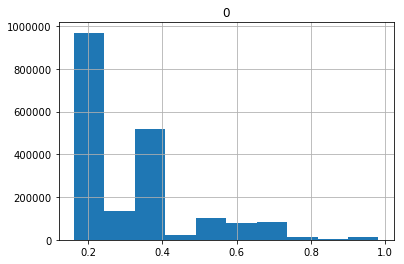

In [202]:
df_p = pd.DataFrame(y_predict_prob)
df_p.hist()

In [191]:
data['user_id'].head()

0    24677791
1    24677792
2    24677793
3    24677794
4    24677795
Name: user_id, dtype: int64

In [31]:
strange_user_data = pd.read_pickle("strange_user_data.gzip",compression="gzip") 

In [36]:
def features_engineering(df):
    # Features
    # age
    df["age_18_24"] = ((df["age"] >= 18) & (df["age"] < 24))
    df["age_24_30"] = ((df["age"] >= 24) & (df["age"] < 30))
    df["age_30_40"] = ((df["age"] >= 30) & (df["age"] < 40))
    df["age_40_50"] = ((df["age"] >= 40) & (df["age"] < 50))
    df["age_50_80"] = ((df["age"] >= 50) & (df["age"] <= 80))
    df["age_trash"] = ((df["age"] < 18) | (df["age"] > 80))
    # locle
    df["locale_en_US"] = df["locale"] == "en_US"
    df["locale_de_DE"] = df["locale"] == "de_DE"
    df["locale_id_ID"] = df["locale"] == "id_ID"
    df["locale_it_IT"] = df["locale"] == "it_IT"
    df["locale_zh_CN"] = df["locale"] == "zh_CN"
    df["locale_fr_FR"] = df["locale"] == "fr_FR"
    df["locale_es_ES"] = df["locale"] == "es_ES"
    df["locale_th_TH"] = df["locale"] == "th_TH"
    # country
    df['country_id_225'] = df['country_id'] == 225
    df['country_id_94'] = df['country_id'] == 94
    df['country_id_30'] = df['country_id'] == 30
    df['country_id_164'] = df['country_id'] == 164
    df['country_id_140'] = df['country_id'] == 140
    df['country_id_97'] = df['country_id'] == 97
    df['country_id_175'] = df['country_id'] == 175
    df['country_id_205'] = df['country_id'] == 205
    df['country_id_206'] = df['country_id'] == 206
    df['country_id_157'] = df['country_id'] == 157
    # gender
    df["gender_1"] = df["gender"] == 1
    df["gender_2"] = df["gender"] == 2
    # currency_id
    df['currency_id_5'] = df['currency_id'] == 5
    df['currency_id_1'] = df['currency_id'] == 1
    df['currency_id_2'] = df['currency_id'] == 2
    df['currency_id_6'] = df['currency_id'] == 6
    df['currency_id_43'] = df['currency_id'] == 43
    # client_platform_id
    df['client_platform_id'] = df['client_platform_id'] == 9
    df['client_platform_id'] = df['client_platform_id'] == 3
    df['client_platform_id'] = df['client_platform_id'] == 12
    df['client_platform_id'] = df['client_platform_id'] == 13
    df['client_platform_id'] = df['client_platform_id'] == 14
    df['client_platform_id'] = df['client_platform_id'] == 1000
    # logical
    df["is_trial"] = df["is_trial"].fillna(False)
    df["is_regulated"] = df["is_regulated"].fillna(False)
    df["is_public"] = df["is_public"].fillna(False)
    df["is_public_1"] = df["is_public"] == True
    df["is_public_0"] = df["is_public"] == False

    # fill na by prefix
    def fill_na_by_prefix(df, prefixs, def_na=0):
        cols_for_fill = []
        for col_name in df.columns.values:
            for pref in prefixs:
                if col_name.startswith(pref):
                    cols_for_fill.append(col_name)
        df[cols_for_fill] = df[cols_for_fill].fillna(def_na)

    fill_na_by_prefix(df, prefixs=["b_", "n_", "c_"])
    # df["binary_pnl_30"] = df["binary_pnl_30"].fillna(0)
    # df["commission_30"] = df["commission_30"].fillna(0)
    # df["ni_pnl_30"] = df["ni_pnl_30"].fillna(0)
    # df["sum_pnl"] = df["sum_pnl"].fillna(0)
    # df["has_pnl"] = df["has_pnl"].fillna(False)
    return df
FEATURE_COLUMNS = ['b_actives_real_count',
                   'b_actives_train_count',
                   'b_deals',
                   'b_pnl_real',
                   'b_pnl_train',
                   'b_real_count',
                   'b_train_count',
                   'b_volume_real',
                   'b_volume_train',
                   'c_actives_real_count',
                   'c_actives_train_count',
                   'c_cfd_count',
                   'c_commission_real_cfd',
                   'c_commission_real_crypto',
                   'c_commission_train_cfd',
                   'c_commission_train_crypto',
                   'c_count',
                   'c_crypto_count',
                   'c_instrument_id_cfd_count',
                   'c_instrument_id_count',
                   'c_instrument_id_crypto_count',
                   'c_real_count',
                   'c_train_count',
                   'n_cfd_count',
                   'n_closed_count',
                   'n_crypto_count',
                   'n_deal_count',
                   'n_digital_count',
                   'n_forex_count',
                   'n_instrument_actives_cfd_count',
                   'n_instrument_actives_count',
                   'n_instrument_actives_crypto_count',
                   'n_instrument_actives_digital_count',
                   'n_instrument_actives_forex_count',
                   'n_pnl_real_cfd',
                   'n_pnl_real_crypto',
                   'n_pnl_real_digital',
                   'n_pnl_real_forex',
                   'n_pnl_train_cfd',
                   'n_pnl_train_crypto',
                   'n_pnl_train_digital',
                   'n_pnl_train_forex',
                   'n_volume_real_cfd',
                   'n_volume_real_crypto',
                   'n_volume_real_digital',
                   'n_volume_real_forex',
                   'n_volume_train_cfd',
                   'n_volume_train_crypto',
                   'n_volume_train_digital',
                   'n_volume_train_forex',
                   'age_18_24',
                   'age_24_30',
                   'age_30_40',
                   'age_40_50',
                   'age_50_80',
                   'age_trash',
                   'locale_en_US',
                   'locale_de_DE',
                   'locale_id_ID',
                   'locale_it_IT',
                   'locale_zh_CN',
                   'locale_fr_FR',
                   'locale_es_ES',
                   'locale_th_TH',
                   'gender_1',
                   'gender_2',
                   'is_public_1',
                   'is_public_0',
                   'has_nik',
                   'is_regulated',
                   'is_trial']


def df_to_feature_matrix(df):
    return df[FEATURE_COLUMNS].as_matrix()

In [39]:
strange_user_data_features = features_engineering(strange_user_data)

TypeError: __init__() got an unexpected keyword argument 'strange_user_data_features'

In [3]:
data.head()

user_id   age  b_actives_real_count  b_actives_train_count  b_deals  \
0  24677791   NaN                   0.0                    0.0      0.0   
1  24677792   NaN                   0.0                    0.0      0.0   
2  24677793   NaN                   0.0                    0.0      0.0   
3  24677794  26.0                   0.0                    0.0      0.0   
4  24677795   NaN                   0.0                    0.0      0.0   

   b_pnl_real  b_pnl_train  b_real_count  b_train_count  b_volume_real  \
0         0.0          0.0           0.0            0.0            0.0   
1         0.0          0.0           0.0            0.0            0.0   
2         0.0          0.0           0.0            0.0            0.0   
3         0.0          0.0           0.0            0.0            0.0   
4         0.0          0.0           0.0            0.0            0.0   

      ...       currency_id_3  client_platform_id_2  client_platform_id_9  \
0     ...               False                  True                 False   
1     ...               False                  True                 False   
2     ...               False                  True                 False   
3     ...               False                  True                 False   
4     ...               False                 False                  True   

   client_platform_id_3  client_platform_id_12  client_platform_id_1000  \
0                 False                  False                    False   
1                 False                  False                    False   
2                 False                  False                    False   
3                 False                  False                    False   
4                 False                  False                    False   

   client_platform_id_14  client_platform_id_13  is_public_1  is_public_0  
0                  False                  False        False         True  
1                  False                  False        False         True  
2                  False                  False        False         True  
3                  False                  False        False         True  
4                  False                  False        False         True  

[5 rows x 176 columns]